# Análisis Exploratorio de Datos (EDA)

## Introducción

En esta sección realizo un **Análisis Exploratorio de Datos (EDA)** sobre el dataset procesado previamente, con el objetivo de identificar patrones clave y tendencias en las ventas.

Utilizo una combinación de **SQL** para consultas descriptivas y agregadas, y **pandas/matplotlib** para análisis adicionales y visualizaciones.

A lo largo de este análisis, abordo las siguientes preguntas de negocio:

1. ¿Cuáles son los 10 productos con mayores ventas?
2. ¿Cuáles son los países con más ventas?
3. ¿Cómo han cambiado las ventas a lo largo del tiempo (por mes)?
4. ¿Quiénes son los clientes que más compran?
5. ¿Qué porcentaje de facturas corresponden a devoluciones?
6. ¿Cuál es el ticket promedio por factura?
7. ¿En qué días de la semana se vende más?
8. ¿Existen patrones de ventas por temporada/mes?
9. ¿Cuáles son los productos más devueltos?
10. ¿Qué productos suelen comprarse juntos?

Este enfoque integral permite obtener insights claros y comunicar resultados tanto desde la perspectiva de bases de datos como desde el análisis visual en Python.

---
### 1. Importamos todas las librerías necesarias para los análisis y visualizaciones

Es necesario tener **instalada** la extensión correspondiente para poder ejecutar consultas SQL desde Python.  
Además, **importo** librerías estándar utilizadas en la sección anterior, como Pandas, NumPy, Matplotlib para el análisis de datos, y Seaborn para generar visualizaciones mucho más profesionales.

También configuro los gráficos para que las visualizaciones estén **alineadas con el formato del notebook**.

In [1]:
# Instalación de la extensión SQL (descomentar esta línea si se está trabajando desde un entorno temporal como Google Colab)
# !pip install ipython-sql

# Carga de librerías principales para el análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de gráficos para notebooks
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')

---
### 2. Cargamos el dataset y lo convertimos a una base de datos

Procedo a cargar el **dataset limpio** generado en la sección anterior y la convierto en una **base de datos SQLite**, que será el motor que utilzaré en este notebook para realizar consultas SQL.

Luego, cargo la extensión `ipython-sql` y la conecto a la base de datos creada. Finalmente, realizo algunos ajustes de compatibilidad y formato para asegurar que todo funcione correctamente.

In [2]:
from pathlib import Path

# Carpeta raíz y rutas relativas
BASE_DIR = Path.cwd().parent
csv_path = BASE_DIR / 'data' / 'online_retail_clean.csv'
db_path = BASE_DIR / 'data' / 'retail.db'

# Cargar el dataset limpio (proveniente del paso anterior)
df = pd.read_csv(csv_path)

# Convertir el DataFrame a una base de datos SQLite (.db)
from sqlalchemy import create_engine

engine = create_engine(f'sqlite:///{db_path}')
df.to_sql('retail', engine, if_exists='replace', index=False)

# Cargar la extensión SQL y conexión a la base
%load_ext sql
%sql sqlite:///{db_path}

# Fix de compatibilidad de versiones reciente de ipython-sql (prettytable)
import prettytable
prettytable.DEFAULT = prettytable.TableStyle.PLAIN_COLUMNS

# Descomentar esta línea si se está trabajando desde un entorno temporal como Google Colab
# !pip install --upgrade prettytable

Convierto la columna `Year_Month` del DataFrame al tipo *period[M]* para poder facilitar el **análisis temporal por meses**.

In [3]:
df['Year_Month'] = df['Year_Month'].astype('period[M]')

Defino una función con múltiples **sentencias assert** para validar la integridad del DataFrame y de las columnas que utilizaré en las transformaciones.

Los parámetros son los siguientes:

df : DataFrame a validar  
col_num : columna numérica que debe existir y ser numérica  
col_text : columna de texto que debe existir y no estar vacía  
negative : si False, los valores numéricos no pueden ser negativos

In [4]:
# Definir una función de validación de datos
def df_check(df, col_num=None, col_text=None, col_date=None, negative=True):
      
    # Verificar que el DataFrame no esté vacío
    assert not df.empty, 'El DataFrame está vacío.'

    # Helper para aceptar input string o lista
    def to_list(cols):
        return [cols] if isinstance(cols, str) else cols

    # Validar columna numérica
    if col_num:
        for col in to_list(col_num):
            assert col in df.columns, f'Falta la columna {col}.'
            assert df[col].notna().all(), f'{col} tiene valores nulos.'
            assert df[col].dtype.kind in 'ifc', f'{col} no es numérica.'
            if not negative:
                assert (df[col] >= 0).all(), f'{col} tiene valores negativos.'
    
    # Validar columna de texto
    if col_text:
        for col in to_list(col_text):
            assert col in df.columns, f'Falta la columna {col}.'
            assert df[col].notna().all(), f'{col} tiene valores nulos.'
            assert (df[col].str.strip() != '').all(), f'{col} tiene valores vacíos.'

    # Validar columna datetime
    if col_date:
        for col in to_list(col_date):
            assert col in df.columns, f'Falta la columna {col}.'
            assert df[col].notna().all(), f'{col} tiene valores nulos.'
            assert df[col].dtype.kind == 'M', f'{col} no es de tipo datetime.'
        
    # Detectar duplicados exactos
    assert not df.duplicated().all(), 'El DataFrame contiene filas duplicadas.'
    
    # Verificar que el DataFrame tenga más de un registro
    assert len(df) > 1, 'No hay suficientes registros para el análisis.'

Habiendo hecho estos **ajustes previos**, procedo a responder las preguntas del análisis.

El **enfoque** de este análisis es comparar el **comportamiento** de las ventas brutas (sin contar devoluciones) con las ventas netas (que sí las consideran). Cuando el código y el formato lo permitan, se utilizarán tablas que reúnan ambas métricas para facilitar la comparación.

La metodología a usar será: Realizar una consulta **SQL** para obtener la información relevante para responder la pregunta, ejecutar transformaciones necesarias en **Pandas** y generar visualizaciones utilizando **Matplotlib** y **Seaborn**. 

Cabe aclarar que el objetivo de los gráficos es **comunicar claramente** los hallazgos, por lo que se priorizarán la legibilidad y la comprensión por encima de la interactividad. Esta última se abordará en la próxima sección mediante un **dashboard** en Power BI.

## Análisis y exploración

---
### 3. Pregunta 1: ¿Cuáles son los 10 productos con mayores ventas?

#### 3.1. Ventas brutas

En esta sección obtengo los **productos** con **mayores ventas brutas totales**, es decir, **sin considerar devoluciones**. Para ello:
- Consulto la base de datos y sumo el total de unidades vendidas (`Quantity`) con el alias "Units Sold", el número de facturas distintas en el que aparece el producto con el alias "Number of Invoices" y el valor total de pedidos (`LineTotal`) por producto con el alias "Total Gross Sales".
- Convierto el resultado en un DataFrame y selecciono los 10 productos más vendidos en bruto.
- Finalmente, grafico los resultados en una barra horizontal para facilitar su comparación visual. 

In [5]:
# Obtener productos por ventas brutas (sin devoluciones) mediante SQL
query = """
SELECT
    "Description",
    SUM("Quantity") AS "Units Sold",
    SUM("LineTotal") AS "Total Gross Sales"
FROM retail
WHERE "Quantity" > 0
GROUP BY "Description"
ORDER BY "Total Gross Sales" DESC;
"""

# Convertir consulta a DataFrame
products_gsales = pd.read_sql_query(query, engine)

# Copiar DataFrame y mostrar los 10 primeros
top_products_gsales = products_gsales.head(10).copy()

# Formatear columnas y mostrar resultados
top_products_gsales['Units Sold'] = top_products_gsales['Units Sold'].map('{:,.0f}'.format)
top_products_gsales['Total Gross Sales'] = top_products_gsales['Total Gross Sales'].map('{:,.0f}'.format)
display(top_products_gsales)

Description Units Sold Total Gross Sales
0            REGENCY CAKESTAND 3 TIER     27,571           344,487
1  WHITE HANGING HEART T-LIGHT HOLDER     96,737           267,081
2             JUMBO BAG RED RETROSPOT     98,768           185,566
3         PAPER CRAFT , LITTLE BIRDIE     80,995           168,470
4                       PARTY BUNTING     28,378           149,187
5       ASSORTED COLOUR BIRD ORNAMENT     81,787           132,151
6      PAPER CHAIN KIT 50'S CHRISTMAS     36,581           123,142
7                       CHILLI LIGHTS     16,840            85,490
8      MEDIUM CERAMIC TOP STORAGE JAR     78,033            81,701
9                SMALL POPCORN HOLDER     89,883            80,908

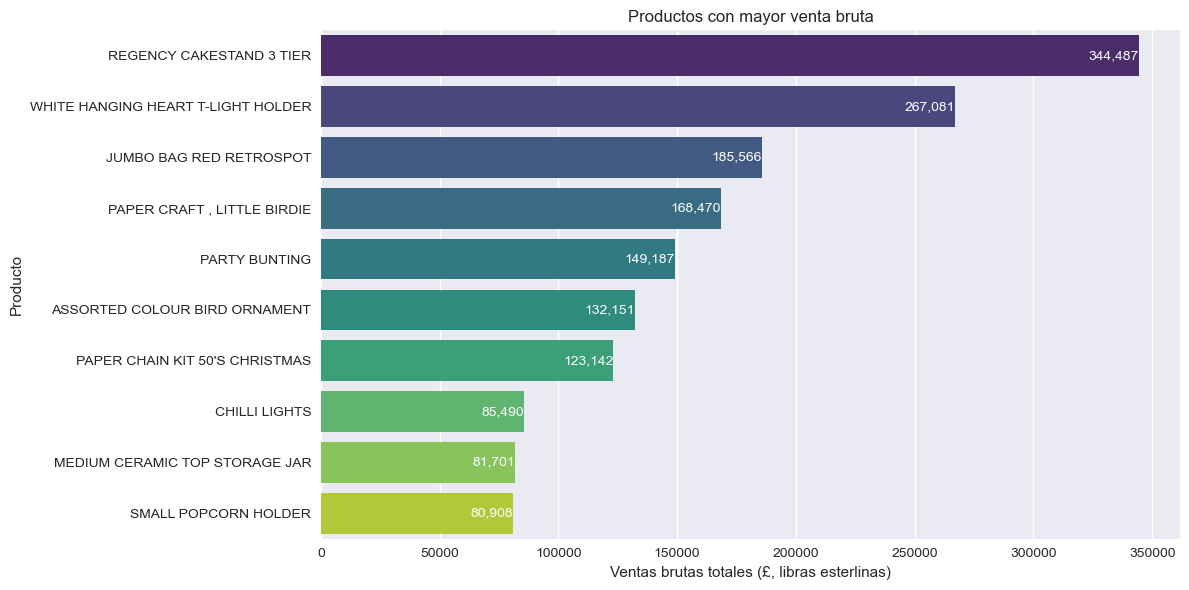

In [6]:
# Convertir valores a float
try:
    top_products_gsales['Total Gross Sales'] = top_products_gsales['Total Gross Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validar la integridad del DataFrame a usar en el gráfico
df_check(top_products_gsales, col_num='Total Gross Sales', col_text='Description', negative=False)

# Crear gráfico barplot
plt.figure(figsize=(12, 6))
ax=sns.barplot(
    data=top_products_gsales,
    y= 'Description',
    x='Total Gross Sales',
    hue='Description',
    palette='viridis',
    legend=False
)

# Agregar etiquetas de datos
for i, value in enumerate(top_products_gsales['Total Gross Sales']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Personalizar formato de gráfico
plt.title('Productos con mayor venta bruta')
plt.xlabel('Ventas brutas totales (£, libras esterlinas)')
plt.ylabel('Producto')
plt.tight_layout()
plt.show()        

Se puede observar que:

* El producto **"REGENCY CAKESTAND 3 TIER"** destaca ampliamente como el **más vendido**, superando las 344 mil libras esterlinas.
* Le sigue el **"WHITE HANGING HEART T-LIGHT HOLDER"**, con más de 267 mil.
* A partir del **tercer puesto**, el **monto de ventas disminuye progresivamente**, mostrando una larga cola de productos populares pero con **menor impacto individual**.

Este gráfico nos ayuda a identificar rápidamente qué productos son los más importantes en términos de volumen bruto de ingresos, lo cual puede ser útil para estrategias de stock, promociones o bundles.

Con el fin de obtener una visión más completa del comportamiento de ventas, se realizará una consulta que identifique los **10 productos más vendidos por unidades**, excluyendo las devoluciones.

In [7]:
# Obtener productos por unidades vendidas (sin devoluciones) 
query = """
SELECT
    "Description",
    SUM("Quantity") AS "Units Sold",
    SUM("LineTotal") AS "Total Gross Sales"
FROM retail
WHERE "Quantity" > 0
GROUP BY "Description"
ORDER BY "Units Sold" DESC;
"""

# Convertir consulta a DataFrame
products_gunits = pd.read_sql_query(query, engine)

# Copiar DataFrame y mostrar los 10 primeros
top_products_gunits = products_gunits.head(10).copy()

# Formatear columnas y mostrar resultados
top_products_gunits['Units Sold'] = top_products_gunits['Units Sold'].map('{:,.0f}'.format)
top_products_gunits['Total Gross Sales'] = top_products_gunits['Total Gross Sales'].map('{:,.0f}'.format)
display(top_products_gunits)

Description Units Sold Total Gross Sales
0   WORLD WAR 2 GLIDERS ASSTD DESIGNS    110,042            25,232
1             JUMBO BAG RED RETROSPOT     98,768           185,566
2  WHITE HANGING HEART T-LIGHT HOLDER     96,737           267,081
3     PACK OF 72 RETROSPOT CAKE CASES     96,499            52,964
4                SMALL POPCORN HOLDER     89,883            80,908
5       ASSORTED COLOUR BIRD ORNAMENT     81,787           132,151
6         PAPER CRAFT , LITTLE BIRDIE     80,995           168,470
7      MEDIUM CERAMIC TOP STORAGE JAR     78,033            81,701
8                  BROCADE RING PURSE     71,430            14,959
9  PACK OF 60 PINK PAISLEY CAKE CASES     56,720            28,450

La tabla revela un dato interesante: el producto con mayores ventas unitarias no coincide con el de mayores ventas monetarias. 

En este caso, el producto más popular, **"WORLD WAR 2 GLIDERS ASSTD DESIGNS"**, con **110,042 unidades vendidas**, genera únicamente unas **25 mil libras esterlinas en ventas brutas**.  

Además, solo 6 productos aparecen simultáneamente en el Top 10 por unidades y en el Top 10 por valor monetario, lo que evidencia **diferencias significativas entre popularidad y aporte económico**.

#### 3.2. Ventas netas

En esta sección obtengo los **productos** con **mayores ventas netas totales**, es decir, **considerando devoluciones**. Para ello:

* Consulto la base de datos y sumo el total de pedidos (`LineTotal`) por producto con el alias *"Total Net Sales"*.
* Convierto el resultado en un DataFrame y selecciono los 10 productos más vendidos en neto.
* Finalmente, grafico los resultados en una barra horizontal para facilitar su comparación visual.

In [8]:
# Obtener productos por ventas netas (incluyendo devoluciones)
query = """
SELECT
    "Description",
    SUM("Quantity") AS "Units Sold",
    SUM("LineTotal") AS "Total Net Sales"
FROM retail
GROUP BY "Description"
ORDER BY SUM("LineTotal") DESC;
"""

# Convertir consulta a DataFrame
products_nsales = pd.read_sql_query(query, engine)

# Copiar DataFrame y mostrar los 10 primeros
top_products_nsales = products_nsales.head(10).copy()

# Formatear columnas y mostrar resultados
top_products_nsales['Units Sold'] = top_products_nsales['Units Sold'].map('{:,.0f}'.format)
top_products_nsales['Total Net Sales'] = top_products_nsales['Total Net Sales'].map('{:,.0f}'.format)
display(top_products_nsales)

Description Units Sold Total Net Sales
0             REGENCY CAKESTAND 3 TIER     26,103         327,737
1   WHITE HANGING HEART T-LIGHT HOLDER     93,099         257,692
2              JUMBO BAG RED RETROSPOT     97,551         183,390
3                        PARTY BUNTING     28,093         147,948
4        ASSORTED COLOUR BIRD ORNAMENT     81,276         131,377
5       PAPER CHAIN KIT 50'S CHRISTMAS     35,985         121,662
6                        CHILLI LIGHTS     16,695          84,854
7                 SMALL POPCORN HOLDER     89,074          80,287
8              JUMBO BAG PINK POLKADOT     39,358          76,245
9  ROTATING SILVER ANGELS T-LIGHT HLDR     13,774          73,812

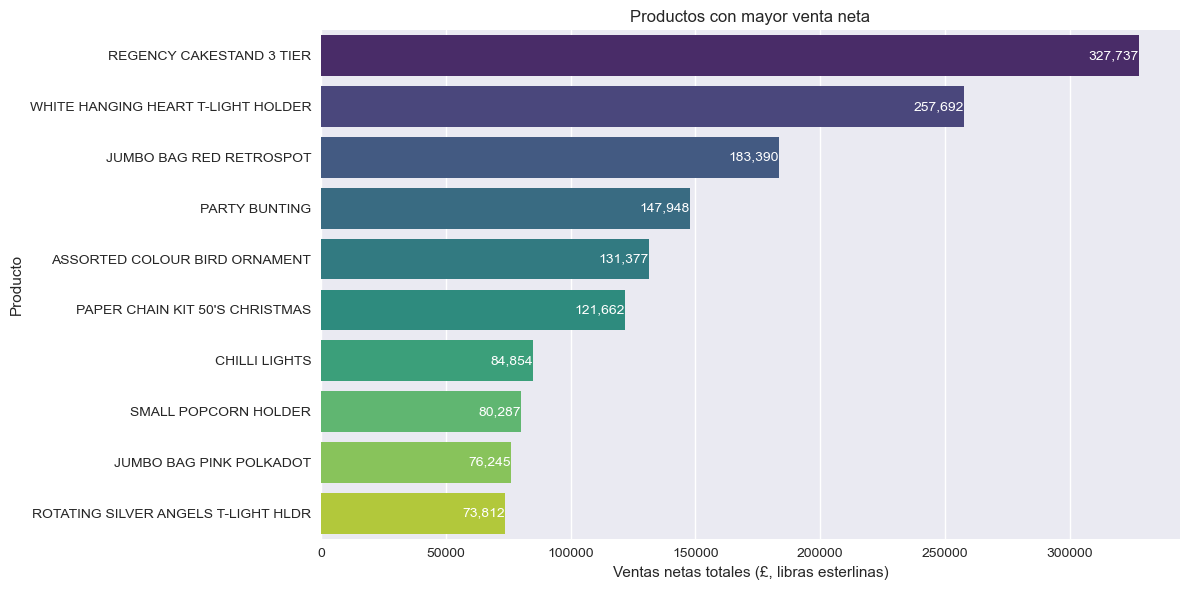

In [9]:
# Convertir valores a float
try:
    top_products_nsales['Total Net Sales'] = top_products_nsales['Total Net Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validar integridad
df_check(top_products_nsales, col_num='Total Net Sales', col_text='Description', negative=True)

# Crear gráfico barplot
plt.figure(figsize=(12, 6))
ax=sns.barplot(
    data=top_products_nsales,
    x='Total Net Sales',
    y='Description',
    hue='Description',
    palette='viridis',
    legend=False
)

# Agregar etiquetas de datos
for i, value in enumerate(top_products_nsales['Total Net Sales']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Personalizar formato de gráfico
plt.title('Productos con mayor venta neta')
plt.xlabel('Ventas netas totales (£, libras esterlinas)')
plt.ylabel('Producto')
plt.tight_layout()
plt.show()

Se puede observar, al igual que con las ventas brutas, que:

* El producto **"REGENCY CAKESTAND 3 TIER"** destaca ampliamente como el más vendido, superando las 327 mil libras esterlinas.
* Le sigue el **"WHITE HANGING HEART T-LIGHT HOLDER"**, con más de 257 mil.
* A partir del **tercer puesto**, el **monto de ventas disminuye progresivamente**. Sin embargo, mientras que en ambos gráficos se mantienen **los tres primeros productos** como **top vendidos**, esta tabla muestra diferentes productos en la posición 4 al 10, debido a que este gráfico considera el impacto de las devoluciones sobre las ventas.

Este gráfico nos ayuda a identificar qué productos son los más importantes en términos de venta real.

De igual manera realizo una consulta para identificar aquellos productos con la **mayor cantidad de unidades vendidas** luego de aplicar las devoluciones.

In [10]:
# Obtener productos por unidades vendidas (incluyendo devoluciones)
query = """
SELECT
    "Description",
    SUM("Quantity") AS "Units Sold",
    SUM("LineTotal") AS "Total Net Sales"
FROM retail
GROUP BY "Description"
ORDER BY "Units Sold" DESC;
"""

# Convertir consulta a DataFrame
products_nunits = pd.read_sql_query(query, engine)

# Copiar DataFrame y mostrar los 10 primeros
top_products_nunits = products_nunits.head(10).copy()

# Formatear columnas y mostrar resultados
top_products_nunits['Units Sold'] = top_products_nunits['Units Sold'].map('{:,.0f}'.format)
top_products_nunits['Total Net Sales'] = top_products_nunits['Total Net Sales'].map('{:,.0f}'.format)
display(top_products_nunits)

Description Units Sold Total Net Sales
0   WORLD WAR 2 GLIDERS ASSTD DESIGNS    108,338          24,870
1             JUMBO BAG RED RETROSPOT     97,551         183,390
2     PACK OF 72 RETROSPOT CAKE CASES     95,389          52,414
3  WHITE HANGING HEART T-LIGHT HOLDER     93,099         257,692
4                SMALL POPCORN HOLDER     89,074          80,287
5       ASSORTED COLOUR BIRD ORNAMENT     81,276         131,377
6                  BROCADE RING PURSE     70,690          14,743
7  PACK OF 60 PINK PAISLEY CAKE CASES     56,501          28,333
8         60 TEATIME FAIRY CAKE CASES     54,220          27,136
9              MINI PAINT SET VINTAGE     45,384          28,864

En esta tabla se observa que el producto más vendido sigue siendo **"WORLD WAR 2 GLIDERS ASSTD DESIGNS"**, incluso después de considerar las devoluciones.

Le sigue en el ranking **"WHITE HANGING HEART T-LIGHT HOLDER"**, al igual que en la lista que no contemplaba devoluciones. 

Es importante destacar que las demás posiciones sí se ven afectadas por el impacto de los retornos: ahora solo 4 productos coinciden con el Top 10 de mayor venta neta.

#### 3.3. Comparativo ventas

Para esta última sección de la pregunta 1, **combino ambas tablas** para obtener una visión más completa del comportamiento de las ventas, comparando el valor de los productos vendidos con el valor que realmente se conserva en la empresa luego de considerar las devoluciones.

Este procedimiento será la **base para los análisis comparativos** que se realizarán en las siguientes secciones. Los pasos seguidos son los siguientes:

* Creo **copia de los Dataframes originales** para preservar las consultas iniciales y aplicar transformaciones sin alterar los datos fuente.
* Combino ambos DataFrames en uno solo que servirá de base para la visualización conjunta.
* Convierto los valores numéricos nuevamente a tipo `float` para asegurar un **cálculo y visualización correctos**.
* Por último, grafico la comparación en un **barplot agrupado** mostrando de forma clara la **diferencia** entre ventas brutas y ventas netas para cada producto.

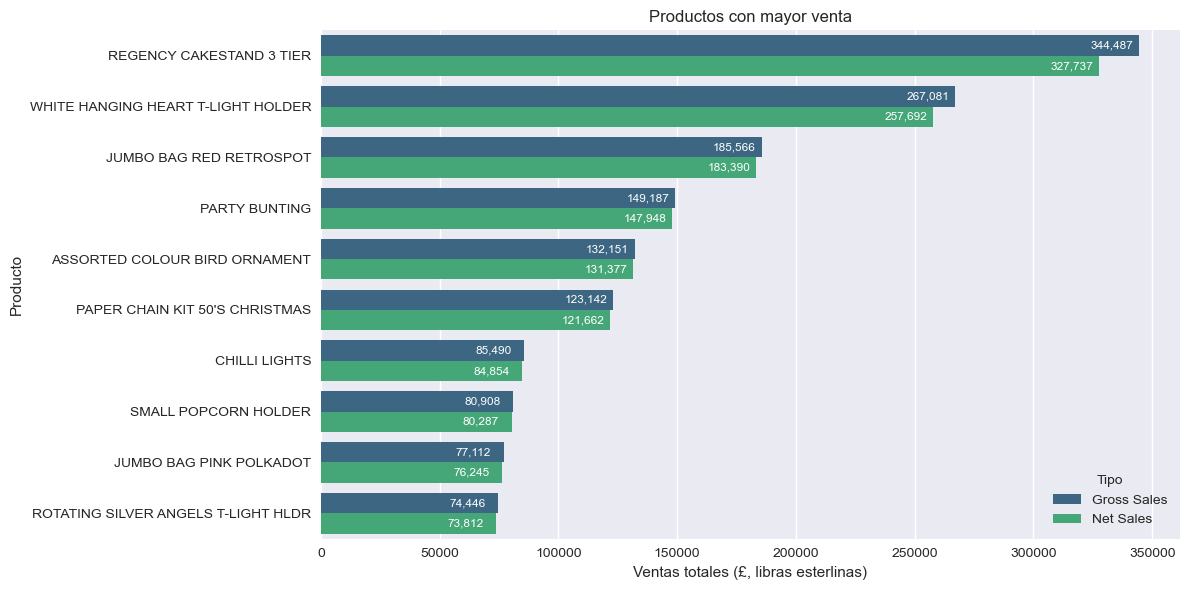

In [11]:
# Copiar DataFrames originales para transformación
pgs = products_gsales.copy()
pns = products_nsales.copy()

# Unir ventas netas y brutas por producto y renombrar columnas
merged_prod = pd.merge(pns, pgs, on='Description', how='left')
merged_prod = merged_prod.rename(columns={
    'Total Net Sales': 'Net Sales',
    'Total Gross Sales': 'Gross Sales'
})

# Convertir valores a float
try:
    for col in ['Net Sales', 'Gross Sales']:
        merged_prod[col] = merged_prod[col].str.replace(',','').astype(float)
except AttributeError:
    pass

# Crear DataFrame con los 10 primeros y convertirlo a formato largo
top_10_prod = merged_prod.sort_values(by='Net Sales', ascending=False).head(10)
top_products_sales = top_10_prod.melt(
    id_vars='Description',
    value_vars=['Net Sales', 'Gross Sales'],
    var_name='Type',
    value_name='Total Sales'
)

# Validar integridad
df_check(top_products_sales, col_num='Total Sales', col_text=['Description', 'Type'], negative=True)

# Crear gráfico barplot (agrupado)
plt.figure(figsize=(12,6))
ax=sns.barplot(
    data=top_products_sales,
    x='Total Sales',
    y='Description',
    hue='Type',
    hue_order=['Gross Sales', 'Net Sales'],
    palette='viridis'
)

# Agregar etiquetas de datos
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v.get_width():,.0f}' for v in container], 
                 label_type='edge', padding=-35, fontsize=8.5, color='white')

# Personalizar formato de gráfico
plt.title('Productos con mayor venta')
plt.xlabel('Ventas totales (£, libras esterlinas)')
plt.ylabel('Producto')
plt.legend(title='Tipo')
plt.tight_layout()
plt.show()

Este gráfico muestra la **gran diferencia en ventas** que tienen los **primeros dos productos** sobre el resto. 

Además, se puede observar que la diferencia entre las ventas brutas y netas de cada producto **no son significativas**, sin embargo, son más notorias para los dos primeros productos, lo cual puede ser explicado por su **volumen de ventas**.

---
### 4. Pregunta 2: ¿Cuáles son los países con más ventas?

#### 4.1. Ventas brutas

Para responder esta pregunta realizo una consulta en SQL que devuelve los 10 primeros **países** con **mayores ventas brutas totales** y su porcentaje en relación a la venta bruta total. Luego muestro los resultados en un barplot horizontal.

In [12]:
# Obtener países por ventas brutas y su porcentaje respecto al total
query = """
SELECT 
    "Country",
    SUM("LineTotal") AS "Total Gross Sales",
    ROUND(100.0 * SUM("LineTotal") / (
        SELECT SUM("LineTotal")
        FROM retail
        WHERE "Quantity" > 0
        ), 2) AS "Percentage of Total"
FROM retail
WHERE "Quantity" > 0
GROUP BY "Country"
ORDER BY SUM("LineTotal") DESC;
"""

# Convertir consulta a DataFrame
countries_gsales = pd.read_sql_query(query, engine)

# Copiar DataFrame y mostrar los 10 primeros
top_countries_gsales = countries_gsales.head(10).copy()

# Formatear columnas y mostrar resultados
top_countries_gsales['Total Gross Sales'] = top_countries_gsales['Total Gross Sales'].map('{:,.0f}'.format)
top_countries_gsales['Percentage of Total'] = top_countries_gsales['Percentage of Total'].map('{:,.2f} %'.format)
display(top_countries_gsales)

Country Total Gross Sales Percentage of Total
0  United Kingdom        17,235,543             85.70 %
1         Ireland           638,934              3.18 %
2     Netherlands           549,953              2.73 %
3         Germany           388,830              1.93 %
4          France           317,345              1.58 %
5       Australia           168,485              0.84 %
6           Spain            98,613              0.49 %
7     Switzerland            94,270              0.47 %
8          Sweden            86,353              0.43 %
9         Denmark            68,560              0.34 %

Debido a la **gran diferencia** en ventas entre el país en la primera posición y los demás, tuve que formatear el **eje 'x'** del gráfico con una **escala logarítmica** para facilitar la visualización.

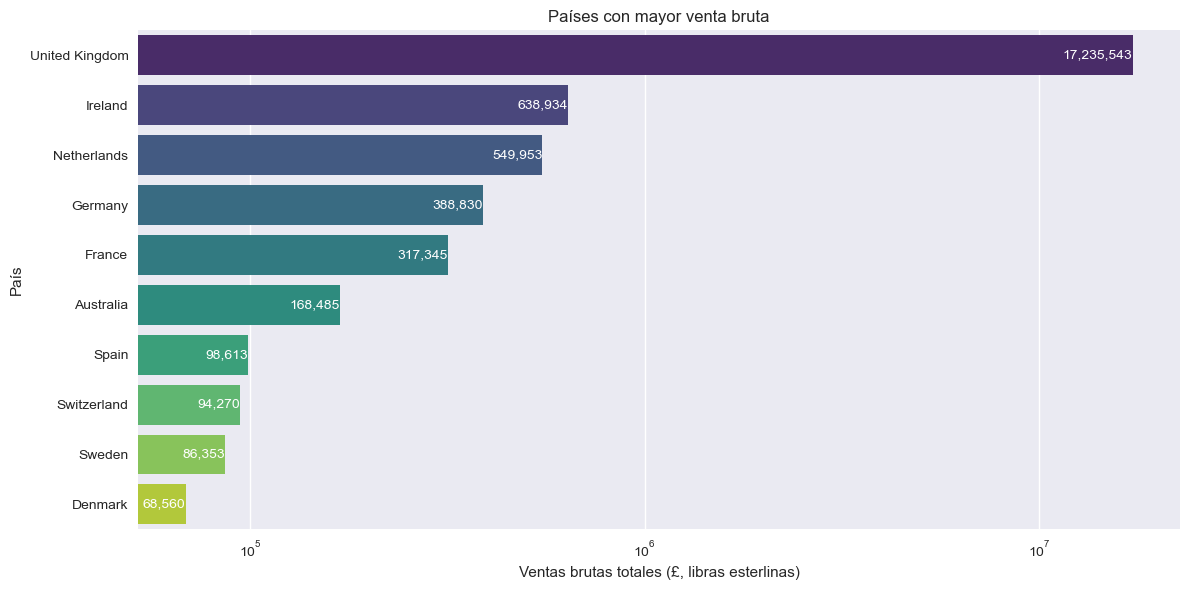

In [13]:
# Convertir valores a float
try:
    top_countries_gsales['Total Gross Sales'] = top_countries_gsales['Total Gross Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validar integridad
df_check(top_countries_gsales, col_num='Total Gross Sales', col_text='Country', negative=False)

# Crear gráfico barplot
plt.figure(figsize=(12, 6)) 
ax=sns.barplot(
    data=top_countries_gsales,
    y='Country',
    x='Total Gross Sales', 
    hue='Country',
    palette='viridis',
    legend=False
)

# Establecer escala logarítmica para legibilidad del gráfico
ax.set_xscale('log')

# Agregar etiquetas de datos
for i, value in enumerate(top_countries_gsales['Total Gross Sales']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10, color='white')

# Personalizar formato de gráfico
plt.title('Países con mayor venta bruta')
plt.xlabel('Ventas brutas totales (£, libras esterlinas)')
plt.ylabel('País')
plt.tight_layout()
plt.show()

El gráfico nos muestra que:

* **Reino Unido** representa casi la totalidad de las ventas brutas totales, superando los **17 millones de libras esterlinas** y representando aproximadamente el **86% de las ventas brutas totales** lo cual lo posiciona claramente como el **mercado principal**.
* **Irlanda** ocupa el segundo lugar con apenas aproximadamente **639 mil libras esterlinas** muy por debajo del líder de ventas.

#### 4.2. Ventas netas

No hay mucha variación en la consulta en SQL para las ventas netas.

In [14]:
# Obtener países por ventas netas y su porcentaje respecto al total
query = """
SELECT 
    "Country",
    SUM("LineTotal") AS "Total Net Sales",
    ROUND(100.0 * SUM("LineTotal") / (
        SELECT SUM("LineTotal")
        FROM retail
        ), 2) AS "Percentage of Total"
FROM retail
GROUP BY "Country"
ORDER BY SUM("LineTotal") DESC;
"""

# Convertir consulta a DataFrame
countries_nsales = pd.read_sql_query(query, engine)

# Copiar DataFrame y mostrar los 10 primeros
top_countries_nsales = countries_nsales.head(10).copy()

# Formatear columnas y mostrar resultados
top_countries_nsales['Total Net Sales'] = top_countries_nsales['Total Net Sales'].map('{:,.0f}'.format)
top_countries_nsales['Percentage of Total'] = top_countries_nsales['Percentage of Total'].map('{:,.2f} %'.format)
display(top_countries_nsales)

Country Total Net Sales Percentage of Total
0  United Kingdom      16,593,572             85.61 %
1         Ireland         618,472              3.19 %
2     Netherlands         546,275              2.82 %
3         Germany         379,901              1.96 %
4          France         299,656              1.55 %
5       Australia         166,967              0.86 %
6     Switzerland          93,164              0.48 %
7           Spain          85,658              0.44 %
8          Sweden          84,379              0.44 %
9         Denmark          64,493              0.33 %

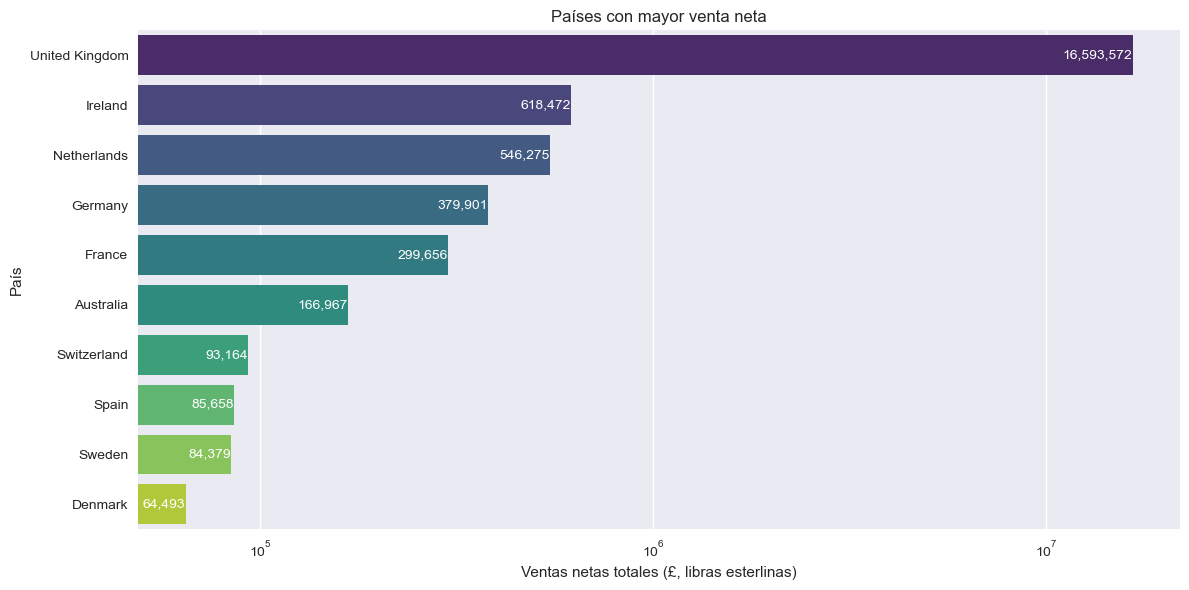

In [15]:
# Convertir valores a float
try:
    top_countries_nsales['Total Net Sales'] = top_countries_nsales['Total Net Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validar integridad
df_check(top_countries_nsales, col_num='Total Net Sales', col_text='Country', negative=True)

# Crear gráfico barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_countries_nsales,
    y='Country',
    x='Total Net Sales',
    hue='Country',
    palette='viridis',
    legend=False
)

# Establecer escala logarítmica para legibilidad del gráfico
ax.set_xscale('log')

# Agregar etiquetas de datos
for i, value in enumerate(top_countries_nsales['Total Net Sales']):
    ax.text(value - 1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Personalizar formato de gráfico
plt.title('Países con mayor venta neta')
plt.xlabel('Ventas netas totales (£, libras esterlinas)')
plt.ylabel('País')
plt.tight_layout()
plt.show()

Al igual que en el gráfico anterior se puede observar que:

* **Reino Unido** es claramente el líder en ventas netas totales, muy por encima del segundo lugar **Irlanda** con una diferencia aproximada de **16 millones de libras esterlinas**.
* En ambos casos, el **resto del Top 5** lo conforman Países Bajos, Alemania y Francia.
* **Suiza** supera a **España** en ventas netas, lo opuesto a lo demostrado en ventas brutas. Lo que demostraría mayor volumen de devoluciones para el país ibérico.

#### 4.3. Comparativo ventas

Para la comparación de ventas entre países se sigue el **mismo procedimiento** que en la pregunta anterior. Se combinan ambos DataFrames en uno solo para poder **visualizar ambas métricas** al mismo tiempo en el gráfico.

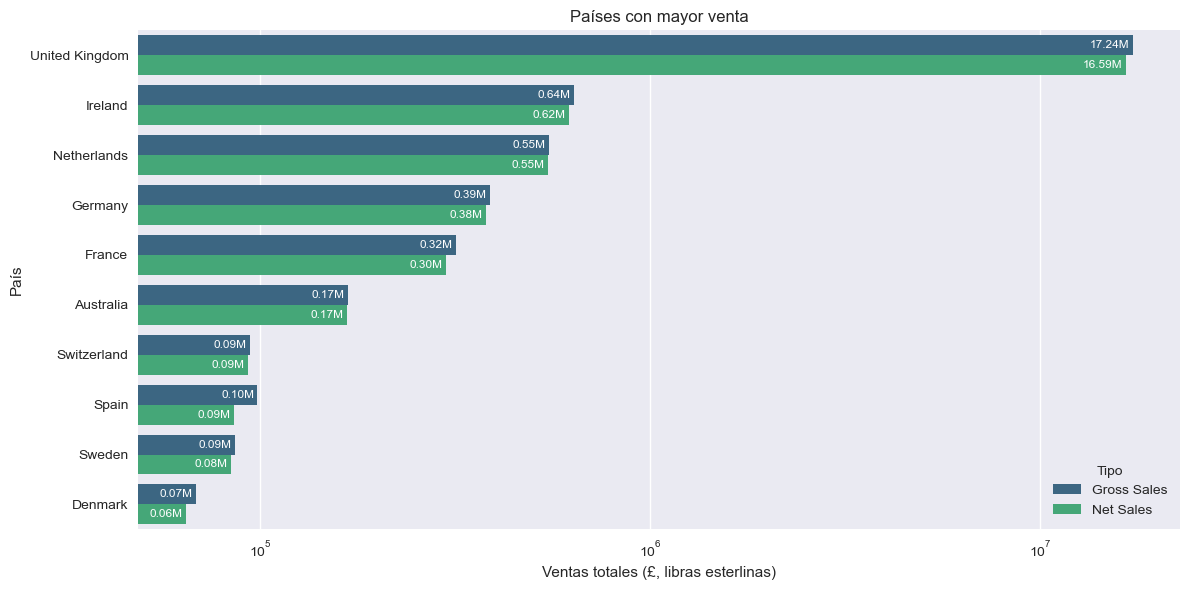

In [16]:
# Copiar DataFrames originales para transformación
cns = countries_nsales.copy()
cgs = countries_gsales.copy()

# Unir ventas netas y brutas por producto y renombrar columnas
merged_countries = pd.merge(cns, cgs, on='Country', how='left')
merged_countries = merged_countries.rename(columns={
    'Total Net Sales': 'Net Sales',
    'Total Gross Sales': 'Gross Sales'
})

# Convertir valores a float
try:
    for col in ['Net Sales', 'Gross Sales']:
        merged_countries[col] = merged_countries[col].str.replace(',','').astype(float)
except AttributeError:
    pass

# Crear DataFrame con los 10 primeros y convertirlo a formato largo
top_10_countries = merged_countries.sort_values(by='Net Sales', ascending=False).head(10)
top_countries_sales = top_10_countries.melt(
    id_vars='Country',
    value_vars=['Net Sales', 'Gross Sales'],
    var_name='Type',
    value_name='Total Sales'
)

# Validar integridad
df_check(top_countries_sales, col_num='Total Sales', col_text=['Country', 'Type'], negative=True)

# Crear gráfico barplot (agrupado)
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_countries_sales,
    x='Total Sales',
    y='Country',
    hue='Type',
    hue_order=['Gross Sales', 'Net Sales'],
    palette='viridis'
)

# Establecer escala logarítmica para legibilidad del gráfico
ax.set_xscale('log')

# Agregar etiquetas de datos
for container in ax.containers:
    for bar in container:
        value=bar.get_width()
        offset=value * 0.02
        ax.text(value - offset, bar.get_y() + bar.get_height() / 2, f'{value/1e6:.2f}M',
                va='center', ha='right', fontsize=8.5, color='white')

# Personalizar formato de gráfico
plt.title('Países con mayor venta')
plt.xlabel('Ventas totales (£, libras esterlinas)')
plt.ylabel('País')
plt.legend(title='Tipo')
plt.tight_layout()
plt.show()      

El gráfico nos muestra una visión más general del **volumen de ventas por país**. No se aprecian muchas más diferencias a las mostradas en anteriores gráficos. Sin embargo, algo que **resalta** en este gráfico es la **mayor diferencia proporcional** entre las ventas brutas y netas en **España**, lo cual revela una gran cantidad de **devoluciones** en este país.

---
### 5. Pregunta 3: ¿Cómo han cambiado las ventas por mes?

#### 5.1. Ventas brutas

Realizo la consulta en SQL para obtener la **venta bruta total por cada mes del año** en el DataFrame total. Esto es posible gracias a la columna `Year_Month` creada en el paso anterior de **exploración y limpieza de la base de datos**.

In [17]:
# Obtener ventas brutas por mes
query = """
SELECT "Year_Month" AS "Period",
    SUM("LineTotal") AS "Total Gross Sales"
FROM retail
WHERE "Quantity" > 0
GROUP BY "Period"
ORDER BY "Period" ASC;
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
gsales_by_month = pd.read_sql_query(query, engine)
gsales_by_month['Total Gross Sales'] = gsales_by_month['Total Gross Sales'].map('{:,.0f}'.format)
display(gsales_by_month)

Period Total Gross Sales
0   2009-12-01           801,603
1   2010-01-01           612,966
2   2010-02-01           539,945
3   2010-03-01           764,734
4   2010-04-01           649,091
5   2010-05-01           645,895
6   2010-06-01           699,766
7   2010-07-01           633,277
8   2010-08-01           676,711
9   2010-09-01           870,350
10  2010-10-01         1,098,868
11  2010-11-01         1,436,505
12  2010-12-01         1,188,008
13  2011-01-01           672,133
14  2011-02-01           509,101
15  2011-03-01           692,008
16  2011-04-01           516,164
17  2011-05-01           740,558
18  2011-06-01           738,579
19  2011-07-01           687,707
20  2011-08-01           725,164
21  2011-09-01         1,030,999
22  2011-10-01         1,107,250
23  2011-11-01         1,457,555
24  2011-12-01           615,543

La transformación de los datos para el gráfico *lineplot* implicó algunos pasos adicionales en comparación con los *barplots* mostrados anteriormente.

En este caso, para evitar saturar la visualización, decidí mostrar **etiquetas de datos** únicamente en los **tres meses con mayor y menor volumen de ventas**.

Para lograr el resultado final, el gráfico se compone de un *lineplot* que representa la evolución general de las ventas, complementado con tres *scatterplots* que marcan estos puntos clave sin sobrecargar la visualización con etiquetas en todos los valores.

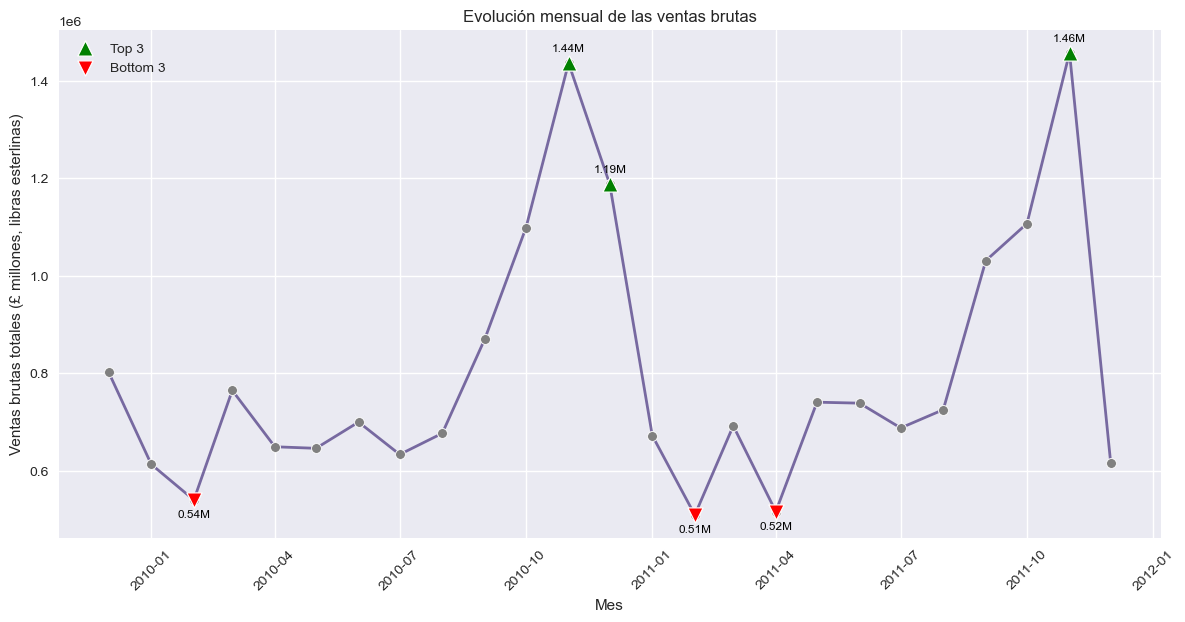

In [18]:
# Convertir valores a float
try:
    gsales_by_month['Total Gross Sales'] = gsales_by_month['Total Gross Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Convertir meses a formato datetime
gsales_by_month['Period'] = pd.to_datetime(gsales_by_month['Period'], format='%Y-%m-%d')

# Seleccionar los 3 meses con mayores y menores ventas brutas
top3_gsales = gsales_by_month.nlargest(3, 'Total Gross Sales')
bottom3_gsales = gsales_by_month.nsmallest(3, 'Total Gross Sales')

# Validar integridad
df_check(gsales_by_month, col_num='Total Gross Sales', col_date='Period', negative=False)

# Crear gráfico lineplot
plt.figure(figsize=(12, 6))
ax=sns.lineplot(
    data=gsales_by_month,
    x='Period',
    y='Total Gross Sales',
    marker='o',
    color='C0',
    linewidth=2,
    alpha=0.7,
    zorder=1
)

# Dibujar puntos normales en el gráfico
sns.scatterplot(
    data=gsales_by_month, x='Period', y='Total Gross Sales', color='gray', s=50, ax=ax, zorder=2
)

# Dibujar puntos Top 3 (en verde, triángulo hacia arriba)
sns.scatterplot(
    data=top3_gsales, x='Period', y='Total Gross Sales', color='green', s=120, marker='^', label='Top 3', ax=ax, zorder=5
)

# Dibujar puntos Bottom 3 (en rojo, triángulo hacia abajo)
sns.scatterplot(
    data=bottom3_gsales, x='Period', y='Total Gross Sales', color='red', s=120, marker='v', label='Bottom 3', ax=ax, zorder=5
)

# Agregar etiquetas de datos para Top 3
for i, row in top3_gsales.iterrows():
    date = row['Period']
    value = row['Total Gross Sales']
    ax.text(date, value+20000, f'{value/1e6:.2f}M',
            ha='center', va='bottom', fontsize=8.5, color='black')

# Agregar etiquetas de datos para Bottom 3
for i, row in bottom3_gsales.iterrows():
    date = row['Period']
    value = row['Total Gross Sales']
    ax.text(date, value-20000, f'{value/1e6:.2f}M',
            ha='center', va='top', fontsize=8.5, color='black')

# Personalizar formato de gráfico
plt.title('Evolución mensual de las ventas brutas')
plt.xlabel('Mes')
plt.ylabel('Ventas brutas totales (£ millones, libras esterlinas)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

La evolución de las ventas brutas sigue un **patrón casi cíclico** (que será analizado con más detalle en una pregunta posterior) con **picos considerables** en noviembre y **caídas pronunciadas** a comienzos de año.

#### 5.2. Ventas netas

De manera similar a la consulta anterior para las ventas brutas, se obtiene el **total de ventas netas por cada mes del año**, ordenado de manera ascendente y se muestra los resultados a través de un *lineplot*.

In [19]:
# Obtener ventas netas por mes
query = """
SELECT "Year_Month" AS "Period",
    SUM("LineTotal") AS "Total Net Sales"
FROM retail
GROUP BY "Period"
ORDER BY "Period" ASC;
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
nsales_by_month = pd.read_sql_query(query, engine)
nsales_by_month['Total Net Sales'] = nsales_by_month['Total Net Sales'].map('{:,.0f}'.format)
display(nsales_by_month)

Period Total Net Sales
0   2009-12-01         782,042
1   2010-01-01         605,500
2   2010-02-01         527,360
3   2010-03-01         755,027
4   2010-04-01         639,066
5   2010-05-01         608,601
6   2010-06-01         673,372
7   2010-07-01         616,144
8   2010-08-01         664,292
9   2010-09-01         842,582
10  2010-10-01       1,073,243
11  2010-11-01       1,401,345
12  2010-12-01       1,163,537
13  2011-01-01         580,557
14  2011-02-01         500,725
15  2011-03-01         681,332
16  2011-04-01         482,847
17  2011-05-01         731,609
18  2011-06-01         724,812
19  2011-07-01         676,313
20  2011-08-01         702,235
21  2011-09-01       1,013,954
22  2011-10-01       1,063,258
23  2011-11-01       1,432,544
24  2011-12-01         441,417

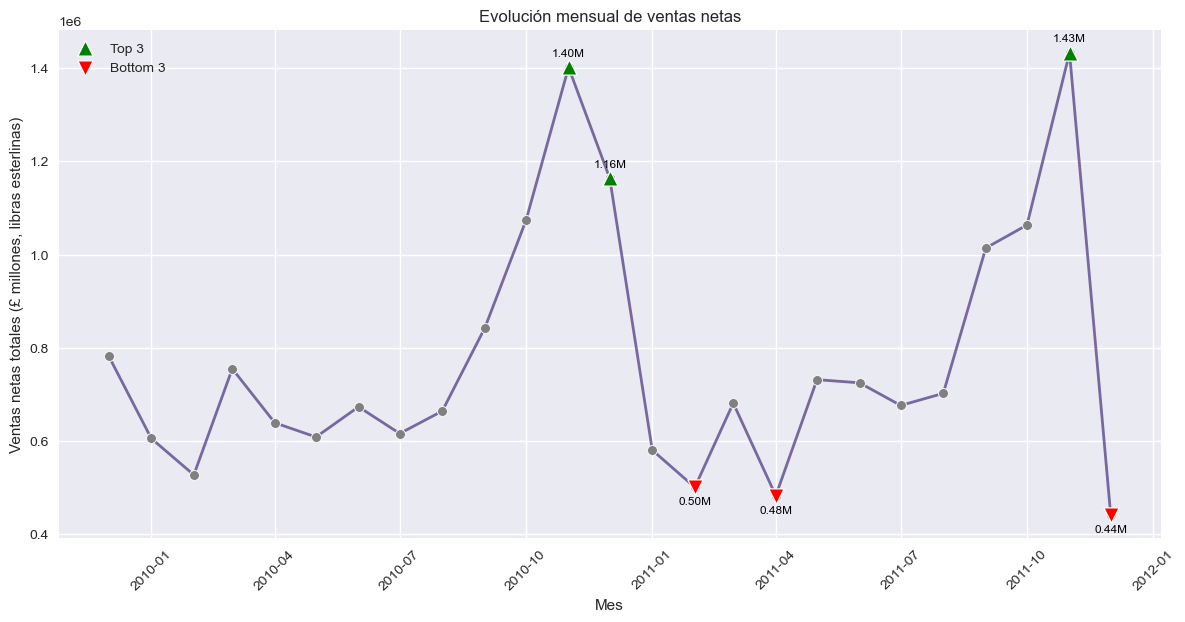

In [20]:
# Convertir valores a float
try:
    nsales_by_month['Total Net Sales'] = nsales_by_month['Total Net Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Convertir meses a formato datetime
nsales_by_month['Period'] = pd.to_datetime(nsales_by_month['Period'], format='%Y-%m-%d')

# Seleccionar los 3 meses con mayores y menores ventas netas
top3_nsales= nsales_by_month.nlargest(3, 'Total Net Sales')
bottom3_nsales= nsales_by_month.nsmallest(3, 'Total Net Sales')

# Validar integridad
df_check(nsales_by_month, col_num='Total Net Sales', col_date='Period', negative=True)

# Crear gráfico lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=nsales_by_month,
    x='Period',
    y='Total Net Sales',
    marker='o',
    color='C0',
    linewidth=2,
    alpha=0.7,
    zorder=1
)

# Dibujar puntos normales
sns.scatterplot(
    data=nsales_by_month, x='Period', y='Total Net Sales', color='gray', s=50, ax=ax, zorder=2
)

# Dibujar puntos Top 3
sns.scatterplot(
    data=top3_nsales, x='Period', y='Total Net Sales', color='green', s=120, marker='^', label='Top 3', ax=ax, zorder=5
)

# Dibujar puntos Bottom 3
sns.scatterplot(
    data=bottom3_nsales, x='Period', y='Total Net Sales', color='red', s=120, marker='v', label='Bottom 3', ax=ax, zorder=5
)

# Agregar etiquetas de datos para Top 3
for i, row in top3_nsales.iterrows():
    date = row['Period']
    value = row['Total Net Sales']
    ax.text(date, value+20000, f'{value/1e6:.2f}M',
            va='bottom', ha='center', fontsize=8.5, color='black')

# Agregar etiquetas de datos para Bottom 3
for i, row in bottom3_nsales.iterrows():
    date = row['Period']
    value = row['Total Net Sales']
    ax.text(date, value-20000, f'{value/1e6:.2f}M',
            va='top', ha='center', fontsize=8.5, color='black')

# Personalizar formato de gráfico
plt.title('Evolución mensual de ventas netas')
plt.xlabel('Mes')
plt.ylabel('Ventas netas totales (£ millones, libras esterlinas)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

No hay mucha diferencia en con respecto a las ventas brutas, con la excepción que en **diciembre del 2011** se alcanza el mes con el **volumen más bajo** de ventas netas, debido a las **devoluciones**.

#### 5.3. Comparativo ventas

Para realizar la **comparación** entre la evolución de las ventas brutas y netas sigo el mismo procedimiento que en los casos anteriores, pero para poder **visualizar la diferencia** entre ambos gráficos, utilizo un *fill between* que **sombrea** el espacio entre ambas líneas.

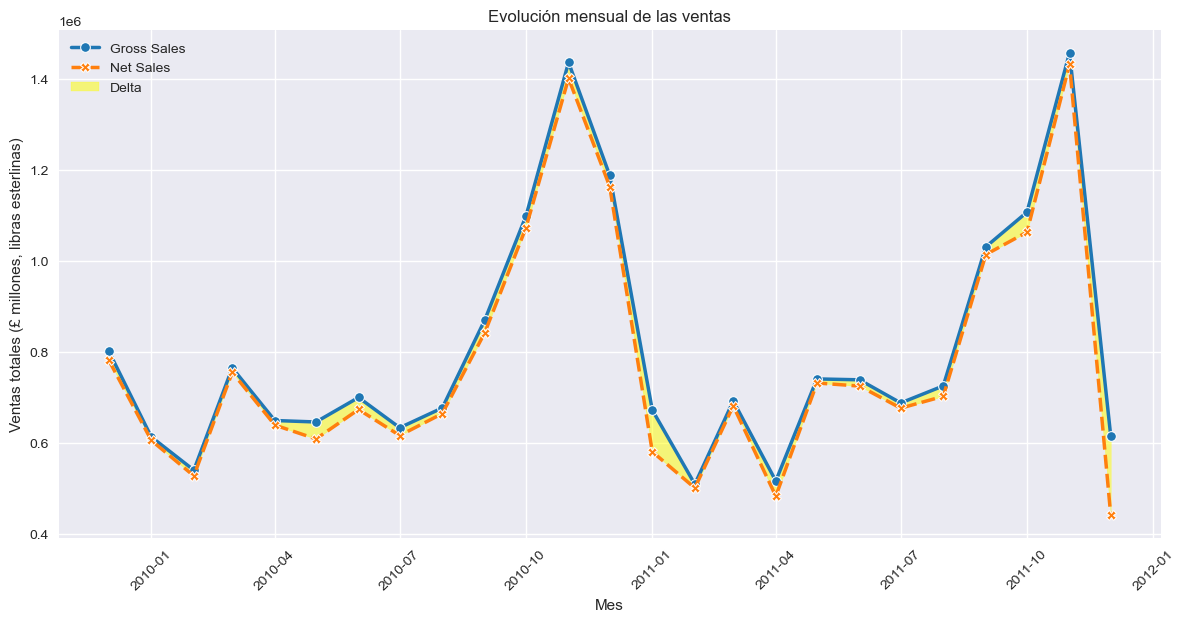

In [21]:
# Copiar DataFrames originales para transformación
gsales = gsales_by_month.copy()
nsales = nsales_by_month.copy()

# Unir ventas netas y brutas por producto y renombrar columnas
merged_sales = pd.merge(nsales, gsales, on='Period', how='inner')
merged_sales = merged_sales.rename(columns={
    'Total Gross Sales': 'Gross Sales',
    'Total Net Sales': 'Net Sales'
})

# Crear DataFrame con formato largo
sales = merged_sales.melt(
    id_vars='Period',
    value_vars=['Gross Sales', 'Net Sales'],
    var_name='Type',
    value_name='Total Sales'
)

# Convertir valores a float
try:
    sales['Total Sales'] = sales['Total Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validar integridad
df_check(sales, col_num='Total Sales', col_text='Type', col_date='Period', negative=True)

# Crear gráfico lineplot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=sales,
    x='Period',
    y='Total Sales',
    hue='Type',
    style='Type',
    markers=True,
    linewidth=2.5,
    palette=['#1f77b4', '#ff7f0e']
)

# Sombrear el área de diferencia
plt.fill_between(
    merged_sales['Period'],
    merged_sales['Gross Sales'],
    merged_sales['Net Sales'],
    where=(merged_sales['Gross Sales'] > merged_sales['Net Sales']),
    interpolate=True,
    color='yellow',
    alpha=0.5,
    label='Delta'
)

# Personalizar formato de gráfico
plt.title('Evolución mensual de las ventas')
plt.xlabel('Mes')
plt.ylabel('Ventas totales (£ millones, libras esterlinas)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

En este gráfico comparativo se puede apreciar que tanto las ventas brutas como netas siguen **patrones estacionales** y que las devoluciones no están fuera de control ni alteran considerablemente el gráfico, sin embargo el sombreado deja en evidencia algunos meses en los cuales el **volumen de retornos** es más grande que en otros meses. Sería ideal revisar si se trata de un **comportamiento estacional** o quizás algún **problema logístico**.

---
### 6. Pregunta 4: ¿Quiénes son los clientes que más compran?

#### 6.1. Ventas brutas

En esta sección, sigo el procedimiento aplicado en las anteriores. Obtengo la **tabla general** de venta bruta total por cliente (que será necesaria luego para el **comparativo** entre ventas brutas y netas) y transformo la copia para mostrar los 10 primeros **clientes** con mayor volumen de **venta bruta total**. Finalmente los resultados son mostrados en un *barplot* horizontal.

In [22]:
# Obtener clientes por ventas brutas y su porcentaje respecto al total
query = """
SELECT "Customer Label" AS "Customer",
    SUM("LineTotal") AS "Total Gross Sales",
    ROUND(100.0 * SUM("LineTotal") / (
        SELECT SUM("LineTotal")
        FROM retail
        ), 2) AS "Percentage of Total"
FROM retail
WHERE "Quantity" > 0
GROUP BY "Customer"
ORDER BY "Total Gross Sales" DESC;
"""

# Convertir consulta a DataFrame
customers_gsales = pd.read_sql_query(query, engine)

# Copiar DataFrame y mostrar los 10 primeros
top_customers_gsales = customers_gsales.head(10).copy()

# Formatear columnas y mostrar resultados
top_customers_gsales['Total Gross Sales'] = top_customers_gsales['Total Gross Sales'].map('{:,.0f}'.format)
top_customers_gsales['Percentage of Total'] = top_customers_gsales['Percentage of Total'].map('{:,.2f} %'.format)
display(top_customers_gsales)

Customer Total Gross Sales Percentage of Total
0  unknown         2,674,191             13.80 %
1  18102.0           608,822              3.14 %
2  14646.0           526,752              2.72 %
3  14156.0           305,229              1.57 %
4  14911.0           284,030              1.47 %
5  17450.0           246,973              1.27 %
6  13694.0           196,483              1.01 %
7  17511.0           175,604              0.91 %
8  16446.0           168,472              0.87 %
9  16684.0           147,143              0.76 %

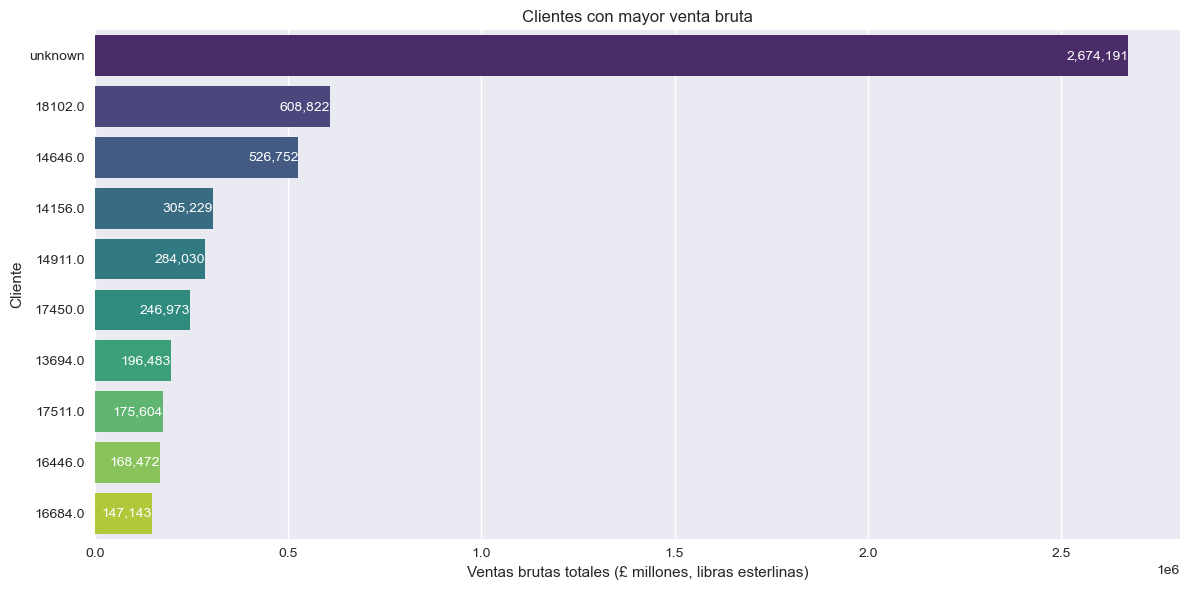

In [23]:
# Convertir valores a float
try:
    top_customers_gsales['Total Gross Sales'] = top_customers_gsales['Total Gross Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validar integridad
df_check(top_customers_gsales, col_num='Total Gross Sales', col_text='Customer', negative=False)

# Crear gráfico barplot
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=top_customers_gsales,
    x='Total Gross Sales',
    y='Customer',
    hue='Customer',
    palette='viridis',
    legend=False
)

# Agregar etiquetas de datos
for i, value in enumerate(top_customers_gsales['Total Gross Sales']):
    ax.text(value - 1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Personalizar formato de gráfico
plt.title('Clientes con mayor venta bruta')
plt.xlabel('Ventas brutas totales (£ millones, libras esterlinas)')
plt.ylabel('Cliente')
plt.tight_layout()
plt.show()

El gráfico muestra una realidad **importante**, existen más de 2.6 millones de libras esterlinas (13.80% de la venta bruta total) que no están asignados a ningún cliente. El cliente ***unknown*** es el que más compra, seguido por el cliente con código ***18102*** con una diferencia considerable de más de **2 millones de diferencia** entre ambas posiciones.

Debido a que una **gran cantidad** de las ventas **no está claisficada** por código de cliente, es dificil realizar análisis de segmentación y algún otra métrica enfocada a determinar su comportamiento.

#### 6.2. Ventas netas

La consulta para ventas netas es similar a la anterior, y de igual manera los resultados son presentados en un *barplot* horizontal.

In [24]:
# Obtener clientes por ventas netas y su porcentaje respecto al total
query = """
SELECT "Customer Label" AS "Customer",
    SUM("LineTotal") AS "Total Net Sales",
    ROUND(100.0 * SUM("LineTotal") / (
        SELECT SUM("LineTotal")
        FROM retail
        ), 2) AS "Percentage of Total"
FROM retail
GROUP BY "Customer Label"
ORDER BY "Total Net Sales" DESC;
"""

# Convertir consulta a DataFrame
customers_nsales = pd.read_sql_query(query, engine)

# Copiar DataFrame y mostrar los 10 primeros
top_customers_nsales = customers_nsales.head(10).copy()

# Formatear columnas y mostrar resultados
top_customers_nsales['Total Net Sales'] = top_customers_nsales['Total Net Sales'].map('{:,.0f}'.format)
top_customers_nsales['Percentage of Total'] = top_customers_nsales['Percentage of Total'].map('{:,.2f} %'.format)
display(top_customers_nsales)

Customer Total Net Sales Percentage of Total
0  unknown       2,667,321             13.76 %
1  18102.0         606,243              3.13 %
2  14646.0         523,203              2.70 %
3  14156.0         299,926              1.55 %
4  14911.0         270,188              1.39 %
5  17450.0         235,833              1.22 %
6  13694.0         191,196              0.99 %
7  17511.0         171,899              0.89 %
8  12415.0         143,107              0.74 %
9  16684.0         141,530              0.73 %

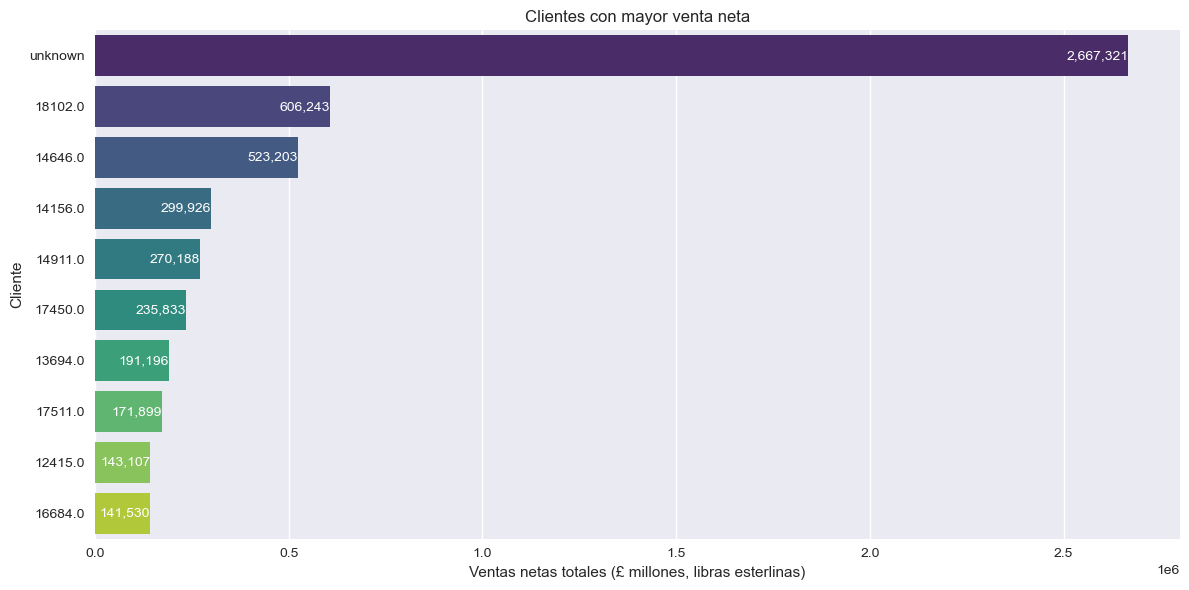

In [25]:
# Convertir valores a float
try:
    top_customers_nsales['Total Net Sales'] = top_customers_nsales['Total Net Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validar integridad
df_check(top_customers_nsales, col_num='Total Net Sales', col_text='Customer', negative=True)

# Crear gráfico barplot
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=top_customers_nsales,
    x='Total Net Sales',
    y='Customer',
    hue='Customer',
    palette='viridis',
    legend=False
)

# Agregar etiquetas de datos
for i, value in enumerate(top_customers_nsales['Total Net Sales']):
    ax.text(value - 1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Personalizar formato de gráfico
plt.title('Clientes con mayor venta neta')
plt.xlabel('Ventas netas totales (£ millones, libras esterlinas)')
plt.ylabel('Cliente')
plt.tight_layout()
plt.show()

En este gráfico no se observa mucha diferencia con respecto al gráfico de ventas brutas. Las ventas **sin código de cliente** conservan el primer lugar de la tabla y las demás posiciones **no cambian realmente**, a excepción por las dos últimas.

#### 6.3. Comparativo ventas

Para el **comparativo de ventas brutas y netas** uso la misma metodología que se viene usando en preguntas anteriores. Combino ambas tablas, realizo la transformación necesaria de los datos para la visualización correcta de los datos y finalmente grafico la comparación en un *barplot* horizontal agrupado, para poder observar la diferencia entre ambos montos.

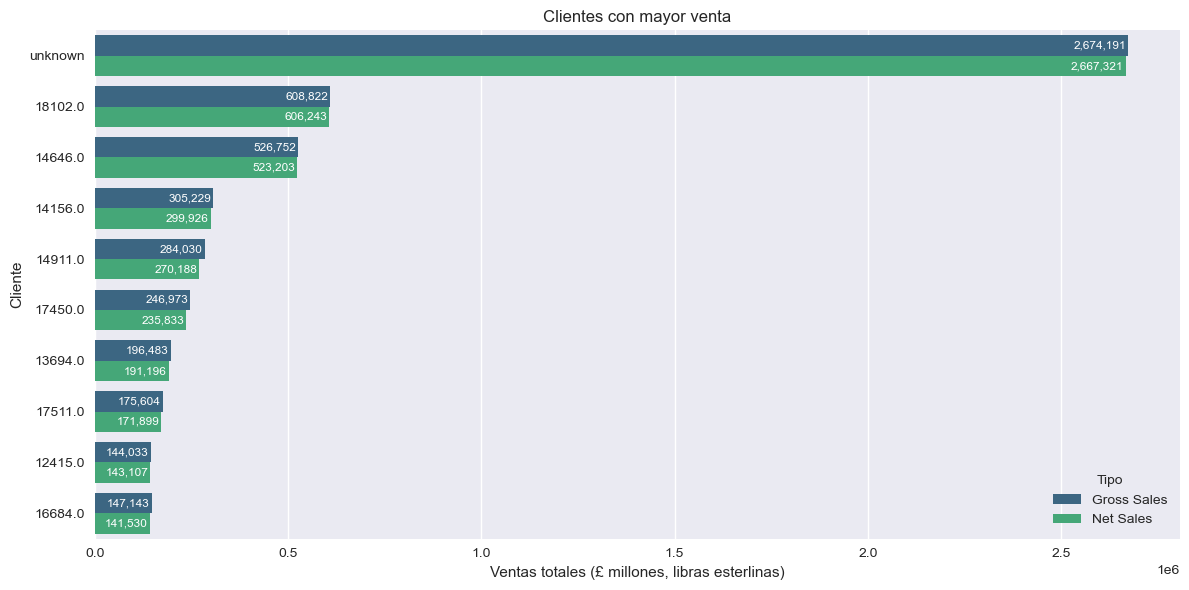

In [26]:
# Copiar DataFrames originales para transformación
cuns = customers_nsales.copy()
cugs = customers_gsales.copy()

# Unir ventas netas y brutas por producto y renombrar columnas
merged_customers = pd.merge(cuns, cugs, on='Customer', how='left')
merged_customers = merged_customers.rename(columns={
    'Total Net Sales': 'Net Sales',
    'Total Gross Sales': 'Gross Sales'
})

# Convertir valores a float
try:
    for col in ['Net Sales', 'Gross Sales']:
        merged_customers[col] = merged_customers[col].str.replace(',','').astype(float)
except AttributeError:
    pass

# Crear DataFrame con los 10 primeros y convertirlo a formato largo
top10_customers = merged_customers.sort_values(by='Net Sales', ascending=False).head(10)
top_customers_sales = top10_customers.melt(
    id_vars='Customer',
    value_vars=['Net Sales', 'Gross Sales'],
    var_name='Type',
    value_name='Total Sales'
)

# Validar integridad
df_check(top_customers_sales, col_num='Total Sales', col_text=['Customer', 'Type'], negative=True)

# Crear gráfico barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_customers_sales,
    x='Total Sales',
    y='Customer',
    hue='Type',
    hue_order=['Gross Sales', 'Net Sales'],
    palette='viridis'
)

# Agregar etiquetas de datos
for container in ax.containers:
    for bar in container:
        value=bar.get_width()
        ax.text(value-5000, bar.get_y() + bar.get_height() / 2, f'{value:=,.0f}',
            ha='right', va='center', fontsize=8.5, color='white'
        )

# Personalizar formato de gráfico
plt.title('Clientes con mayor venta')
plt.xlabel('Ventas totales (£ millones, libras esterlinas)')
plt.ylabel('Cliente')
plt.legend(title='Tipo')
plt.tight_layout()
plt.show()

Se observa que **no hay diferencias significativas** entre las ventas brutas y las ventas netas, ya que las devoluciones asociadas a cada código de cliente (incluyendo aquellas sin identificar) son mínimas.

No obstante, la presencia de un volumen considerable de ventas con la etiqueta ***unknown*** representa una limitación importante. Esta falta de identificación impide realizar análisis posteriores centrados en el comportamiento por cliente, afectando la calidad y profundidad del análisis de segmentación.

>La presencia del valor atípico ***unknown*** como el "cliente" con mayor ventas despertó mi interés por entender su **comportamiento** y averiguar si, en efecto, se trata de un error temporal, un *bug* en el sistema de ventas originado al comprar ciertos productos o desde un país específico.
>
>Por lo tanto, el resto de esta sección intentaré descubrir si existe alguna **razón específica** detrás de estos valores elevados.
>
>Las consultas se basarán en **ventas netas** para poder considerar tanto venta como devoluciones y se ordenará en relación al mismo para medir el **impacto monetario** de estos registros.

#### 6.4. Valores sin código de cliente

Como primer análisis, realizo una consulta SQL para conocer en qué **países** se registran la mayor cantidad de registros ***unknown***, así como el **volumen de ventas** que esto representa.

In [27]:
# Obtener número de facturas y ventas netas de países sin código de cliente
query = """
SELECT
    "Country",
    COUNT(DISTINCT "Invoice") AS "Number of Invoices",
    SUM("LineTotal") AS "Total Net Sales"
FROM retail
WHERE "Customer Label" LIKE 'unknown'
GROUP BY "Country"
ORDER BY "Total Net Sales" DESC;
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
unknown_country_dist = pd.read_sql_query(query, engine)
unknown_country_dist['Number of Invoices'] = unknown_country_dist['Number of Invoices'].map('{:,.0f}'.format)
unknown_country_dist['Total Net Sales'] = unknown_country_dist['Total Net Sales'].map('{:,.0f}'.format)
display(unknown_country_dist)

Country Number of Invoices Total Net Sales
0         United Kingdom              2,926       2,607,104
1                Ireland                 67          36,978
2              Hong Kong                 10          13,864
3                 France                  8           1,687
4                Bahrain                  8           1,507
5           South Africa                  1           1,435
6                Bermuda                  1           1,253
7                 Israel                  3             914
8   United Arab Emirates                  5             862
9               Portugal                  2             731
10           Switzerland                  3             646
11                Sweden                  1             274
12               Lebanon                  1             212
13               Nigeria                  1            -147

Esta tabla muestra que el país con mayor número de registros ***unknown*** es **Reino Unido**, con casi 3 mil facturas distintas. Esto representa aproximadamente **2.6 millones** de libras esterlinas en ventas netas, lo cual no es sorprendente considerando que se trata del mercado principal.

El resto del **Top 5** está conformado por Irlanda, Hong Kong, Francia y Bahréin. Sin embargo, en conjunto **no superan el 2%** del volumen de ventas asociado a ***unknown***, lo que refuerza el peso desproporcionado del Reino Unido en esta categoría.

También resulta interesante observar una **factura negativa** correspondiente a Nigeria, sin asignación a cliente. Al tratarse de una devolución aislada, su impacto monetario es mínimo, pero conviene tenerlo en cuenta, ya que podría distorsionar análisis de segmentación posteriores si no se trata adecuadamente estos casos.

El siguiente análisis trata de identificar si existía algún **producto** que destacara en términos de cantidad dentro de las facturas asociadas con la etiqueta ***unknown***, así como evaluar su **impacto en las ventas**.

In [28]:
# Obtener número de facturas y ventas netas de productos sin código de cliente
query = """
SELECT
    "Description",
    COUNT(DISTINCT "Invoice") AS "Number of Invoices",
    SUM("LineTotal") AS "Total Net Sales"
FROM retail
WHERE "Customer Label" LIKE 'unknown'
GROUP BY "Description"
ORDER BY "Total Net Sales" DESC;
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
unknown_product_dist = pd.read_sql_query(query, engine)
unknown_product_dist['Number of Invoices'] = unknown_product_dist['Number of Invoices'].map('{:,.0f}'.format)
unknown_product_dist['Total Net Sales'] = unknown_product_dist['Total Net Sales'].map('{:,.0f}'.format)
display(unknown_product_dist)

Description Number of Invoices Total Net Sales
0               REGENCY CAKESTAND 3 TIER                601          58,077
1                          PARTY BUNTING                598          45,262
2         PAPER CHAIN KIT 50'S CHRISTMAS                328          43,295
3              CHARLOTTE BAG SUKI DESIGN                551          30,865
4      HOT WATER BOTTLE TEA AND SYMPATHY                286          27,068
...                                  ...                ...             ...
4161       SET OF 4 PASTEL STACKING MUGS                  2               0
4162   PURPLE FOXGLOVE ARTIIFCIAL FLOWER                  2               0
4163      WHITE ALLIUM ARTIFICIAL FLOWER                  2              -2
4164     CANDLE IN JAR COLLAGE , VANILLA                  9             -24
4165  ASSTD FRUIT+FLOWERS FRIDGE MAGNETS                  4             -66

[4166 rows x 3 columns]

La tabla de resultado muestra que existen **4,166 productos** registrados en facturas con esta etiqueta, en los que destacan los **tres primeros productos** que forman parte a su vez en el **Top 10** de productos más vendidos.

La distribución de los diferentes productos en las facturas sin asignación de clientes indica que **no se trata de algún error específico de producto**.

La siguiente consulta tiene como objetivo identificar si hubo algún **día específico** en el que se concentró un número inusualmente alto de registros sin etiqueta de cliente. El propósito es descartar la posibilidad de que el elevado volumen de facturas clasificadas como ***unknown*** se deba a un **error puntual del sistema**.

In [29]:
# Obtener número de facturas y ventas netas de productos en días con órdenes sin código de cliente
query = """
SELECT
    DATE("InvoiceDate") AS "Date of Invoice",
    COUNT(DISTINCT "Invoice") AS "Number of Invoices",
    SUM("LineTotal") AS "Total Net Sales"
FROM retail
WHERE "Customer Label" LIKE 'unknown'
GROUP BY "Date of Invoice"
ORDER BY "Total Net Sales" DESC;
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
unknown_date_dist = pd.read_sql_query(query, engine)
unknown_date_dist['Number of Invoices'] = unknown_date_dist['Number of Invoices'].map('{:,.0f}'.format)
unknown_date_dist['Total Net Sales'] = unknown_date_dist['Total Net Sales'].map('{:,.0f}'.format)
display(unknown_date_dist)

Date of Invoice Number of Invoices Total Net Sales
0        2010-11-15                  5          60,714
1        2011-11-07                  3          55,976
2        2010-12-07                 11          55,880
3        2011-11-14                  2          54,797
4        2010-11-08                  5          51,202
..              ...                ...             ...
544      2010-02-07                  1               3
545      2011-08-07                  1               2
546      2010-01-08                  1               1
547      2010-02-04                  4              -2
548      2010-01-21                  1              -8

[549 rows x 3 columns]

El resultado nos ayuda a identificar **549 días distintos** con registros sin asociar a clientes.

El análisis revela que, si bien existen días con valores ligeramente superiores al promedio, **no se detecta ningún pico extremo** que indique un fallo puntual del sistema.

El último análisis a realizar es la **evolución de las ventas sin código de cliente** a lo largo del tiempo. Para esto, la consulta en SQL devuelve la cantidad de registros con el código de cliente ***unknown*** y su respectivo valor en ventas totales.

In [30]:
# Obtener ventas netas mensuales de órdenes sin código de cliente
query = """
SELECT "Year_Month" AS "Period",
    SUM("LineTotal") AS "Total Net Sales"
FROM retail
WHERE "Customer Label" LIKE 'unknown'
GROUP BY "Period"
ORDER BY "Period" ASC;
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
unknown_ym_dist = pd.read_sql_query(query, engine)
unknown_ym_dist['Total Net Sales'] = unknown_ym_dist['Total Net Sales'].map('{:,.0f}'.format)
display(unknown_ym_dist)

Period Total Net Sales
0   2009-12-01         119,963
1   2010-01-01          78,479
2   2010-02-01          39,447
3   2010-03-01          95,663
4   2010-04-01          61,173
5   2010-05-01          50,601
6   2010-06-01          67,739
7   2010-07-01          51,481
8   2010-08-01          79,487
9   2010-09-01          63,453
10  2010-10-01          82,659
11  2010-11-01         273,462
12  2010-12-01         309,732
13  2011-01-01         107,634
14  2011-02-01          65,495
15  2011-03-01         106,106
16  2011-04-01          60,948
17  2011-05-01          80,487
18  2011-06-01          83,246
19  2011-07-01          96,037
20  2011-08-01          88,656
21  2011-09-01          89,251
22  2011-10-01         100,698
23  2011-11-01         313,124
24  2011-12-01         102,298

El grafico a presentar tendrá el mismo formato *lineplot* que el usado para visualizar la evolución de las ventas totales en el tiempo. Colocando etiquetas de datos a los **3 mayores** y a los **3 menores valores** en la serie de tiempo.

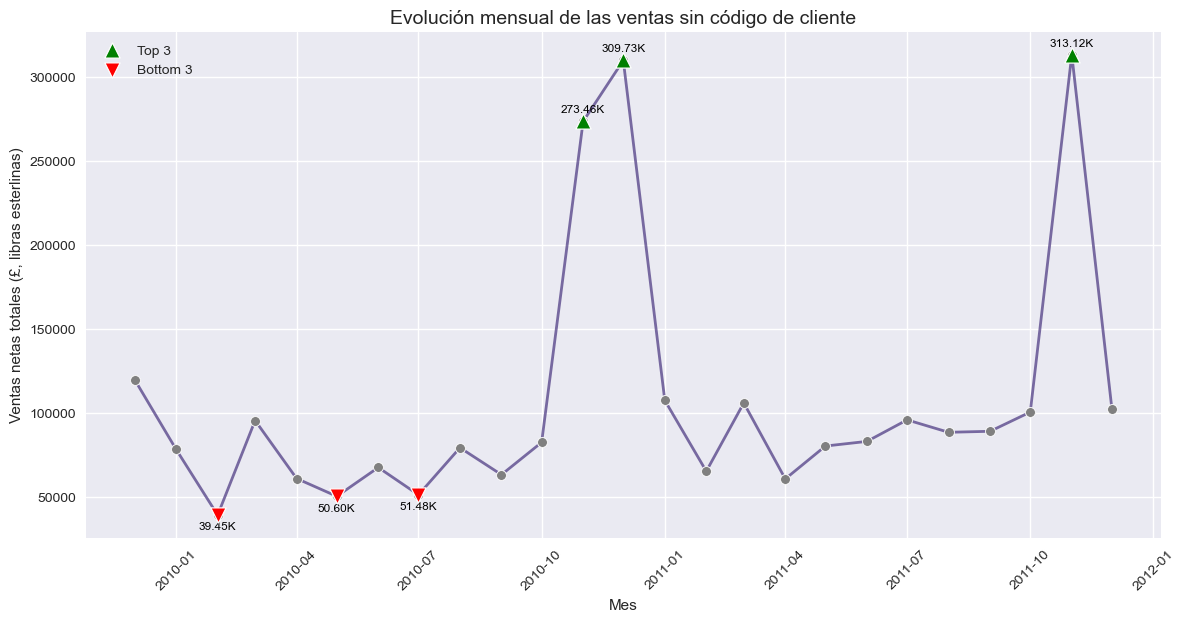

In [31]:
# Convertir valores a float
try:
    unknown_ym_dist['Total Net Sales'] = unknown_ym_dist['Total Net Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Convertir meses a formato datetime
unknown_ym_dist['Period'] = pd.to_datetime(unknown_ym_dist['Period'], format='%Y-%m-%d')

# Seleccionar los 3 meses con mayores y menores ventas brutas
top3_unknown_ym_dist = unknown_ym_dist.nlargest(3, 'Total Net Sales')
bottom3_unknown_ym_dist = unknown_ym_dist.nsmallest(3, 'Total Net Sales')

# Validar integridad
df_check(unknown_ym_dist, col_num='Total Net Sales', col_date='Period', negative=True)

# Crear gráfico lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=unknown_ym_dist,
    x='Period',
    y='Total Net Sales',
    marker='o',
    color='C0',
    linewidth=2,
    alpha=0.7,
    zorder=1
)

# Dibujar puntos normales en el gráfico
sns.scatterplot(
    data=unknown_ym_dist, x='Period', y='Total Net Sales', color='gray', s=50, ax=ax, zorder=2
)

# Dibujar puntos Top 3
sns.scatterplot(
    data=top3_unknown_ym_dist, x='Period', y='Total Net Sales', color='green', s=120, marker='^', label='Top 3', ax=ax, zorder=5
)

# Dibujar puntos Bottom 3
sns.scatterplot(
    data=bottom3_unknown_ym_dist, x='Period', y='Total Net Sales', color='red', s=120, marker='v', label='Bottom 3', ax=ax, zorder=5
)

# Agregar etiquetas de datos para Top 3
for i, row in top3_unknown_ym_dist.iterrows():
    date = row['Period']
    value = row['Total Net Sales']
    ax.text(date, value+4000, f'{value/1e3:.2f}K',
            ha='center', va='bottom', fontsize=8.5, color='black')

# Agregar etiquetas de datos para Bottom 3
for i, row in bottom3_unknown_ym_dist.iterrows():
    date = row['Period']
    value = row['Total Net Sales']
    ax.text(date, value-4000, f'{value/1e3:.2f}K',
            ha='center', va='top', fontsize=8.5, color='black')

# Personalizar formato de gráfico
plt.title('Evolución mensual de las ventas sin código de cliente', fontsize=14)
plt.xlabel('Mes')
plt.ylabel('Ventas netas totales (£, libras esterlinas)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

El gráfico sigue un patrón muy similar al de la evolución general del volumen de ventas, lo que sugiere que la **cantidad de ventas sin código de cliente también aumenta durante las temporadas altas**.

Esto refuerza la conclusión de que **no existe un error puntual** que justifique la gran cantidad de facturas sin asignación de cliente. Por lo tanto, este fenómeno podría estar relacionado con compras realizadas como **"invitado"** o con limitaciones de la plataforma para **incentivar el registro del cliente**.

---
### 7. Pregunta 5: ¿Qué porcentaje de facturas corresponden a devoluciones?

En esta sección del análisis exploratorio, realizaré una consulta SQL para conocer cuál es la **proporción entre las facturas que corresponden a ventas y devoluciones**. Tanto para Reino Unido como mercado principal, como para el resto del mundo.

Para ello, utilizo la cláusula `WITH` para crear una subconsulta que me permita contar tres elementos clave:

- `total_invoices`: el número total de facturas distintas en el dataset.
- `returns`: aquellas facturas cuyo identificador comienza con `'C'`, que indican devoluciones.
- `sales`: las demás facturas, consideradas como ventas.

Luego, mediante dos bloques `SELECT` unidos con `UNION ALL`, obtengo un resumen con el total y el porcentaje correspondiente de cada tipo de transacción.  
Este enfoque me permite comparar de forma directa el peso relativo de las devoluciones frente a las ventas.

Para la visualización, considero que un gráfico tipo *pie chart* es la alternativa más clara la presentación del resultado.

#### 7.1. Análisis general

In [32]:
# Obtener número de facturas de ventas y devoluciones y su porcentaje del total
query = """
WITH stats AS(
    SELECT
        COUNT(DISTINCT Invoice) AS total_invoices,
        COUNT(DISTINCT CASE WHEN Invoice LIKE 'C%' THEN Invoice END) AS returns,
        COUNT(DISTINCT CASE WHEN Invoice NOT LIKE 'C%' THEN Invoice END) AS sales
    FROM retail
)

SELECT 'Sales' AS "Invoice Type",
    sales AS "Quantity",
    ROUND(sales * 100.0 / total_invoices, 2) AS "Percentage"
FROM stats

UNION ALL

SELECT 'Returns' AS "Invoice Type",
    returns AS "Quantity",
    ROUND(returns * 100.0 / total_invoices, 2) AS "Percentage"
FROM stats
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
invoice_dist = pd.read_sql_query(query, engine)
invoice_dist['Quantity'] = invoice_dist['Quantity'].map('{:,.0f}'.format)
invoice_dist['Percentage'] = invoice_dist['Percentage'].map('{:,.2f} %'.format)
display(invoice_dist)

Invoice Type Quantity Percentage
0        Sales   39,496    84.21 %
1      Returns    7,405    15.79 %

Inicialmente utilicé la paleta `viridis` para el gráfico ***pie chart***, pero decidí cambiarla por `pastel` porque noté que los colores oscuros no se adaptaban bien a un pie chart con pocas categorías. Con `pastel`, los segmentos se distinguen con mayor claridad y el gráfico luce más limpio y legible.

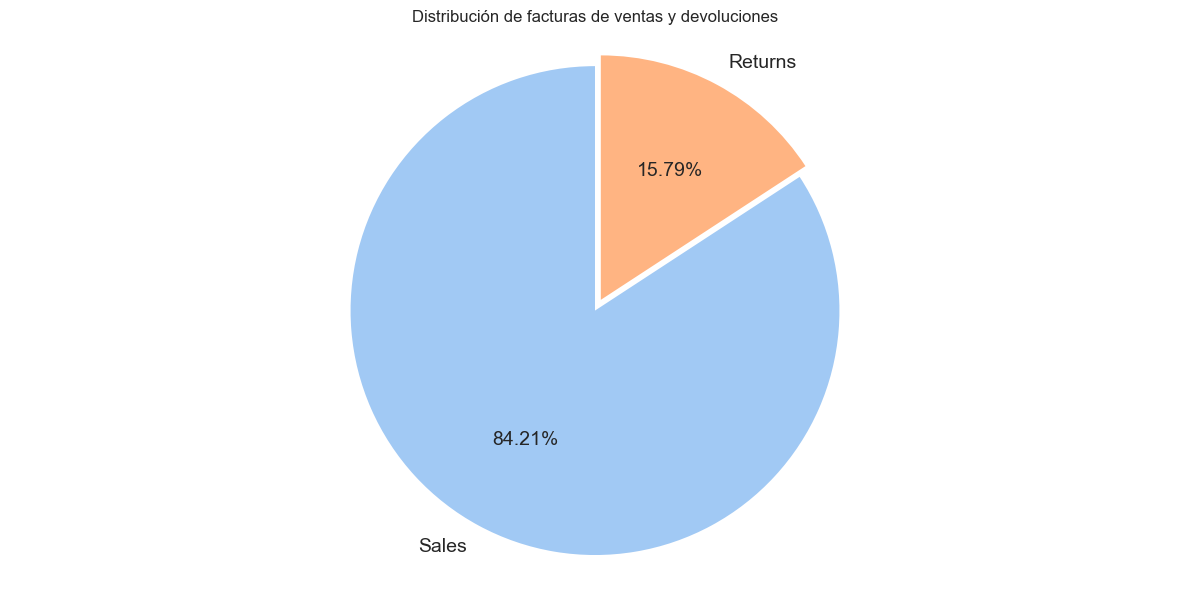

In [33]:
# Convertir valores a float
try:
    invoice_dist['Quantity'] = invoice_dist['Quantity'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validar integridad
df_check(invoice_dist, col_num='Quantity', col_text=['Invoice Type', 'Percentage'], negative=False)

# Crear pie chart (en Matplotlib)
plt.figure(figsize=(12, 6))
plt.pie(
    invoice_dist['Quantity'],
    labels=invoice_dist['Invoice Type'],
    autopct='%1.2f%%',
    colors=sns.color_palette("pastel", len(invoice_dist)),
    startangle=90,
    explode=(0, 0.05),
    textprops={'fontsize': 14}
)

# Personalizar formato de gráfico
plt.title('Distribución de facturas de ventas y devoluciones')
plt.axis('equal')
plt.tight_layout()
plt.show()

El resultado indica que aproximadamente el **15.79%** de las facturas corresponde a **devoluciones**, mientras que el **84.21%** representa **ventas efectivas**. Este valor, aunque significativo, se encuentra **por debajo del promedio general de la industria del e-commerce**, que se estima alrededor del **20%** según [Outvio (2024)](https://outvio.com/blog/return-rate-stats/).

Este nivel de devoluciones puede considerarse razonable dependiendo del tipo de producto y canal de venta, aunque también representa una oportunidad para mejorar la experiencia de compra, reducir errores logísticos o fortalecer la comunicación sobre los productos.

#### 7.2. Resultados en el Reino Unido

In [34]:
# Obtener número de facturas de ventas y devoluciones en Reino Unido y su porcentaje del total
query = """
WITH stats AS(
    SELECT
        COUNT(DISTINCT Invoice) AS total_invoices,
        COUNT(DISTINCT CASE WHEN Invoice LIKE 'C%' THEN Invoice END) AS returns,
        COUNT(DISTINCT CASE WHEN Invoice NOT LIKE 'C%' THEN Invoice END) AS sales
    FROM retail
    WHERE "Country" = "United Kingdom"
)

SELECT 'Sales' AS "Invoice Type",
    sales AS "Quantity",
    ROUND(sales * 100.0 / total_invoices, 2) AS "Percentage"
FROM stats

UNION ALL

SELECT 'Returns' AS "Invoice Type",
    returns AS "Quantity",
    ROUND(returns * 100.0 / total_invoices, 2) AS "Percentage"
FROM stats;
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
uk_invoice_dist = pd.read_sql_query(query, engine)
uk_invoice_dist['Quantity'] = uk_invoice_dist['Quantity'].map('{:,.0f}'.format)
uk_invoice_dist['Percentage'] = uk_invoice_dist['Percentage'].map('{:,.2f} %'.format)
display(uk_invoice_dist)

Invoice Type Quantity Percentage
0        Sales   36,184    84.58 %
1      Returns    6,597    15.42 %

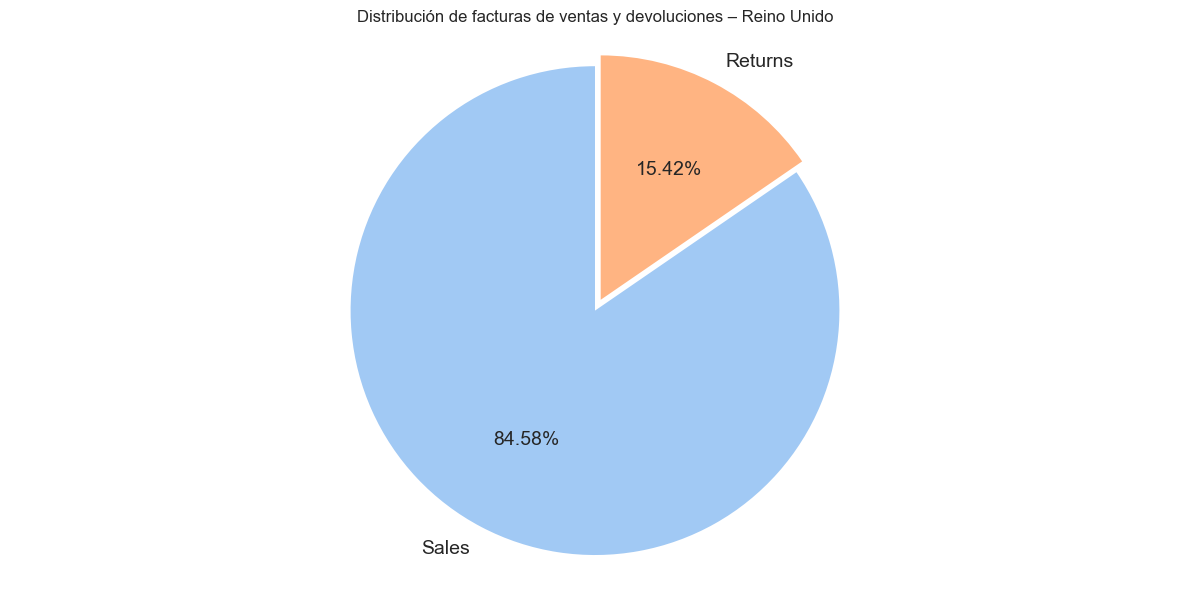

In [35]:
# Convertir valores a float
try:
    uk_invoice_dist['Quantity'] = uk_invoice_dist['Quantity'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validar integridad
df_check(uk_invoice_dist, col_num='Quantity', col_text=['Invoice Type', 'Percentage'], negative=False)

# Crear pie chart
plt.figure(figsize=(12, 6))
plt.pie(
    uk_invoice_dist['Quantity'],
    labels=uk_invoice_dist['Invoice Type'],
    autopct='%1.2f%%',
    colors=sns.color_palette("pastel", len(invoice_dist)),
    startangle=90,
    explode=(0, 0.05),
    textprops={'fontsize': 14}
)

# Personalizar formato de gráfico
plt.title('Distribución de facturas de ventas y devoluciones – Reino Unido')
plt.axis('equal')
plt.tight_layout()
plt.show()

El gráfico no cambia mucho en el caso de **Reino Unido**, siendo las devoluciones un **15.42%** del total de transacciones en el territorio británico y las ventas un **84.58%**. 

#### 7.3. Resultados en el resto del mundo

In [36]:
# Obtener número de facturas de ventas y devoluciones en el resto del mundo y su porcentaje del total
query = """
WITH stats AS(
    SELECT
        COUNT(DISTINCT Invoice) AS total_invoices,
        COUNT(DISTINCT CASE WHEN Invoice LIKE 'C%' THEN Invoice END) AS returns,
        COUNT(DISTINCT CASE WHEN Invoice NOT LIKE 'C%' THEN Invoice END) AS sales
    FROM retail
    WHERE "Country" != "United Kingdom"
)

SELECT 'Sales' AS "Invoice Type",
    sales AS "Quantity",
    ROUND(sales * 100.0 / total_invoices, 2) AS "Percentage"
FROM stats

UNION ALL

SELECT 'Returns' AS "Invoice Type",
    returns AS "Quantity",
    ROUND(returns * 100.0 / total_invoices, 2) AS "Percentage"
FROM stats;
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
rw_invoice_dist = pd.read_sql_query(query, engine)
rw_invoice_dist['Quantity'] = rw_invoice_dist['Quantity'].map('{:,.0f}'.format)
rw_invoice_dist['Percentage'] = rw_invoice_dist['Percentage'].map('{:,.2f} %'.format)
display(rw_invoice_dist)

Invoice Type Quantity Percentage
0        Sales    3,312    80.39 %
1      Returns      808    19.61 %

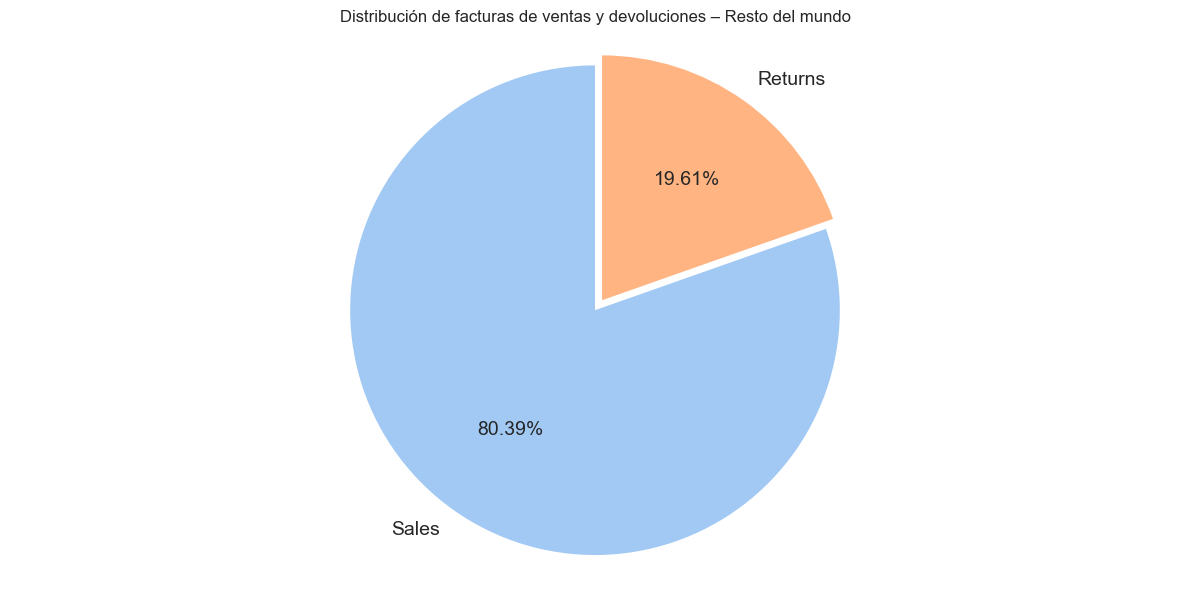

In [37]:
# Convertir valores a float
try:
    rw_invoice_dist['Quantity'] = rw_invoice_dist['Quantity'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validar integridad
df_check(rw_invoice_dist, col_num='Quantity', col_text=['Invoice Type', 'Percentage'], negative=False)

# Crear pie chart
plt.figure(figsize=(12, 6))
plt.pie(
    rw_invoice_dist['Quantity'],
    labels=rw_invoice_dist['Invoice Type'],
    autopct='%1.2f%%',
    colors=sns.color_palette("pastel", len(invoice_dist)),
    startangle=90,
    explode=(0, 0.05),
    textprops={'fontsize': 14}
)

# Personalizar formato de gráfico
plt.title('Distribución de facturas de ventas y devoluciones – Resto del mundo')
plt.axis('equal')
plt.tight_layout()
plt.show()

El resto del mundo presenta **un mayor porcentaje** con respecto a devoluciones, siendo estos un **19.61%** frente a un **80.39%** de ventas efectivas.

Este monto de devoluciones se **acerca** mucho más a los **valores promedio de la industria** de e-commerce.

---
### 8. Pregunta 6: ¿Cuál es el ticket promedio por factura?

Responder a esta pregunta es útil para entender el **valor individual de cada transacción**. Este dato puede ayudar a identificar mercados o segmentos que, sin necesariamente tener un alto volumen de compras, generan un **mayor ingreso por operación**.

#### 8.1. Ventas brutas

En este caso, parto de la base de que las facturas que comienzan con la letra *'C'* corresponden a devoluciones, por lo que **las excluyo del análisis** para obtener un ticket promedio que represente únicamente las ventas reales.

La consulta SQL calcula el número de facturas únicas, su valor en ventas brutas y el ticket promedio de cada uno, representado por el valor total sobre el número de facturas.

In [38]:
# Obtener número de facturas de ventas, venta brutas totales y ticket promedio bruto
query = """
SELECT COUNT(DISTINCT Invoice) AS "Number of Sales Invoices",
    SUM("LineTotal") AS "Total Gross Sales",
    ROUND(SUM("LineTotal") * 1.0 / COUNT(DISTINCT Invoice), 2) AS "Average Gross Ticket"
FROM retail
WHERE Invoice NOT LIKE 'C%';
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
avg_gticket = pd.read_sql_query(query, engine)
avg_gticket['Number of Sales Invoices'] = avg_gticket['Number of Sales Invoices'].map('{:,.0f}'.format)
avg_gticket['Total Gross Sales'] = avg_gticket['Total Gross Sales'].map('{:,.0f}'.format)
avg_gticket['Average Gross Ticket'] = avg_gticket['Average Gross Ticket'].map('{:,.2f}'.format)
display(avg_gticket)

Number of Sales Invoices Total Gross Sales Average Gross Ticket
0                   39,496        20,110,478               509.18

El resultado obtenido indica que, en promedio, **cada factura** representa aproximadamente **509.18** libras esterlinas en ventas, **sin considerar devoluciones**.

El siguiente paso en este análisis es identificar qué **países** tienen el **ticket promedio más alto**.

Responder esta pregunta resulta clave para detectar qué mercados generan un **mayor ingreso por factura**, lo cual puede tener implicancias tanto a nivel comercial como logístico.

In [39]:
# Obtener número de facturas de ventas, venta brutas totales y ticket promedio bruto por país
query = """
SELECT Country,
    COUNT(DISTINCT Invoice) AS "Number of Sales Invoices",
    SUM("LineTotal") AS "Total Gross Sales",
    ROUND(SUM("LineTotal") * 1.0 / COUNT(DISTINCT Invoice), 2) AS "Average Gross Ticket"
FROM retail
WHERE Invoice NOT LIKE 'C%'
GROUP BY Country
ORDER BY "Average Gross Ticket" DESC;
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
avg_gticket_countries = pd.read_sql_query(query, engine)
avg_gticket_countries['Number of Sales Invoices'] = avg_gticket_countries['Number of Sales Invoices'].map('{:,.0f}'.format)
avg_gticket_countries['Total Gross Sales'] = avg_gticket_countries['Total Gross Sales'].map('{:,.0f}'.format)
avg_gticket_countries['Average Gross Ticket'] = avg_gticket_countries['Average Gross Ticket'].map('{:,.2f}'.format)
display(avg_gticket_countries)

Country Number of Sales Invoices Total Gross Sales  \
0            Netherlands                      216           549,953   
1              Australia                       89           168,485   
2              Singapore                        8            13,158   
3                Denmark                       42            68,560   
4              Hong Kong                        9            13,875   
5               Thailand                        2             3,071   
6                  Japan                       33            47,138   
7                Bermuda                        1             1,253   
8                 Israel                       10            11,335   
9           South Africa                        3             3,369   
10           Switzerland                       85            94,270   
11             Lithuania                        6             6,554   
12               Ireland                      585           638,934   
13                Norway                       39            42,362   
14                Greece                       18            18,711   
15               Lebanon                        2             1,906   
16                Sweden                       99            86,353   
17  United Arab Emirates                       12            10,273   
18       Channel Islands                       54            44,704   
19                Brazil                        2             1,412   
20               Iceland                        8             5,633   
21                Cyprus                       35            24,614   
22                 Spain                      144            98,613   
23                 Malta                        7             4,757   
24                Canada                        7             4,332   
25              Portugal                       85            48,819   
26                 Korea                        2             1,119   
27           West Indies                        1               536   
28                France                      601           317,345   
29               Germany                      753           388,830   
30               Austria                       40            20,297   
31                 Italy                       59            29,324   
32                   USA                       16             7,920   
33        United Kingdom                   36,184        17,235,543   
34               Finland                       54            25,180   
35               Belgium                      143            57,323   
36        Czech Republic                        2               787   
37                Poland                       28            10,462   
38               Bahrain                       10             3,110   
39          Saudi Arabia                        1               146   
40               Nigeria                        1               113   

   Average Gross Ticket  
0              2,546.08  
1              1,893.09  
2              1,644.77  
3              1,632.39  
4              1,541.69  
5              1,535.27  
6              1,428.44  
7              1,253.14  
8              1,133.47  
9              1,123.01  
10             1,109.06  
11             1,092.29  
12             1,092.19  
13             1,086.22  
14             1,039.51  
15               952.79  
16               872.25  
17               856.10  
18               827.85  
19               705.94  
20               704.16  
21               703.27  
22               684.81  
23               679.62  
24               618.87  
25               574.35  
26               559.25  
27               536.41  
28               528.03  
29               516.37  
30               507.43  
31               497.01  
32               495.00  
33               476.33  
34               466.30  
35               400.86  
36               393.37  
37               373.66  
38               310

Debido a la **cantidad de datos** en el eje *'y'*, decidí que la mejor manera de mostrar los resultados es a través de un *scatterplot* resaltando con un **color diferente** aquellos que se encuentran en los **5 primeros y últimos lugares**.

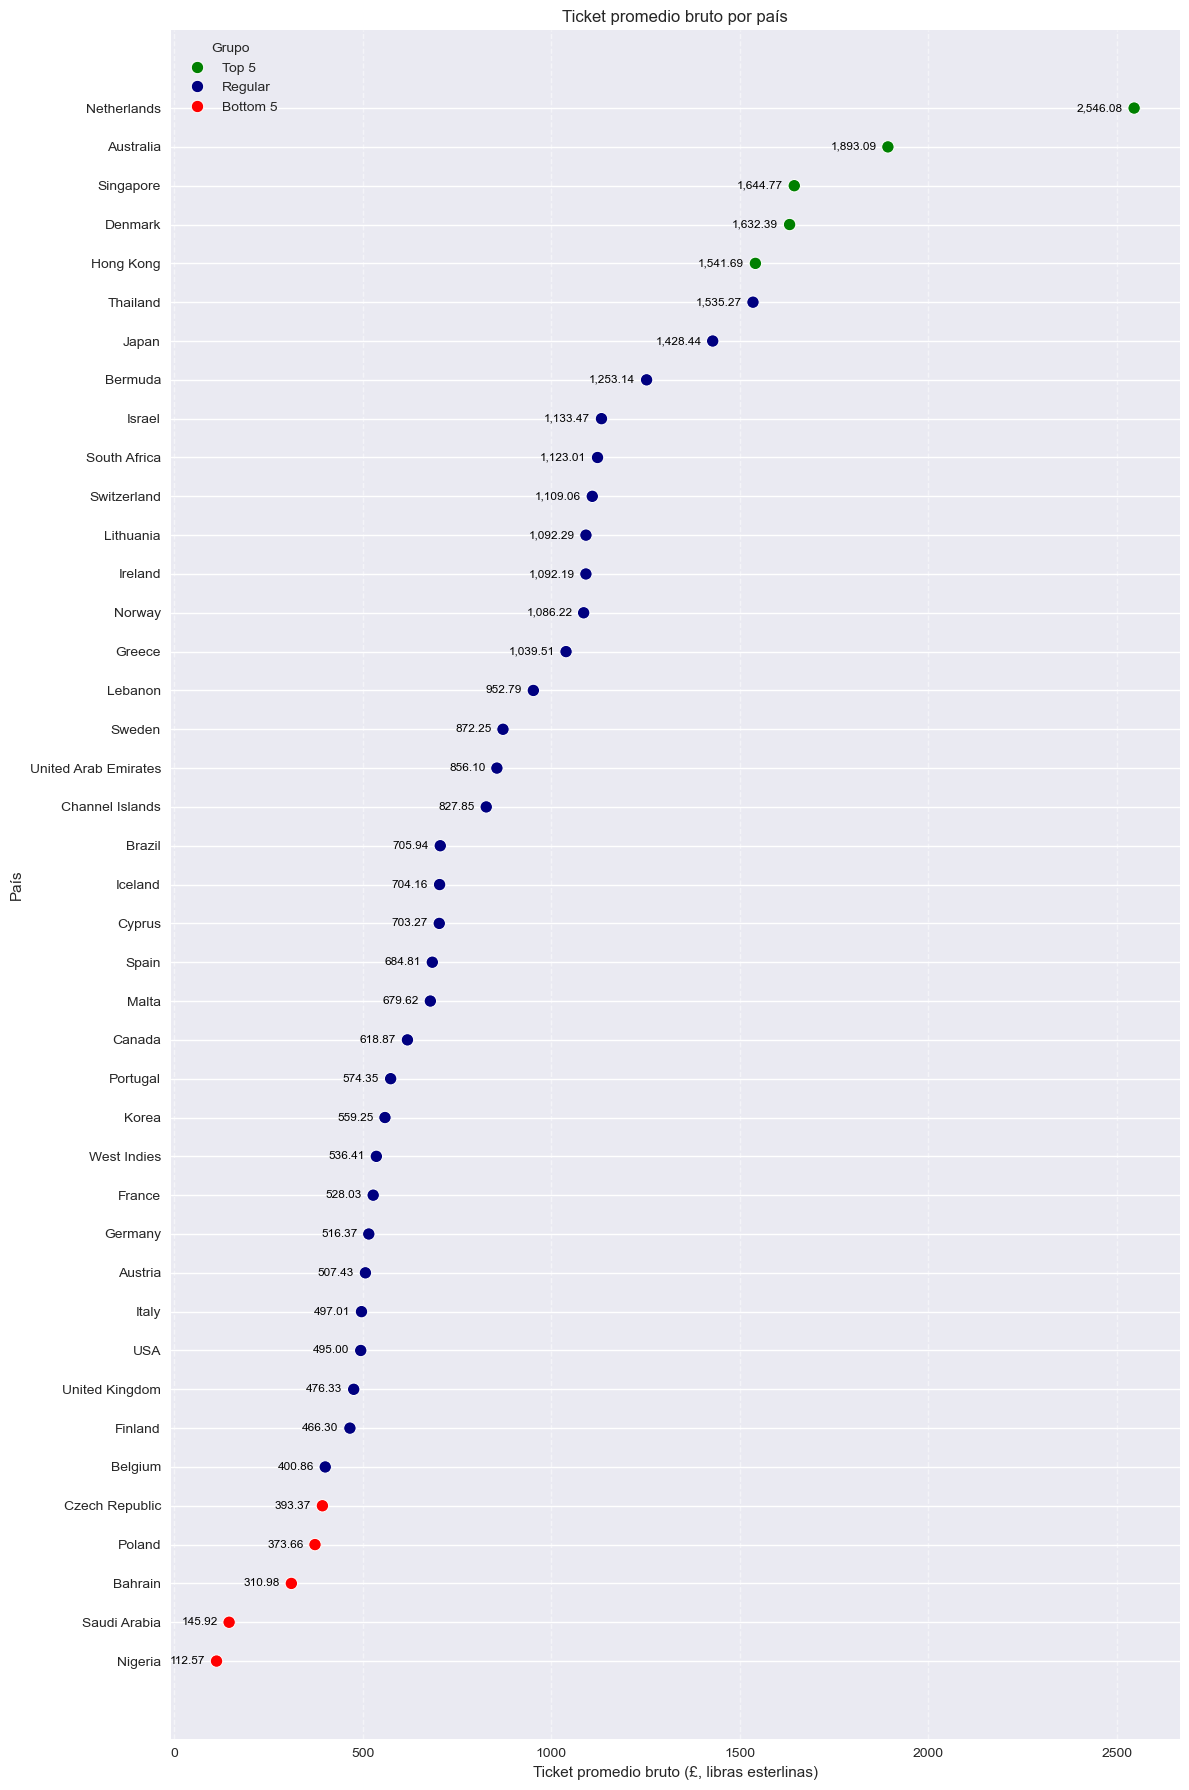

In [40]:
# Convertir valores a float
try:
    avg_gticket_countries['Average Gross Ticket'] = avg_gticket_countries['Average Gross Ticket'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Copia DataFrame original y clasificar los países por Top 5, Bottom 5 y regular
agtc = avg_gticket_countries.copy()
agtc['Group'] = 'Regular'
agtc.loc[:4, 'Group'] = 'Top 5'
agtc.loc[agtc.shape[0]-5:, 'Group'] = 'Bottom 5'

# Validar integridad
df_check(agtc, col_num='Average Gross Ticket', col_text=['Country', 'Group'], negative=False)

# Crear scatterplot y aplicar formato a los diferentes puntos
plt.figure(figsize=(12, 18))
ax = sns.scatterplot(
    data=agtc,
    x='Average Gross Ticket',
    y='Country',
    hue='Group',
    palette={'Top 5': 'green', 'Regular': 'navy', 'Bottom 5': 'red'},
    s=80
)

# Agregar etiquetas de datos
for i, value in enumerate(agtc['Average Gross Ticket']):
    ax.text(value-30, i, f'{value:,.2f}',
            ha='right', va='center', fontsize=8.5, color='black'
           )

# Personalizar formato de gráfico
plt.title('Ticket promedio bruto por país')
plt.xlabel('Ticket promedio bruto (£, libras esterlinas)')
plt.ylabel('País')
plt.legend(title='Grupo')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Como se puede observar, **Países Bajos** lidera con claridad el ranking, con un ticket promedio de aproximadamente **2,546 libras esterlinas por transacción**, superando por un amplio margen al segundo puesto, **Australia**, que registra un promedio de **1,893**.

No existe alguna diferencia más pronunciada en el resto de países, salvo por los países que ocupan los **dos últimos lugares**, sin embargo esto se podría deber a las **pocas transacciones realizadas** en estos mercados.

Para concluir el análisis de ticket promedio bruto, realizo una consulta en SQL para poder visualizar la **evolución del ticket promedio bruto en el tiempo** a través de un *lineplot*, similar al análisis de ventas.

In [41]:
# Obtener número de facturas de ventas, venta brutas totales y ticket promedio bruto por mes
query = """
SELECT Year_Month AS "Period",
    COUNT(DISTINCT Invoice) AS "Number of Sales Invoices",
    SUM("LineTotal") AS "Total Gross Sales",
    ROUND(SUM("LineTotal") * 1.0 / COUNT(DISTINCT Invoice), 2) AS "Average Gross Ticket"
FROM retail
WHERE Invoice NOT LIKE 'C%'
GROUP BY "Period";
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
avg_gticket_period = pd.read_sql_query(query, engine)
avg_gticket_period['Number of Sales Invoices'] = avg_gticket_period['Number of Sales Invoices'].map('{:,.0f}'.format)
avg_gticket_period['Total Gross Sales'] = avg_gticket_period['Total Gross Sales'].map('{:,.0f}'.format)
avg_gticket_period['Average Gross Ticket'] = avg_gticket_period['Average Gross Ticket'].map('{:,.2f}'.format)
display(avg_gticket_period)

Period Number of Sales Invoices Total Gross Sales Average Gross Ticket
0   2009-12-01                    1,666           801,603               481.15
1   2010-01-01                    1,047           612,966               585.45
2   2010-02-01                    1,189           539,945               454.12
3   2010-03-01                    1,647           764,734               464.32
4   2010-04-01                    1,434           649,091               452.64
5   2010-05-01                    1,484           645,895               435.24
6   2010-06-01                    1,612           699,766               434.10
7   2010-07-01                    1,507           633,277               420.22
8   2010-08-01                    1,402           676,711               482.68
9   2010-09-01                    1,787           870,350               487.05
10  2010-10-01                    2,244         1,098,868               489.69
11  2010-11-01                    2,717         1,436,505               528.71
12  2010-12-01                    1,551         1,188,008               765.96
13  2011-01-01                    1,081           672,133               621.77
14  2011-02-01                    1,093           509,101               465.78
15  2011-03-01                    1,440           692,008               480.56
16  2011-04-01                    1,233           516,164               418.62
17  2011-05-01                    1,666           740,558               444.51
18  2011-06-01                    1,523           738,579               484.95
19  2011-07-01                    1,447           687,707               475.26
20  2011-08-01                    1,338           725,164               541.98
21  2011-09-01                    1,818         1,030,999               567.11
22  2011-10-01                    2,005         1,107,250               552.24
23  2011-11-01                    2,749         1,457,555               530.21
24  2011-12-01                      816           615,543               754.34

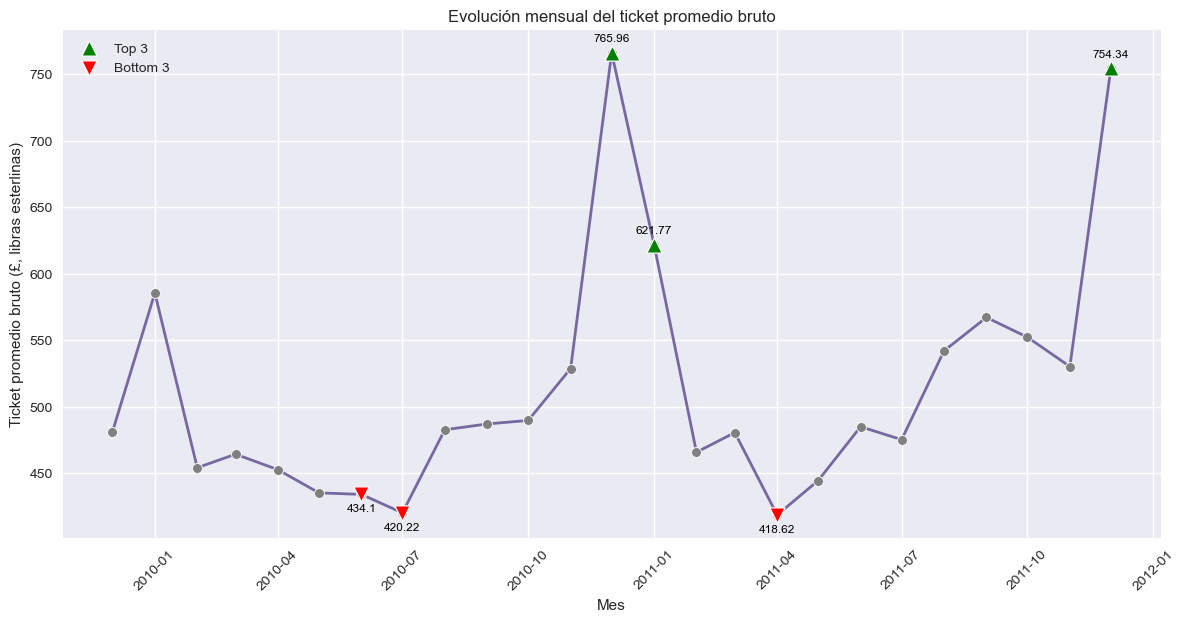

In [42]:
# Convertir valores a float
try:
    avg_gticket_period['Average Gross Ticket'] = avg_gticket_period['Average Gross Ticket'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Convertir meses a formato datetime
avg_gticket_period['Period'] = pd.to_datetime(avg_gticket_period['Period'], format='%Y-%m-%d')

# Seleccionar los 3 meses con mayores y menores ventas brutas
top3_gticket_period = avg_gticket_period.nlargest(3, 'Average Gross Ticket')
bottom3_gticket_period = avg_gticket_period.nsmallest(3, 'Average Gross Ticket')

# Validar integridad
df_check(avg_gticket_period, col_num='Average Gross Ticket', col_date='Period', negative=False)

# Crear gráfico lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=avg_gticket_period,
    x='Period',
    y='Average Gross Ticket',
    marker='o',
    color='C0',
    linewidth=2,
    alpha=0.7,
    zorder=1
)

# Dibujar puntos normales en el gráfico
sns.scatterplot(
    data=avg_gticket_period, x='Period', y='Average Gross Ticket', color='gray', s=50, ax=ax, zorder=2
)

# Dibujar puntos Top 3
sns.scatterplot(
    data=top3_gticket_period, x='Period', y='Average Gross Ticket', color='green', s=120, marker='^', label='Top 3', ax=ax, zorder=5
)

# Dibujar puntos Bottom 3
sns.scatterplot(
    data=bottom3_gticket_period, x='Period', y='Average Gross Ticket', color='red', s=120, marker='v', label='Bottom 3', ax=ax, zorder=5
)

# Agregar etiquetas de datos para Top 3
for _, row in top3_gticket_period.iterrows():
    date = row['Period']
    value = row['Average Gross Ticket']
    ax.text(date, value+7, value,
            ha='center', va='bottom', fontsize=8.5, color='black'
           )

# Agregar etiquetas de datos para Bottom 3
for _, row in bottom3_gticket_period.iterrows():
    date = row['Period']
    value = row['Average Gross Ticket']
    ax.text(date, value-7, value,
        ha='center', va='top', fontsize=8.5, color='black'
    )

# Personalizar formato de gráfico
plt.title('Evolución mensual del ticket promedio bruto')
plt.xlabel('Mes')
plt.ylabel('Ticket promedio bruto (£, libras esterlinas)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

La evolución del ticket promedio bruto **refleja un comportamiento muy similar al observado en la evolución de las ventas**, evidenciando una **estacionalidad clara**. Se observan picos marcados a **finales de año**, mientras que los valores más bajos suelen darse alrededor de **mediados de año**.

Este patrón puede estar relacionado con periodos de **alta demanda**, como **campañas navideñas**, donde no solo aumenta el volumen de ventas sino también el gasto promedio por transacción.

#### 8.2. Ventas netas

En el caso del **ticket promedio neto**, se consideran las **devoluciones**, por lo tanto, este valor refleja el ingreso promedio real que permanece en la empresa **luego de restar los retornos**.

La consulta SQL calcula el número de facturas únicas, el valor total de las ventas netas, y el ticket promedio, representado por el total dividido entre la cantidad de facturas.

In [43]:
# Obtener número de facturas de ventas, venta netas totales y ticket promedio neto por mes
query = """
SELECT COUNT(DISTINCT Invoice) AS "Number of Sales Invoices",
    SUM("LineTotal") AS "Total Net Sales",
    ROUND(SUM("LineTotal") * 1.0 / COUNT(DISTINCT Invoice), 2) AS "Average Net Ticket"
FROM retail;
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
avg_nticket = pd.read_sql_query(query, engine)
avg_nticket['Number of Sales Invoices'] = avg_nticket['Number of Sales Invoices'].map('{:,.0f}'.format)
avg_nticket['Total Net Sales'] = avg_nticket['Total Net Sales'].map('{:,.0f}'.format)
avg_nticket['Average Net Ticket'] = avg_nticket['Average Net Ticket'].map('{:,.2f}'.format)
display(avg_nticket)

Number of Sales Invoices Total Net Sales Average Net Ticket
0                   46,901      19,383,715             413.29

En promedio, cada factura representa unas **413.29 libras esterlinas** en ventas, **incluyendo devoluciones**.

Esto supone una **reducción cercana al 20 %** respecto al ticket promedio bruto, debido al impacto de las devoluciones. Este resultado es **consistente con el porcentaje de devoluciones obtenido previamente**, el cual se encuentra por debajo del promedio de la industria.

A continuación, calcularé el **ticket promedio neto por país**, siguiendo la misma lógica aplicada previamente para el ticket promedio bruto.

En este caso, **se incluyen las devoluciones**, lo que permite observar el impacto real de los retornos sobre el ingreso promedio por transacción en cada país.

In [44]:
# Obtener número de facturas de ventas, venta netas totales y ticket promedio neto por país
query = """
SELECT Country,
    COUNT(DISTINCT Invoice) AS "Number of Sales Invoices",
    SUM("LineTotal") AS "Total Net Sales",
    ROUND(SUM("LineTotal") * 1.0 / COUNT(DISTINCT Invoice), 2) AS "Average Net Ticket"
FROM retail
GROUP BY Country
ORDER BY "Average Net Ticket" DESC;
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
avg_nticket_countries = pd.read_sql_query(query, engine)
avg_nticket_countries['Number of Sales Invoices'] = avg_nticket_countries['Number of Sales Invoices'].map('{:,.0f}'.format)
avg_nticket_countries['Total Net Sales'] = avg_nticket_countries['Total Net Sales'].map('{:,.0f}'.format)
avg_nticket_countries['Average Net Ticket'] = avg_nticket_countries['Average Net Ticket'].map('{:,.2f}'.format)
display(avg_nticket_countries)

Country Number of Sales Invoices Total Net Sales  \
0            Netherlands                      227         546,275   
1              Singapore                        8          13,158   
2              Australia                      108         166,967   
3               Thailand                        2           3,071   
4              Hong Kong                       10          13,864   
5                Denmark                       50          64,493   
6                Bermuda                        1           1,253   
7           South Africa                        3           3,369   
8              Lithuania                        6           6,554   
9                 Norway                       41          42,201   
10                Israel                       11          11,107   
11               Lebanon                        2           1,906   
12                Greece                       20          18,660   
13               Ireland                      731         618,472   
14           Switzerland                      111          93,164   
15                 Japan                       53          43,861   
16                Sweden                      114          84,379   
17                Brazil                        2           1,412   
18               Iceland                        8           5,633   
19                Canada                        7           4,332   
20                Cyprus                       42          24,118   
21  United Arab Emirates                       17           9,628   
22       Channel Islands                       75          42,465   
23           West Indies                        1             536   
24                 Spain                      168          85,658   
25               Austria                       44          20,072   
26              Portugal                      106          48,189   
27                 Malta                       11           4,667   
28                France                      712         299,656   
29               Finland                       60          25,090   
30        United Kingdom                   42,781      16,593,572   
31               Germany                    1,035         379,901   
32                 Italy                       80          28,596   
33               Belgium                      172          56,928   
34                 Korea                        3             950   
35                   USA                       21           5,840   
36                Poland                       38          10,088   
37               Bahrain                       12           2,862   
38        Czech Republic                        4             672   
39          Saudi Arabia                        2             131   
40               Nigeria                        2             -34   

   Average Net Ticket  
0            2,406.50  
1            1,644.77  
2            1,545.99  
3            1,535.27  
4            1,386.43  
5            1,289.86  
6            1,253.14  
7            1,123.01  
8            1,092.29  
9            1,029.29  
10           1,009.75  
11             952.79  
12             933.02  
13             846.06  
14             839.31  
15             827.57  
16             740.17  
17             705.94  
18             704.16  
19             618.87  
20             574.23  
21             566.36  
22             566.20  
23             536.41  
24             509.87  
25             456.17  
26             454.61  
27             424.29  
28             420.86  
29             418.16  
30             387.87  
31             367.05  
32             357.45  
33             330.98  
34             316.61  
35             278.08  
36             265.48  
37             238.46  
38             167.93  
39              65.59  
40             -17.24

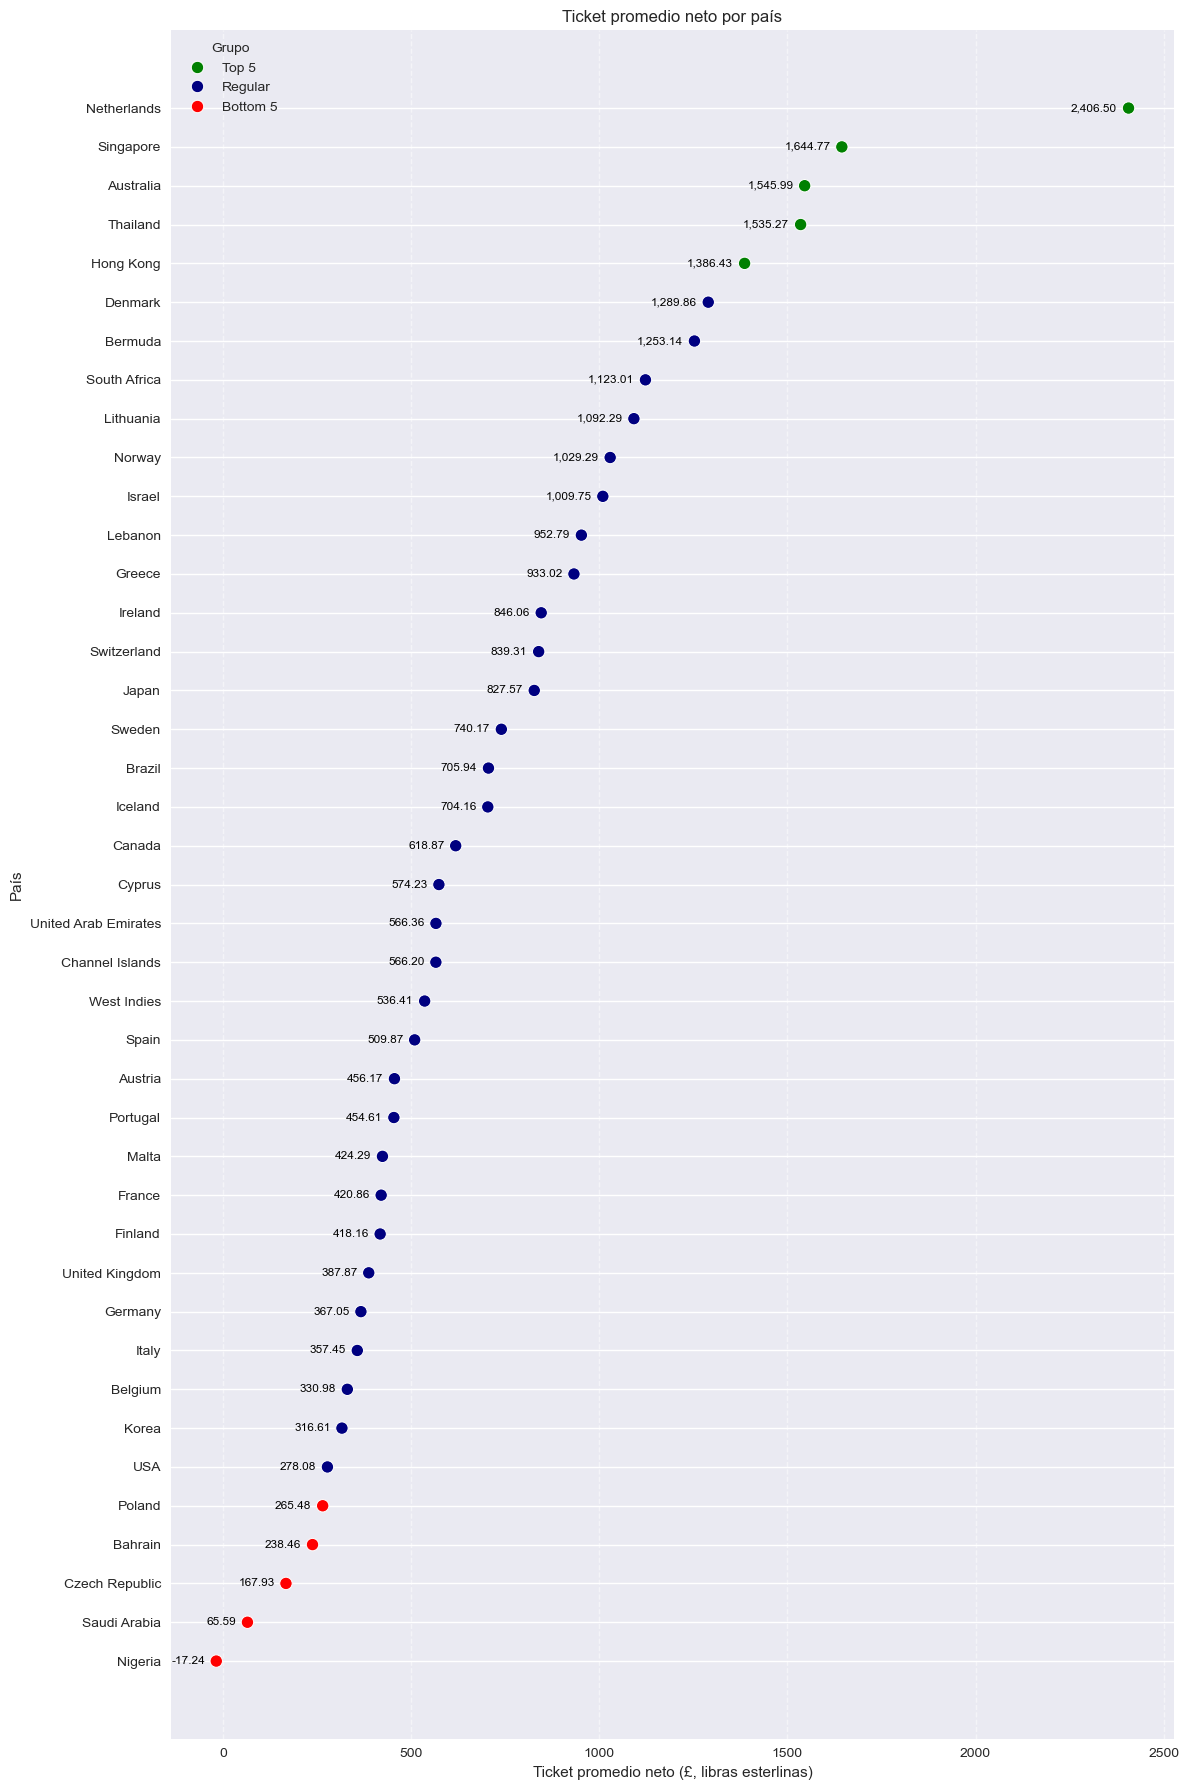

In [45]:
# Convertir valores a float
try:
    avg_nticket_countries['Average Net Ticket'] = avg_nticket_countries['Average Net Ticket'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Copia DataFrame original y clasificar los países por Top 5, Bottom 5 y regular
antc = avg_nticket_countries.copy()
antc['Group'] = 'Regular'
antc.loc[:4, 'Group'] = 'Top 5'
antc.loc[antc.shape[0]-5:, 'Group'] = 'Bottom 5'

# Validar integridad
df_check(antc, col_num='Average Net Ticket', col_text=['Country', 'Group'], negative=True)

# Crear scatterplot y aplicar formato a los diferentes puntos
plt.figure(figsize=(12, 18))
ax = sns.scatterplot(
    data=antc,
    x='Average Net Ticket',
    y='Country',
    hue='Group',
    palette={'Top 5': 'green', 'Regular': 'navy', 'Bottom 5': 'red'},
    s=80
)

# Agregar etiquetas de datos
for i, value in enumerate(antc['Average Net Ticket']):
    ax.text(value-30, i, f'{value:,.2f}',
            ha='right', va='center', fontsize=8.5, color='black')

# Personalizar formato de gráfico
plt.title('Ticket promedio neto por país')
plt.xlabel('Ticket promedio neto (£, libras esterlinas)')
plt.ylabel('País')
plt.legend(title='Grupo')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

En este gráfico, **Países Bajos** se mantiene como el **líder absoluto** con un ticket promedio de venta neto aproximado de **2,407** libras esterlinas, incluso al considerar las devoluciones.

Sin embargo, algunos países han visto **modificada su posición en el ranking** debido al impacto de los retornos. A pesar de estos cambios, **los países con los valores más bajos siguen siendo los mismos**, aunque con ligeras variaciones en el orden entre ellos.

>**Nota de actualización:**  
>Me llamó la atención que **Nigeria** tuviera un **ticket promedio neto negativo**, por lo que hice una consulta rápida para poder tener una mejor visión de como se componen sus facturas.

In [46]:
# Obtener facturas de Nigeria y su total facturado
query = """
SELECT Country, Invoice, SUM("LineTotal") AS "Total"
FROM retail
WHERE Country = 'Nigeria'
GROUP BY Invoice;
"""

# Convertir consulta a DataFrame y mostrar resultados
nigeria_ntickets = pd.read_sql_query(query, engine)
display(nigeria_ntickets)

Country  Invoice   Total
0  Nigeria   519827  112.57
1  Nigeria  C489881 -147.05

Al revisar los resultados se puede observar que la **devolución** tiene un **valor monetario absoluto mayor** a de la compra, lo que resulta en un ticket promedio neto negativo.

Finalmente, realizo la consulta para visualizar la **evolución del ticket promedio neto en el tiempo** a través de un *lineplot*, similar al análisis del ticket promedio bruto.

In [47]:
# Obtener número de facturas de ventas, venta netas totales y ticket promedio neto por mes
query = """
SELECT Year_Month AS "Period",
    COUNT(DISTINCT Invoice) AS "Number of Sales Invoices",
    SUM("LineTotal") AS "Total Net Sales",
    ROUND(SUM("LineTotal") * 1.0 / COUNT(DISTINCT Invoice), 2) AS "Average Net Ticket"
FROM retail
GROUP BY "Period";
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
avg_nticket_period = pd.read_sql_query(query, engine)
avg_nticket_period['Number of Sales Invoices'] = avg_nticket_period['Number of Sales Invoices'].map('{:,.0f}'.format)
avg_nticket_period['Total Net Sales'] = avg_nticket_period['Total Net Sales'].map('{:,.0f}'.format)
avg_nticket_period['Average Net Ticket'] = avg_nticket_period['Average Net Ticket'].map('{:,.2f}'.format)
display(avg_nticket_period)

Period Number of Sales Invoices Total Net Sales Average Net Ticket
0   2009-12-01                    2,045         782,042             382.42
1   2010-01-01                    1,288         605,500             470.11
2   2010-02-01                    1,408         527,360             374.55
3   2010-03-01                    1,999         755,027             377.70
4   2010-04-01                    1,697         639,066             376.59
5   2010-05-01                    1,871         608,601             325.28
6   2010-06-01                    1,931         673,372             348.72
7   2010-07-01                    1,821         616,144             338.35
8   2010-08-01                    1,644         664,292             404.07
9   2010-09-01                    2,105         842,582             400.28
10  2010-10-01                    2,652       1,073,243             404.69
11  2010-11-01                    3,260       1,401,345             429.86
12  2010-12-01                    1,852       1,163,537             628.26
13  2011-01-01                    1,328         580,557             437.17
14  2011-02-01                    1,284         500,725             389.97
15  2011-03-01                    1,721         681,332             395.89
16  2011-04-01                    1,453         482,847             332.31
17  2011-05-01                    1,933         731,609             378.48
18  2011-06-01                    1,821         724,812             398.03
19  2011-07-01                    1,682         676,313             402.09
20  2011-08-01                    1,578         702,235             445.02
21  2011-09-01                    2,117       1,013,954             478.96
22  2011-10-01                    2,313       1,063,258             459.69
23  2011-11-01                    3,145       1,432,544             455.50
24  2011-12-01                      953         441,417             463.19

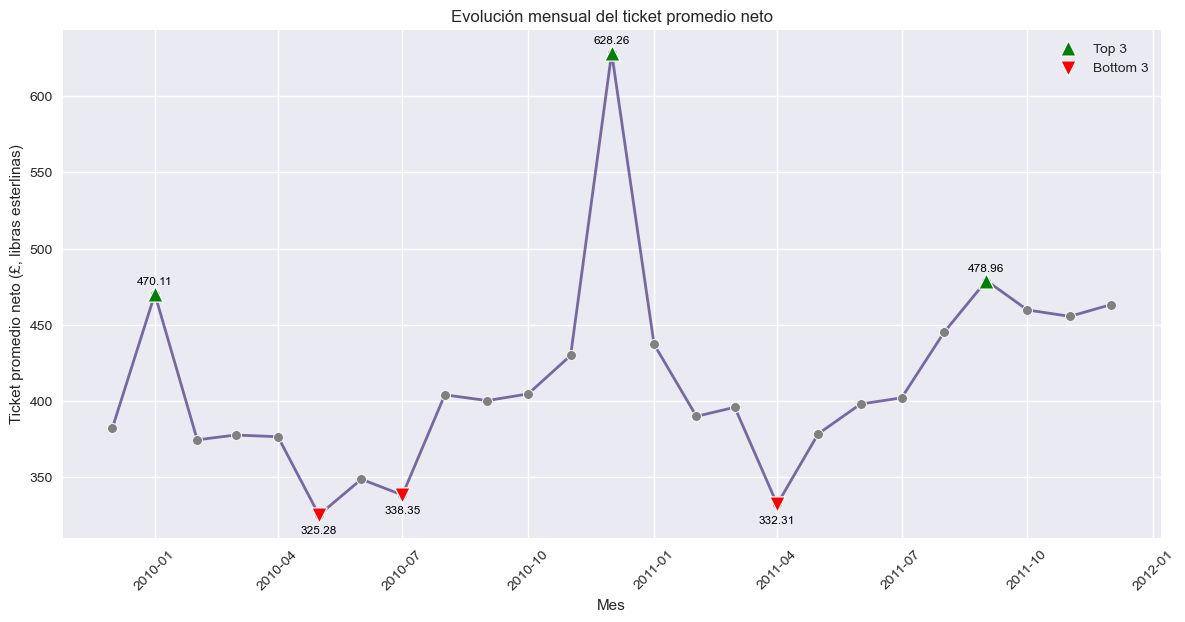

In [48]:
# Convertir valores a float
try:
    avg_nticket_period['Average Net Ticket'] = avg_nticket_period['Average Net Ticket'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Convertir meses a formato datetime
avg_nticket_period['Period'] = pd.to_datetime(avg_nticket_period['Period'], format='%Y-%m-%d')

# Seleccionar los 3 meses con mayores y menores ventas brutas
top3_nticket_period = avg_nticket_period.nlargest(3, 'Average Net Ticket')
bottom3_nticket_period = avg_nticket_period.nsmallest(3, 'Average Net Ticket')

# Validar integridad
df_check(avg_nticket_period, col_num='Average Net Ticket', col_date='Period', negative=True)

# Crear gráfico lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=avg_nticket_period,
    x='Period',
    y='Average Net Ticket',
    marker='o',
    color='C0',
    linewidth=2,
    alpha=0.7,
    zorder=1
)

# Dibujar puntos normales en el gráfico
sns.scatterplot(
    data=avg_nticket_period, x='Period', y='Average Net Ticket', color='gray', s=50, ax=ax, zorder=2
)

# Dibujar puntos Top 3
sns.scatterplot(
    data=top3_nticket_period, x='Period', y='Average Net Ticket', color='green', s=120, marker='^', label='Top 3', ax=ax, zorder=5
)

# Dibujar puntos Bottom 3
sns.scatterplot(
    data=bottom3_nticket_period, x='Period', y='Average Net Ticket', color='red', s=120, marker='v', label='Bottom 3', ax=ax, zorder=5
)

# Agregar etiquetas de datos para Top 3
for _,row in top3_nticket_period.iterrows():
    date = row['Period']
    value = row['Average Net Ticket']
    ax.text(date, value+5, value,
           ha='center', va='bottom', fontsize=8.5, color='black')

# Agregar etiquetas de datos para Bottom 3
for _,row in bottom3_nticket_period.iterrows():
    date = row['Period']
    value = row['Average Net Ticket']
    ax.text(date, value-7, value,
           ha='center', va='top', fontsize=8.5, color='black')

# Personalizar formato de gráfico
plt.title('Evolución mensual del ticket promedio neto')
plt.xlabel('Mes')
plt.ylabel('Ticket promedio neto (£, libras esterlinas)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

En este gráfico se puede apreciar algo interesante. Si bien el **primer pico** se mantiene en **diciembre del 2010**, los **siguientes picos no son tan altos**, lo que se debería a **altos volúmenes de devolución** en esas fechas o a **menores gastos promedios por transacción**.

Para cerrar esta sección, realizo un **análisis comparativo entre el ticket promedio bruto y neto** en un mismo gráfico.

De forma similar al comparativo utilizado en la evolución de las ventas, aplicaré un `fill-between` para sombrear la diferencia entre ambas métricas.  
Además, agregaré una línea adicional que me permitirá visualizar con mayor claridad la **variación absoluta entre los dos valores** a lo largo del tiempo.

#### 8.3. Comparativo ventas

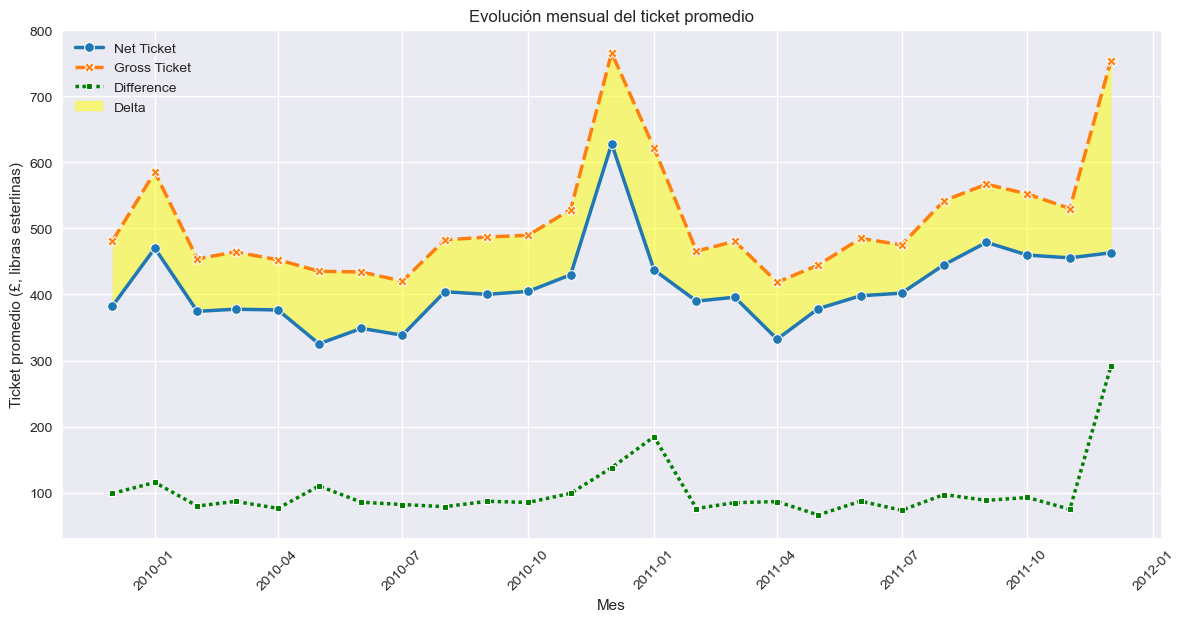

In [49]:
# Copiar DataFrames originales para transformación
antp = avg_nticket_period.copy()
agtp = avg_gticket_period.copy()

# Unir ventas netas y brutas por producto y renombrar columnas
merged_avg_ticket = pd.merge(antp, agtp, on='Period', how='inner')
merged_avg_ticket = merged_avg_ticket.rename(columns={
    'Average Net Ticket': 'Net Ticket',
    'Average Gross Ticket': 'Gross Ticket'
})

# Crear línea de diferencia entre ventas brutas y netas
merged_avg_ticket['Difference'] = merged_avg_ticket['Gross Ticket'] - merged_avg_ticket['Net Ticket']

# Convertir DataFrame a formato largo
avg_ticket = merged_avg_ticket.melt(
    id_vars = 'Period',
    value_vars = ['Net Ticket', 'Gross Ticket', 'Difference'],
    var_name = 'Type',
    value_name = 'Average Ticket'
)

# Validar integridad
df_check(avg_ticket, col_num='Average Ticket', col_text='Type', col_date='Period', negative=True)

# Crear gráfico lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=avg_ticket,
    x='Period',
    y='Average Ticket',
    hue='Type',
    style='Type',
    markers=True,
    linewidth=2.5,
    palette=['#1f77b4', '#ff7f0e', 'green']
)

# Sombrear el área de diferencia
plt.fill_between(
    merged_avg_ticket['Period'],
    merged_avg_ticket['Gross Ticket'],
    merged_avg_ticket['Net Ticket'],
    where=(merged_avg_ticket['Gross Ticket'] > merged_avg_ticket['Net Ticket']),
    interpolate=True,
    color='yellow',
    alpha=0.5,
    label='Delta'
)

# Personalizar formato de gráfico
plt.title('Evolución mensual del ticket promedio')
plt.xlabel('Mes')
plt.ylabel('Ticket promedio (£, libras esterlinas)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Se observa una diferencia notable en **enero de 2011**, probablemente asociada a un aumento significativo en las **devoluciones posteriores a la temporada navideña**. Esto hace que, pese al alto valor del ticket bruto, el valor neto disminuya de forma considerable.

Sin embargo, el punto con **mayor diferencia entre ambas métricas** ocurre en **diciembre de 2011**, lo cual podría explicarse por una combinación de factores: un **menor gasto promedio por factura** junto con un **volumen elevado de devoluciones**, lo que amplifica la brecha entre el valor bruto y el neto.

Este análisis refuerza la importancia de considerar el impacto de las devoluciones en la planificación comercial y logística, especialmente en los períodos de alta estacionalidad.

---
### 9. Pregunta 7: ¿En qué día de la semana se vende más?

En esta parte del análisis buscaré identificar **patrones temporales** en el comportamiento de las ventas, particularmente en función del **día de la semana y la hora del día**.

Trabajaré desde el mismo DataFrame sin necesidad de una consulta de SQL para poder obtener el acceso a todas las columnas necesarias para realizar el análisis.

El método de visualización será un *heatmap*, ya que nos permitirá observar con precisión la **concentración de ventas** y su valor monetario dependiendo del momento en que ocurren.

#### 9.1. Análisis de órdenes

Para el análisis de órdenes no consideraré las devoluciones, ya que mi objetivo es conocer la **cantidad de facturas reales que ingresaron**. Al tratarse de un análisis de volumen de transacciones, los retornos no resultan relevantes en este contexto.

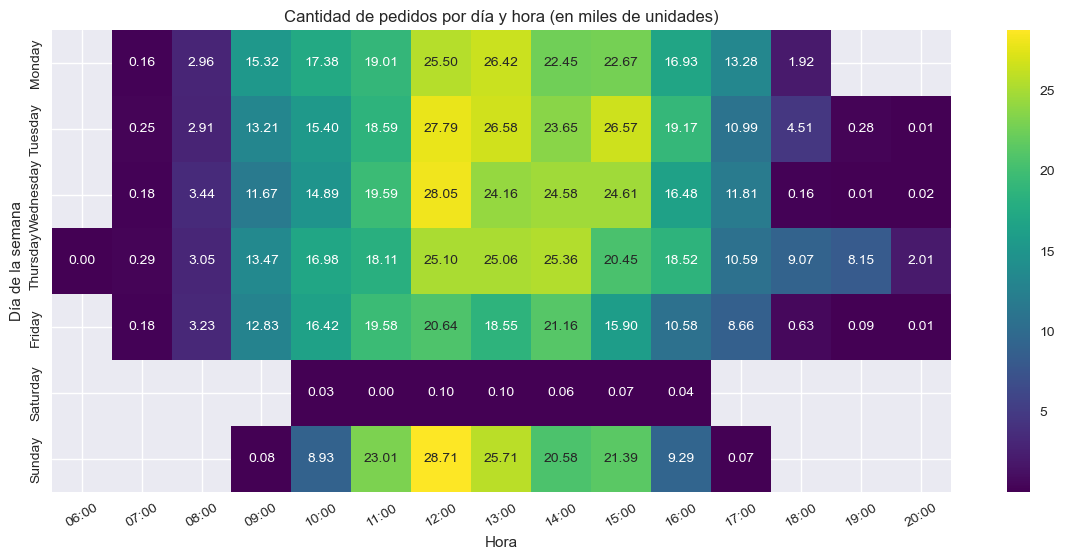

In [50]:
# Convertir valores a datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Definir orden de días de la semana y asignar como categoría ordenada
days_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Day Name'] = pd.Categorical(df['Day Name'], categories=days_week, ordered=True)

# Filtrar solo ventas (sin devoluciones) y agrupar número de facturas por día y hora para la matriz del heatmap
df_gross = df[df['Quantity'] > 0]
sales_time_heatmap = df_gross.groupby(['Day Name', 'Hour'], observed=True).size().unstack()

# Crear heatmap
plt.figure(figsize=(14.5, 6))
sns.heatmap(
    data=sales_time_heatmap / 1e3,
    cmap='viridis',
    annot=True,
    annot_kws={'size': 10},
    fmt='.2f'
)

# Personalizar formato de gráfico
plt.title('Cantidad de pedidos por día y hora (en miles de unidades)')
plt.ylabel('Día de la semana')
plt.xlabel('Hora')
plt.xticks(rotation=30)
plt.show()

El *heatmap* nos muestra que el mayor número de órdenes se registra entre las **12 p. m. y las 3 p. m.**, siendo los días con mayor volumen de pedidos **martes y miércoles**.

Esto podría deberse a que el *deadline* para recibir los pedidos en el menor tiempo posible suele estar alrededor de las 3 o 5 de la tarde. Por eso, muchos clientes deciden hacer sus órdenes a comienzos de semana, para evitar esperar más días debido a la llegada del fin de semana.

También se puede observar que el **domingo a las 12 p. m.** es uno de los rangos horarios con mayor número de pedidos. Esto probablemente se deba a que aquellos que no pudieron realizar su compra antes del fin de semana aprovechan ese momento para hacerlo y **recibir sus productos al inicio de la siguiente semana**.

#### 9.2. Análisis de venta

Para el análisis de ventas, realizo una consulta SQL con el objetivo de obtener una **tabla resumen** que me brinde un panorama general del **comportamiento por día de la semana**.

En este caso, me enfoco en tres métricas clave:

- **Cantidad de facturas**  
- **Valor total bruto** (ventas sin considerar devoluciones)  
- **Ticket bruto promedio** (promedio por factura)

In [51]:
# Obtener número de facturas, ventas brutas totales y ticket promedio bruto por día de la semana
query = """
SELECT "Day Name" AS "Day of Week",
    COUNT(DISTINCT "Invoice") AS "Number of Invoices",
    SUM("LineTotal") AS "Total Gross Order",
    SUM("LineTotal") / COUNT(DISTINCT "Invoice") AS "Average Gross Ticket"
FROM retail
WHERE "Quantity" > 0
GROUP BY "Day of Week";
"""

# Convertir consulta a DataFrame y ordenarlo por día de la semana
day_week_gsales = pd.read_sql_query(query, engine)
days_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_week_gsales['Day of Week'] = pd.Categorical(day_week_gsales['Day of Week'], categories=days_week, ordered=True)
day_week_gsales = day_week_gsales.sort_values('Day of Week')

# Formatear columnas y mostrar resultados
day_week_gsales['Number of Invoices'] = day_week_gsales['Number of Invoices'].map('{:,.0f}'.format)
day_week_gsales['Total Gross Order'] = day_week_gsales['Total Gross Order'].map('{:,.0f}'.format)
day_week_gsales['Average Gross Ticket'] = day_week_gsales['Average Gross Ticket'].map('{:,.2f}'.format)
display(day_week_gsales)

Day of Week Number of Invoices Total Gross Order Average Gross Ticket
1      Monday              6,242         3,477,586               557.13
5     Tuesday              7,144         3,968,947               555.56
6   Wednesday              7,111         3,485,289               490.13
4    Thursday              8,163         4,118,859               504.58
0      Friday              5,984         3,218,418               537.84
2    Saturday                 30             9,803               326.77
3      Sunday              4,822         1,831,577               379.84

La tabla nos muestra que el **mayor volumen de órdenes y ventas** se concentra los días **jueves** (8,163 facturas y más de 4 millones de libras esterlinas). Sin embargo, el **ticket promedio más alto** se observa el **lunes**, seguido muy de cerca por el martes. Esto podría deberse a compras de mayoristas o clientes que planifican sus pedidos al inicio de la semana.

El día **viernes** destaca por tener un volumen menor de facturas, pero con un **ticket promedio elevado** (537.69), lo que podría indicar compras de última hora o pedidos más grandes antes del fin de semana.

Los **sábados** reflejan una **actividad comercial casi nula**, con solo 30 facturas registradas. Es probable que estas ventas correspondan a **pedidos de emergencia o casos muy puntuales**, lo cual contrasta fuertemente con el resto de la semana.

Luego visualizo la diferencia a través de un *lineplot* simple con etiquetas de datos en cada valor de la semana.

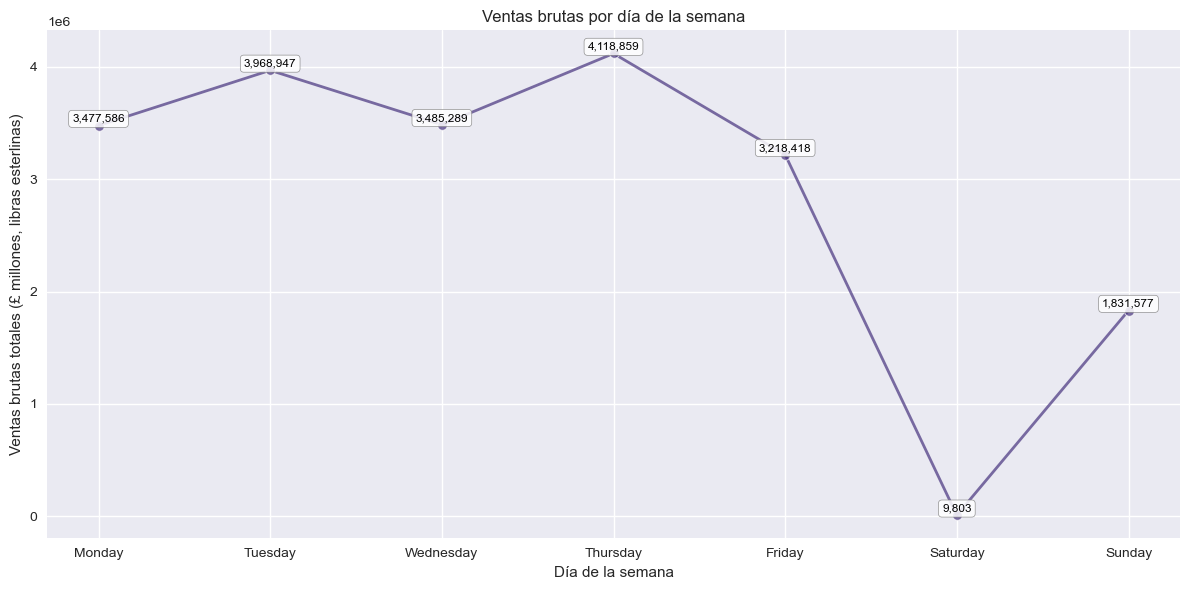

In [52]:
# Convertir valores a float
try:
    day_week_gsales['Total Gross Order'] = day_week_gsales['Total Gross Order'].str.replace(',','').astype(float)
except:
    pass

# Validar integridad
df_check(day_week_gsales, col_num='Total Gross Order', col_text='Day of Week', negative=False)

# Crear lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=day_week_gsales,
    x='Day of Week',
    y='Total Gross Order',
    marker='o',
    color='C0',
    linewidth=2,
    alpha=0.7,
    zorder=1
)

# Agregar etiquetas de datos con bbox para mejor visualización
for _, row in day_week_gsales.iterrows():
    date = row['Day of Week']
    value = row['Total Gross Order']
    ax.text(date, value + 15000, f'{value:,.0f}',
           ha='center', va='bottom', fontsize=8.5, color='black', bbox=dict(
        boxstyle='round,pad=0.3',
        facecolor='white',
        edgecolor='gray',
        linewidth=0.5,
        alpha=0.85
    ))

# Personalizar formato de gráfico
plt.title('Ventas brutas por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Ventas brutas totales (£ millones, libras esterlinas)')
plt.grid(True)
plt.tight_layout()
plt.show()

El *lineplot* muestra que el día con **mayor volumen de ventas brutas** es el **jueves**, con un total que supera los **4 millones de libras esterlinas**. En contraste, el **sábado** destaca por ser el día con **menor actividad comercial**, seguido por el **domingo**.

Dentro de los días hábiles, el **viernes** presenta el volumen de ventas más bajo, lo que podría justificarse debido a que los clientes prefieren colocar sus órdenes en los días previos.

Genero un *heatmap* para poder visualizar el **volumen de ventas por día y hora en la semana**.

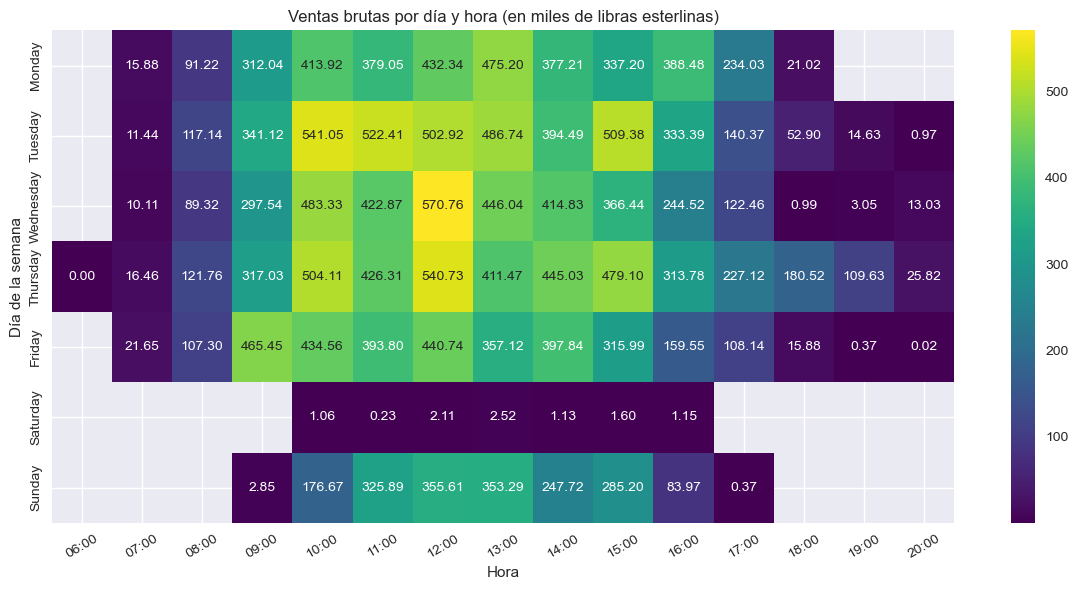

In [53]:
# Generar matriz de ventas brutas por día y hora
sales_value_heatmap = df_gross.groupby(['Day Name', 'Hour'], observed=True)['LineTotal'].sum().unstack()

# Crear heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    data=sales_value_heatmap / 1e3,
    cmap='viridis',
    annot=True,
    annot_kws={'size': 10},
    fmt='.2f'
)

# Personalizar formato de gráfico
plt.title('Ventas brutas por día y hora (en miles de libras esterlinas)')
plt.ylabel('Día de la semana')
plt.xlabel('Hora')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

El *heatmap* muestra que el **mayor valor de ventas brutas** se registra a las **12 p.m. del miércoles**, con un pico de más de **570 mil libras esterlinas** en esa franja horaria. 

También se observan otros momentos de alta actividad comercial entre las **10 a.m. y las 3 p.m.** durante los días laborables, lo que sugiere que el **horario del mediodía** es el periodo de **mayor movimiento económico**. Los días viernes se registra una mayor venta mucho más temprano.

Estos patrones podrían estar relacionados con la organización logística de los clientes, quienes aprovechan las horas centrales del día para realizar compras significativas. En contraste, los **fines de semana** presentan un volumen de ventas considerablemente menor.

Dado que se ha identificado dos **mercados principales**, **Reino Unido** y el **resto del mundo**, en esta sección analizaré las **diferencias en el comportamiento horario y semanal** de sus órdenes.

El objetivo es determinar si existen **patrones específicos** en la manera en que cada mercado realiza sus pedidos, lo cual podría tener implicancias importantes a nivel **logístico** y **comercial**. Para ello, compararé ambos segmentos en un *heatmap* por día y hora.


#### 9.3. Resultados en el Reino Unido

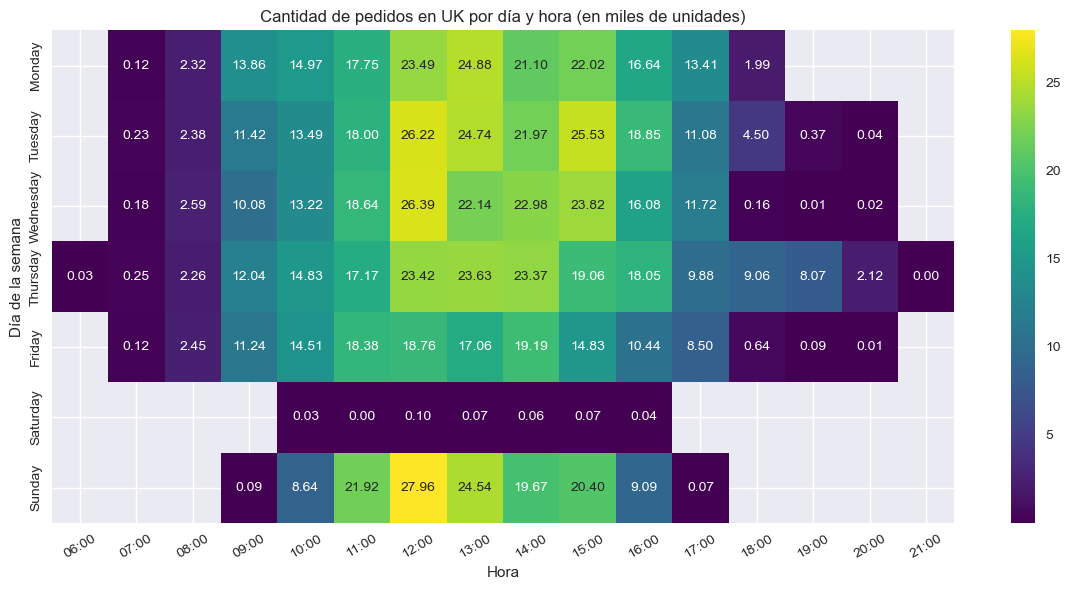

In [54]:
# Filtrar solo por ventas en el Reino Unido y agrupar número de facturas por día y hora
uk_df = df[df['Country'] == 'United Kingdom']
uk_sales_heatmap = uk_df.groupby(['Day Name', 'Hour'], observed=True).size().unstack()

# Crear heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    data=uk_sales_heatmap / 1e3,
    cmap='viridis',
    annot=True,
    annot_kws={'size': 10},
    fmt='.2f'
)

# Personalizar formato de gráfico
plt.title('Cantidad de pedidos en UK por día y hora (en miles de unidades)')
plt.ylabel('Día de la semana')
plt.xlabel('Hora')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

El comportamiento del **Reino Unido** sigue una tendencia muy similar a la observada en el *heatmap* general. La mayor actividad de órdenes se concentra durante los **primeros días de la semana**, especialmente entre las **12 p.m. y 3 p.m.**, alcanzando su punto máximo en días hábiles el **miércoles al mediodía**. A partir de ahí, la actividad comienza a disminuir gradualmente hacia el fin de semana.

Es interesante destacar que, aunque el **domingo al mediodía** presenta un pico en la **cantidad de pedidos**, esto no implica necesariamente un **mayor volumen de ventas**, como se evidenció en la visualización anterior.

#### 9.4. Resultados en el Resto del Mundo

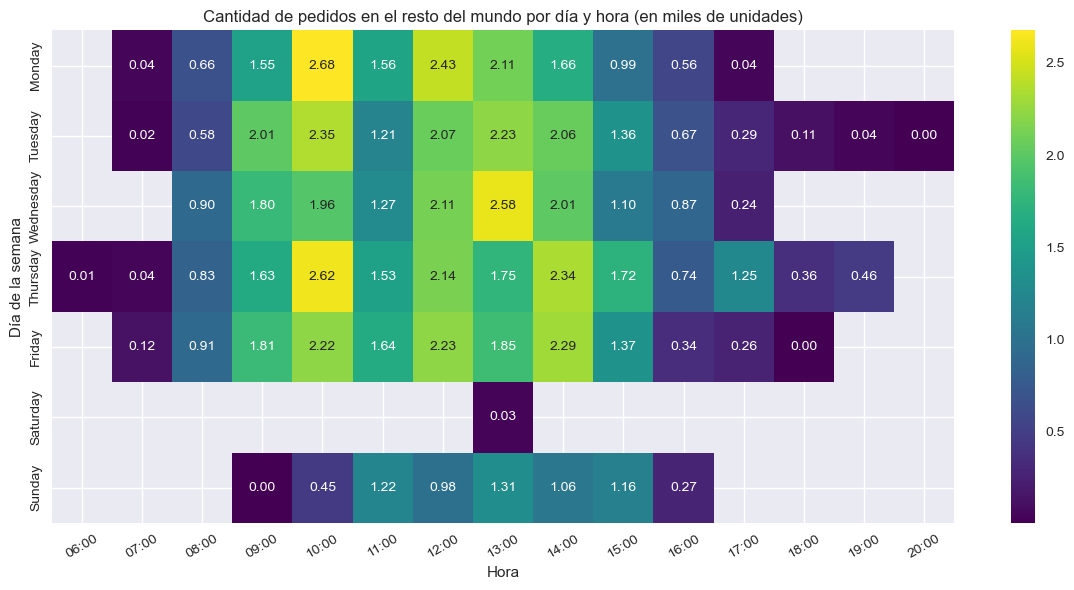

In [55]:
# Filtrar solo por ventas en el resto del mundo y agrupar número de facturas por día y hora
rw_df = df[df['Country'] != 'United Kingdom']
rw_sales_heatmap = rw_df.groupby(['Day Name', 'Hour'], observed=True).size().unstack()

# Crear heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    data=rw_sales_heatmap / 1e3,
    cmap='viridis',
    annot=True,
    annot_kws={'size': 10},
    fmt='.2f'
)

# Personalizar formato de gráfico
plt.title('Cantidad de pedidos en el resto del mundo por día y hora (en miles de unidades)')
plt.ylabel('Día de la semana')
plt.xlabel('Hora')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

El comportamiento del **resto del mundo** difiere significativamente del observado en el **Reino Unido**. Mientras que en el mercado británico el volumen de órdenes alcanza su punto máximo **al mediodía**, en el resto del mundo los **valores comienzan a ser altos desde las 10 a.m.**. Curiosamente, se observa una **disminución en la siguiente hora (11 a.m.)**, seguida de un nuevo **repunte al mediodía**, que se mantiene elevado hasta aproximadamente las **2 p.m.**

A diferencia del patrón británico, el **resto del mundo no muestra un alto volumen de órdenes los domingos**, lo que resalta una clara **diferencia de comportamiento comercial entre ambos mercados**.


---
### 10. Pregunta 8: ¿Existen patrones de ventas por temporada/mes?

Si bien anteriormente ya se había observado una **estacionalidad en la evolución de las ventas**, especialmente con **picos en noviembre y caídas a inicios de año**, en esta sección abordaré este comportamiento de manera más estructurada y explícita.

Además del análisis de las ventas para identificar patrones recurrentes, también analizaré la **evolución de las devoluciones** con el objetivo de descubrir si existe algún comportamiento estacional en los retornos de productos.

#### 10.1. Patrones de venta

La consulta SQL permite generar una **tabla resumen mensual** que muestra el número total de facturas y el valor bruto de ventas. Esta tabla servirá como base para visualizar la **evolución temporal** de las ventas y confirmar si efectivamente existe un **patrón cíclico** a lo largo del tiempo.

In [56]:
# Obtener número de facturas y venta bruta total por mes
query = """
SELECT "Year_Month" AS "Period",
    COUNT(DISTINCT "Invoice") AS "Number of Sales Invoices",
    SUM("LineTotal") AS "Total Gross Sales"
FROM retail
WHERE "Quantity" > 0
GROUP BY "Period";
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
invoices_per_month = pd.read_sql_query(query, engine)
invoices_per_month['Number of Sales Invoices'] = invoices_per_month['Number of Sales Invoices'].map('{:,}'.format)
invoices_per_month['Total Gross Sales'] = invoices_per_month['Total Gross Sales'].map('{:,.0f}'.format)
display(invoices_per_month)

Period Number of Sales Invoices Total Gross Sales
0   2009-12-01                    1,666           801,603
1   2010-01-01                    1,047           612,966
2   2010-02-01                    1,189           539,945
3   2010-03-01                    1,647           764,734
4   2010-04-01                    1,434           649,091
5   2010-05-01                    1,484           645,895
6   2010-06-01                    1,612           699,766
7   2010-07-01                    1,507           633,277
8   2010-08-01                    1,402           676,711
9   2010-09-01                    1,787           870,350
10  2010-10-01                    2,244         1,098,868
11  2010-11-01                    2,717         1,436,505
12  2010-12-01                    1,551         1,188,008
13  2011-01-01                    1,081           672,133
14  2011-02-01                    1,093           509,101
15  2011-03-01                    1,440           692,008
16  2011-04-01                    1,233           516,164
17  2011-05-01                    1,666           740,558
18  2011-06-01                    1,523           738,579
19  2011-07-01                    1,447           687,707
20  2011-08-01                    1,338           725,164
21  2011-09-01                    1,818         1,030,999
22  2011-10-01                    2,005         1,107,250
23  2011-11-01                    2,749         1,457,555
24  2011-12-01                      816           615,543

Se aprecia rápidamente en la tabla que el punto más **bajo en las ventas** se dio en **diciembre de 2011**, con tan solo **816 facturas**, un valor atípico considerando el comportamiento estacional observado en años anteriores.

Debido a esta anomalía, en la visualización siguiente añadiré una **etiqueta de dato extra** que destaque este punto, con el objetivo de compensar visualmente la ruptura en la tendencia y facilitar su interpretación.

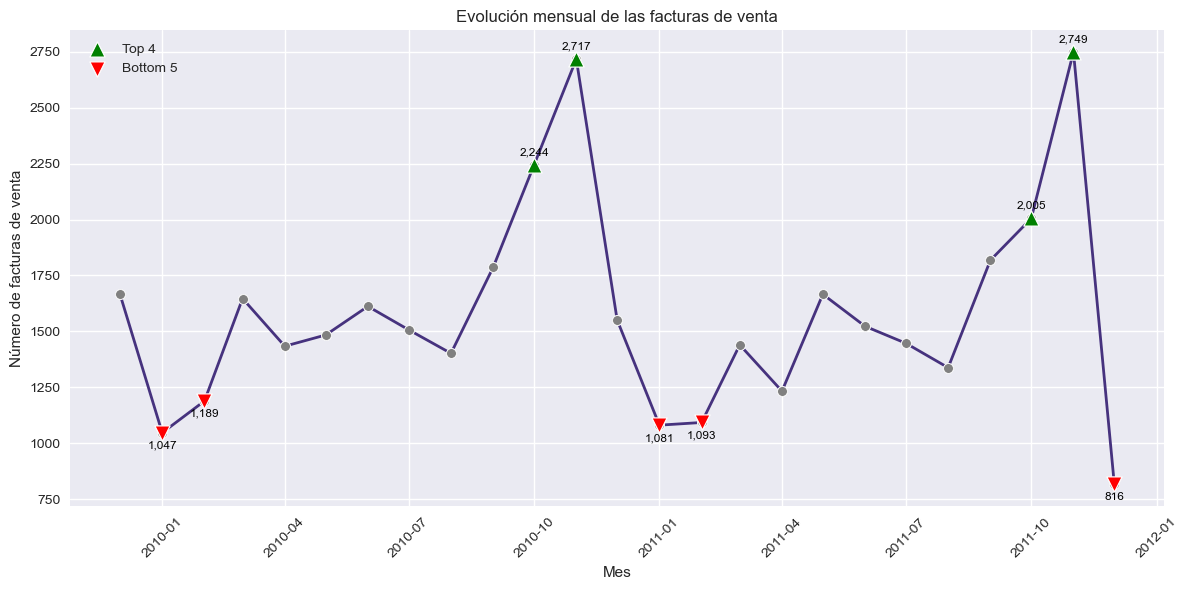

In [57]:
# Convertir valores a float
try:
    invoices_per_month['Number of Sales Invoices'] = invoices_per_month['Number of Sales Invoices'].str.replace(',','').astype(float)
    invoices_per_month['Total Gross Sales'] = invoices_per_month['Total Gross Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Convertir meses a formato datetime
invoices_per_month['Period'] = pd.to_datetime(invoices_per_month['Period'], format='%Y-%m-%d')

# Seleccionar los meses con mayores y menores números de facturas de venta
top4_ipm = invoices_per_month.nlargest(4, 'Number of Sales Invoices')
bottom5_ipm = invoices_per_month.nsmallest(5, 'Number of Sales Invoices')

# Validar integridad
df_check(invoices_per_month, col_num='Number of Sales Invoices', col_date='Period', negative=False)

# Crear gráfico lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=invoices_per_month,
    x='Period',
    y='Number of Sales Invoices',
    marker='o',
    color='C0',
    linewidth=2,
    zorder=1
)

# Dibujar puntos normales en el gráfico
sns.scatterplot(
    data=invoices_per_month, x='Period', y='Number of Sales Invoices', color='gray', s=50, ax=ax, zorder=2
)

# Dibujar puntos Top 4
sns.scatterplot(
    data=top4_ipm, x='Period', y='Number of Sales Invoices', color='green', marker='^', s=120, label='Top 4', ax=ax, zorder=5
)

# Dibujar puntos Bottom 5
sns.scatterplot(
    data=bottom5_ipm, x='Period', y='Number of Sales Invoices', color='red', marker='v', s=120, label='Bottom 5', ax=ax, zorder=5
)

# Agregar etiquetas de datos para Top 4
for _, row in top4_ipm.iterrows():
    date = row['Period']
    value = row['Number of Sales Invoices']
    ax.text(date, value+35, f'{value:,.0f}',
           ha='center', va='bottom', fontsize=8.5, color='black')

# Agregar etiquetas de datos para Bottom 5
for _, row in bottom5_ipm.iterrows():
    date = row['Period']
    value = row['Number of Sales Invoices']
    ax.text(date, value-35, f'{value:,.0f}',
            ha='center', va='top', fontsize=8.5, color='black')

# Personalizar formato de gráfico
plt.title('Evolución mensual de las facturas de venta')
plt.xlabel('Mes')
plt.ylabel('Número de facturas de venta')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Se puede observar una **tendencia recurrente de aumento en el último trimestre del año**, lo que sugiere un comportamiento típico de temporada alta en noviembre y diciembre, posiblemente vinculado a eventos como **Black Friday, compras navideñas o cierre de año fiscal**.

También se nota una **caída pronunciada en las órdenes a comienzos del año**, lo que podría explicarse por una **desaceleración natural del consumo** luego del periodo festivo. Sin embargo, resulta **llamativo** que en diciembre de 2011 se haya registrado el **valor más bajo en órdenes de todo el periodo**, rompiendo el patrón observado en los años anteriores, donde diciembre era consistentemente un mes de alto volumen. Esto podría estar relacionado con **cambios operativos, ajustes de inventario, o eventos externos** que afectaron la demanda durante ese mes.

De la misma manera, realizo una visualización para observar la **evolución de las ventas en el tiempo**, esta vez enfocándome en el **valor bruto total**.

Al igual que en el gráfico anterior, **añado una etiqueta de datos adicional** para resaltar el **valor atípico de diciembre de 2011**.

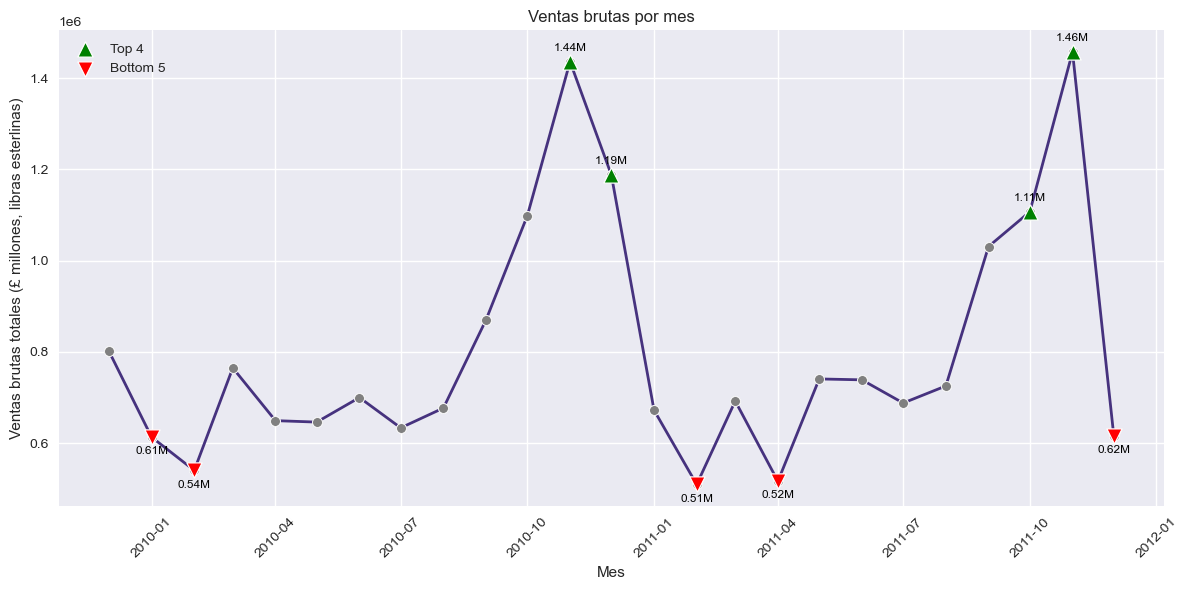

In [58]:
# Seleccionar los meses con mayores y menores ventas brutas
top4_spm = invoices_per_month.nlargest(4, 'Total Gross Sales')
bottom5_spm = invoices_per_month.nsmallest(5, 'Total Gross Sales')

# Validar integridad
df_check(invoices_per_month, col_num='Total Gross Sales', col_date='Period', negative=False)

# Crear gráfico lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=invoices_per_month,
    x='Period',
    y='Total Gross Sales',
    marker='o',
    color='C0',
    linewidth=2,
    zorder=1
)

# Dibujar puntos normales en el gráfico
sns.scatterplot(
    data=invoices_per_month, x='Period', y='Total Gross Sales', color='gray', s=50, ax=ax, zorder=2
)

# Dibujar puntos Top 4
sns.scatterplot(
    data=top4_spm, x='Period', y='Total Gross Sales', color='green', marker='^', s=120, label='Top 4', ax=ax, zorder=5
)

# Dibujar puntos Bottom 5
sns.scatterplot(
    data=bottom5_spm, x='Period', y='Total Gross Sales', color='red', marker='v', s=120, label='Bottom 5', ax=ax, zorder=5
)

# Agregar etiquetas de datos para Top 4
for _, row in top4_spm.iterrows():
    date = row['Period']
    value = row['Total Gross Sales']
    ax.text(date, value+20000, f'{value/1e6:,.2f}M',
           ha='center', va='bottom', fontsize=8.5, color='black')

# Agregar etiquetas de datos para Bottom 5
for _, row in bottom5_spm.iterrows():
    date = row['Period']
    value = row['Total Gross Sales']
    ax.text(date, value-20000, f'{value/1e6:,.2f}M',
            ha='center', va='top', fontsize=8.5, color='black')

# Personalizar formato de gráfico
plt.title('Ventas brutas por mes')
plt.xlabel('Mes')
plt.ylabel('Ventas brutas totales (£ millones, libras esterlinas)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

La evolución de las **ventas brutas por mes** sigue de cerca el patrón observado en la cantidad de órdenes, aunque con algunas diferencias interesantes.

En **2010**, el **segundo valor más alto de órdenes** se registró en **octubre**, pero en términos de **ventas brutas**, fue **diciembre** el que ocupó ese lugar. En **2011**, los **picos de órdenes y ventas coincidieron**, ocurriendo ambos en el **último trimestre**.

En el extremo opuesto, **los meses con menor actividad en 2010 fueron enero y febrero**, tanto en cantidad de órdenes como en ventas, aunque el orden cambia ligeramente entre ambas métricas. En **2011**, los **valores más bajos en órdenes** también se observaron en **enero y febrero**; sin embargo, en **ventas brutas**, **febrero** fue el **más bajo**, seguido de abril. Este comportamiento se alinea con el hecho de que **abril de 2011** presenta el **ticket promedio bruto más bajo** de toda la serie temporal.

Uno de los hallazgos **más interesantes** es **diciembre de 2011**, que, a pesar de tener la **menor cantidad de pedidos** y encontrarse entre los **meses con menores ventas brutas**, registra el **ticket promedio bruto más alto** de todo el periodo analizado. Esto podría indicar una restructuración operativa o comercial, en la que se priorizaron únicamente pedidos de alto valor, posiblemente como medida de eficiencia o por restricciones internas de capacidad.

#### 10.2. Patrones de devolución

La consulta SQL para construir la tabla de devoluciones sigue el mismo formato que la anterior, con la diferencia de que en este caso se filtran exclusivamente las facturas que comienzan con `'C'`, ya que estas representan las **devoluciones** dentro del dataset.

In [59]:
# Obtener devoluciones mensuales, su porcentaje y valor total
query = """
SELECT "Year_Month" AS "Period",
    COUNT(DISTINCT "Invoice") AS "Number of Returns",
    ROUND(100.0 * COUNT(DISTINCT "Invoice") / (
        SELECT COUNT(DISTINCT "Invoice")
        FROM retail AS r2
        WHERE r2."Quantity" > 0
          AND r2."Year_Month" = retail."Year_Month"
    ), 2) AS "Percentage of Sales Returned",
    SUM("LineTotal") AS "Total Returned Value"
FROM retail
WHERE "Invoice" LIKE 'C%'
GROUP BY "Period";
"""

# Convertir consulta a DataFrame, aplicar formato y mostrar resultados
returns_per_month = pd.read_sql_query(query, engine)
returns_per_month['Number of Returns'] = returns_per_month['Number of Returns'].map('{:,}'.format)
returns_per_month['Total Returned Value'] = returns_per_month['Total Returned Value'].map('{:,.0f}'.format)
display(returns_per_month)

Period Number of Returns  Percentage of Sales Returned  \
0   2009-12-01               379                         22.75   
1   2010-01-01               241                         23.02   
2   2010-02-01               219                         18.42   
3   2010-03-01               352                         21.37   
4   2010-04-01               263                         18.34   
5   2010-05-01               387                         26.08   
6   2010-06-01               319                         19.79   
7   2010-07-01               314                         20.84   
8   2010-08-01               242                         17.26   
9   2010-09-01               318                         17.80   
10  2010-10-01               408                         18.18   
11  2010-11-01               543                         19.99   
12  2010-12-01               301                         19.41   
13  2011-01-01               247                         22.85   
14  2011-02-01               191                         17.47   
15  2011-03-01               281                         19.51   
16  2011-04-01               220                         17.84   
17  2011-05-01               267                         16.03   
18  2011-06-01               298                         19.57   
19  2011-07-01               235                         16.24   
20  2011-08-01               240                         17.94   
21  2011-09-01               299                         16.45   
22  2011-10-01               308                         15.36   
23  2011-11-01               396                         14.41   
24  2011-12-01               137                         16.79   

   Total Returned Value  
0               -19,561  
1                -7,466  
2               -12,584  
3                -9,707  
4               -10,025  
5               -37,294  
6               -26,394  
7               -17,133  
8               -12,419  
9               -27,768  
10              -25,625  
11              -35,159  
12              -24,471  
13              -91,576  
14               -8,376  
15              -10,675  
16              -33,317  
17               -8,948  
18              -13,767  
19              -11,394  
20              -22,930  
21              -17,045  
22              -43,992  
23              -25,011  
24             -174,127

En las visualizaciones de los gráficos de devoluciones agregaré una etiqueta de datos extra para mantener la **consistencia visual**.

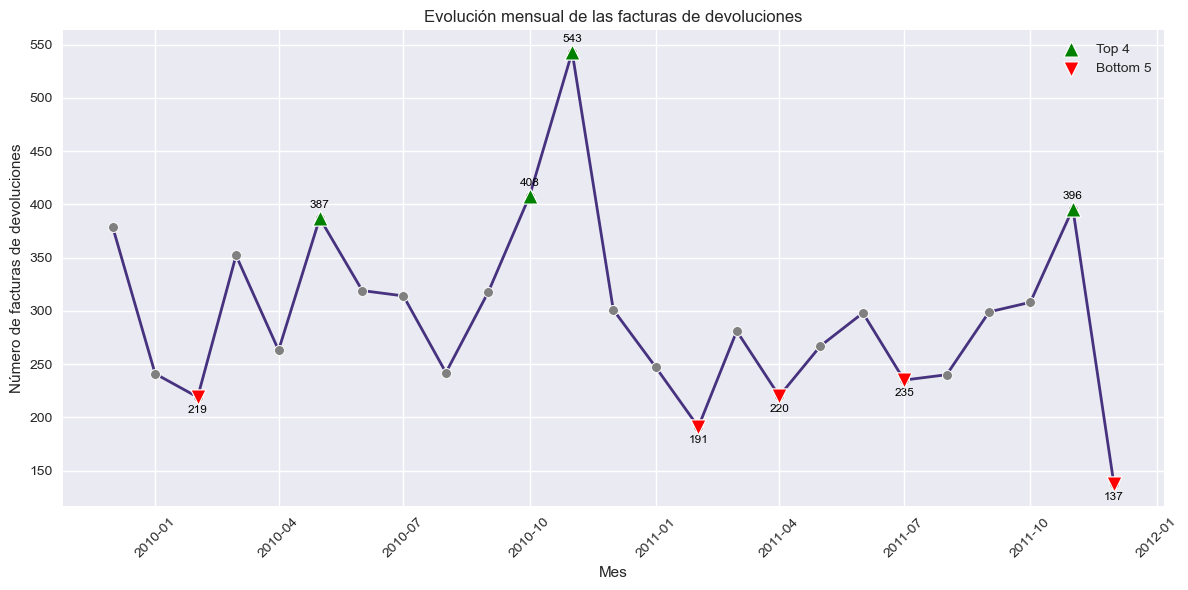

In [60]:
# Convertir valores a float
try:
    returns_per_month['Number of Returns'] = returns_per_month['Number of Returns'].str.replace(',','').astype(float)
    returns_per_month['Total Returned Value'] = returns_per_month['Total Returned Value'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Convertir meses a formato datetime
returns_per_month['Period'] = pd.to_datetime(returns_per_month['Period'], format='%Y-%m-%d')

# Seleccionar los meses con mayores y menores números de facturas de devolución
top4_rpm = returns_per_month.nlargest(4, 'Number of Returns')
bottom5_rpm = returns_per_month.nsmallest(5, 'Number of Returns')

# Validar integridad
df_check(returns_per_month, col_num='Number of Returns', col_date='Period', negative=True)

# Crear lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=returns_per_month,
    x='Period',
    y='Number of Returns',
    marker='o',
    color='C0',
    linewidth=2,
    zorder=1
)

# Dibujar puntos normales en el gráfico
sns.scatterplot(
    data=returns_per_month, x='Period', y='Number of Returns', color='gray', s=50, ax=ax, zorder=2
)

# Dibujar puntos Top 4
sns.scatterplot(
    data=top4_rpm, x='Period', y='Number of Returns', color='green', marker='^', s=120, label='Top 4', ax=ax, zorder=5
)

# Dibujar puntos Bottom 5
sns.scatterplot(
    data=bottom5_rpm, x='Period', y='Number of Returns', color='red', marker='v', s=120, label='Bottom 5', ax=ax, zorder=5
)

# Agregar etiquetas de datos para Top 4
for _, row in top4_rpm.iterrows():
    date = row['Period']
    value = row['Number of Returns']
    ax.text(date, value+7.5, f'{value:,.0f}',
           ha='center', va='bottom', fontsize=8.5, color='black')

# Agregar etiquetas de datos para Bottom 5
for _, row in bottom5_rpm.iterrows():
    date = row['Period']
    value = row['Number of Returns']
    ax.text(date, value-7.5, f'{value:,.0f}',
            ha='center', va='top', fontsize=8.5, color='black')

# Personalizar formato de gráfico
plt.title('Evolución mensual de las facturas de devoluciones')
plt.xlabel('Mes')
plt.ylabel('Número de facturas de devoluciones')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

La distribución mensual de devoluciones sigue un patrón similar al observado en el gráfico de órdenes, con **picos en los últimos meses del año**. Esto se explica porque, al incrementarse el volumen de pedidos en esos meses, también aumenta la cantidad absoluta de devoluciones, aunque la tasa de devoluciones no necesariamente sea mayor.

Los **valores más bajos** se presentan principalmente a inicios de año, después de las festividades, en un periodo de menor actividad comercial.

Sin embargo, esto no refleja una métrica precisa para analizar las devoluciones, ya que solo mide la **carga procesada** en función de pedidos y no su proporción respecto a las órdenes del mes.

Para poder visualizar correctamente el **porcentaje de devoluciones**, crearé una tabla comparando su evolución con respecto a las órdenes realizadas cada mes.

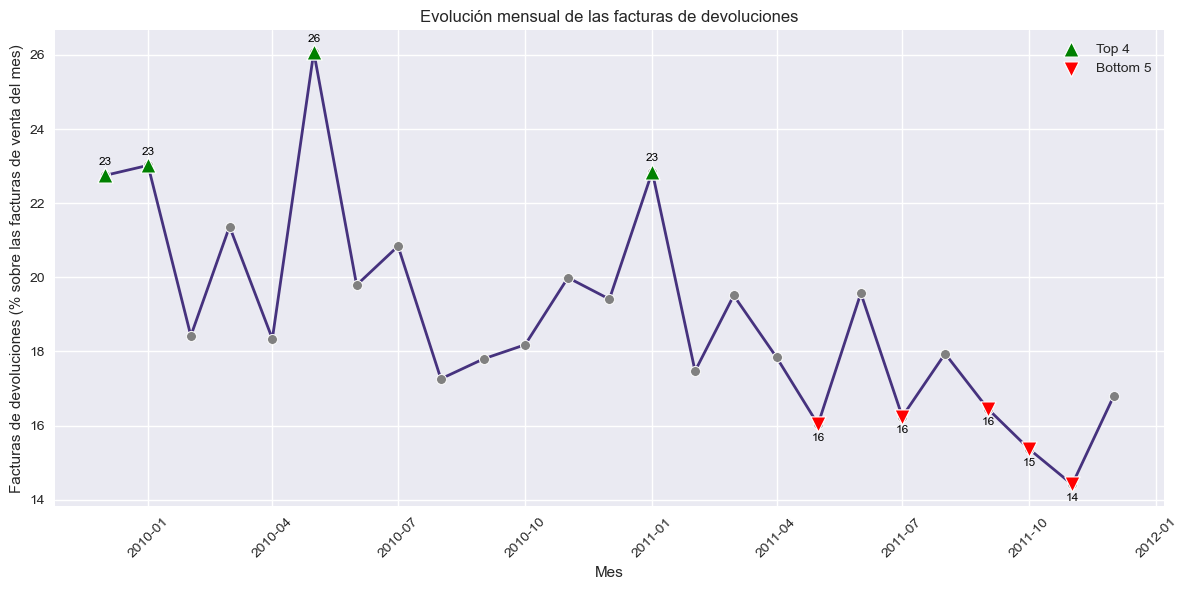

In [61]:
# Seleccionar los meses con mayores y menores porcentajes de facturas de devolución
top4_prpm = returns_per_month.nlargest(4, 'Percentage of Sales Returned')
bottom5_prpm = returns_per_month.nsmallest(5, 'Percentage of Sales Returned')

# Validar integridad
df_check(returns_per_month, col_num='Percentage of Sales Returned', col_date='Period', negative=False)

# Crear lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=returns_per_month,
    x='Period',
    y='Percentage of Sales Returned',
    marker='o',
    color='C0',
    linewidth=2,
    zorder=1
)

# Dibujar puntos normales en el gráfico
sns.scatterplot(
    data=returns_per_month, x='Period', y='Percentage of Sales Returned', color='gray', s=50, ax=ax, zorder=2
)

# Dibujar puntos Top 4
sns.scatterplot(
    data=top4_prpm, x='Period', y='Percentage of Sales Returned', color='green', marker='^', s=120, label='Top 4', ax=ax, zorder=5
)

# Dibujar puntos Bottom 5
sns.scatterplot(
    data=bottom5_prpm, x='Period', y='Percentage of Sales Returned', color='red', marker='v', s=120, label='Bottom 5', ax=ax, zorder=5
)

# Agregar etiquetas de datos para Top 4
for _, row in top4_prpm.iterrows():
    date = row['Period']
    value = row['Percentage of Sales Returned']
    ax.text(date, value+0.225, f'{value:,.0f}',
           ha='center', va='bottom', fontsize=8.5, color='black')

# Agregar etiquetas de datos para Bottom 5
for _, row in bottom5_prpm.iterrows():
    date = row['Period']
    value = row['Percentage of Sales Returned']
    ax.text(date, value-0.225, f'{value:,.0f}',
            ha='center', va='top', fontsize=8.5, color='black')

# Personalizar formato de gráfico
plt.title('Evolución mensual de las facturas de devoluciones')
plt.xlabel('Mes')
plt.ylabel('Facturas de devoluciones (% sobre las facturas de venta del mes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

El **porcentaje de devoluciones** sobre las órdenes totales muestra una **tendencia variable** pero con ciertos patrones claros, como **picos en devoluciones en enero y mayo de 2010, y en enero de 2011**. Esto podría deberse al mayor volumen de pedidos, que también incrementa la cantidad relativa de devoluciones.

Asimismo, se observa una **tendencia decreciente hacia finales de 2011**, lo que indica que, aunque haya órdenes, las devoluciones disminuyen. Esto podría estar relacionado con mejoras en los procesos internos, mayor satisfacción del cliente o algún cambio en las políticas de devolución.

Para finalizar el análisis de devoluciones, se genera un *lineplot* que permite visualizar el impacto de las devoluciones en términos monetarios. Este gráfico muestra la **evolución del valor total devuelto a lo largo del tiempo**, lo que facilita identificar periodos con mayores pérdidas económicas asociadas a devoluciones y su posible relación con el comportamiento general de las órdenes.

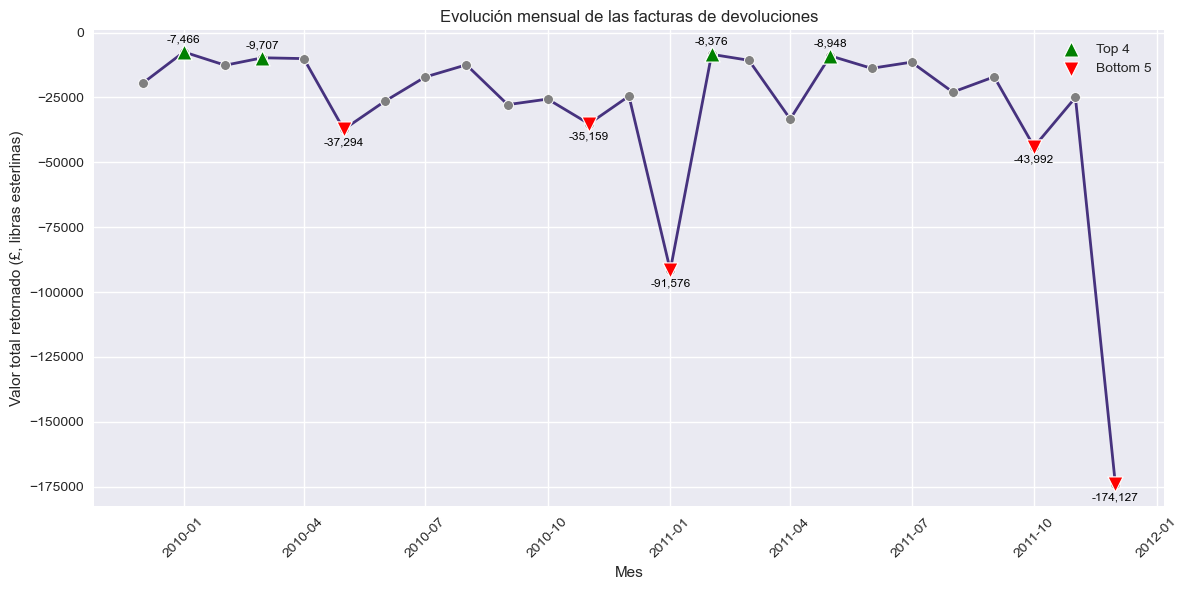

In [62]:
# Seleccionar los meses con mayores y menores valores retornados
top4_rvpm = returns_per_month.nlargest(4, 'Total Returned Value')
bottom5_rvpm = returns_per_month.nsmallest(5, 'Total Returned Value')

# Validar integridad
df_check(returns_per_month, col_num='Total Returned Value', col_date='Period', negative=True)

# Crear lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=returns_per_month,
    x='Period',
    y='Total Returned Value',
    marker='o',
    color='C0',
    linewidth=2,
    zorder=1
)

# Dibujar puntos normales en el gráfico
sns.scatterplot(
    data=returns_per_month, x='Period', y='Total Returned Value', color='gray', s=50, ax=ax, zorder=2
)

# Dibujar puntos Top 4
sns.scatterplot(
    data=top4_rvpm, x='Period', y='Total Returned Value', color='green', marker='^', s=120, label='Top 4', ax=ax, zorder=5
)

# Dibujar puntos Bottom 5
sns.scatterplot(
    data=bottom5_rvpm, x='Period', y='Total Returned Value', color='red', marker='v', s=120, label='Bottom 5', ax=ax, zorder=5
)

# Agregar etiquetas de datos para Top 4
for _, row in top4_rvpm.iterrows():
    date = row['Period']
    value = row['Total Returned Value']
    ax.text(date, value+3000, f'{value:,.0f}',
           ha='center', va='bottom', fontsize=8.5, color='black')

# Agregar etiquetas de datos para Bottom 5
for _, row in bottom5_rvpm.iterrows():
    date = row['Period']
    value = row['Total Returned Value']
    ax.text(date, value-3000, f'{value:,.0f}',
            ha='center', va='top', fontsize=8.5, color='black')

# Personalizar formato de gráfico
plt.title('Evolución mensual de las facturas de devoluciones')
plt.xlabel('Mes')
plt.ylabel('Valor total retornado (£, libras esterlinas)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Se observa que, en términos absolutos, la mayoría de los meses presentan **pérdidas moderadas** por **debajo de las 50 mil libras esterlinas**, con **excepción** de dos caídas muy pronunciadas: **enero de 2011 y diciembre de 2011**, este último siendo el **valor más bajo** de todo el periodo analizado.

Los valores más **“favorables”** (menor impacto económico de las devoluciones) se concentran en los **primeros meses de cada año**, como enero y febrero de 2010, así como enero y marzo de 2011, con pérdidas cercanas o inferiores a las **10 mil libras**.

En conjunto, los datos sugieren que, aunque el **número de devoluciones** sigue **patrones similares a los de las órdenes**, el **impacto monetario** no siempre está alineado con la cantidad de devoluciones, ya que en algunos meses con pocas devoluciones el valor retornado puede ser elevado debido a **productos de mayor precio**.

---
### 11. Pregunta 9: ¿Cuáles son los productos más devueltos?

En esta pregunta se identifican los productos más devueltos en el periodo analizado.

El enfoque se centra en la **frecuencia de devoluciones por factura**, es decir, en cuántas ventas únicas un producto terminó siendo devuelto al menos una vez.

Este criterio permite destacar aquellos artículos que generan un **mayor número de incidencias** con los clientes, independientemente de la cantidad de unidades devueltas.


#### 11.1. Análisis general

Para responder esta pregunta se utilizó el conteo de **facturas únicas** (`COUNT(DISTINCT "Invoice")`) que registraron al menos una devolución de cada producto. De esta forma, si un cliente devolvió el mismo artículo varias veces dentro de la misma factura, solo se contabiliza una vez.  

Junto con el número de facturas, se muestra el **valor monetario total devuelto**, lo que ayuda a dimensionar el impacto económico de dichas devoluciones.

In [63]:
# Obtener productos por total de facturas de devoluciones
query = """
SELECT "Description", 
    COUNT(DISTINCT "Invoice") AS "Return Invoices",
    SUM("LineTotal") AS "Total Returned Value"
FROM retail
WHERE "Quantity" < 0
GROUP BY "Description"
ORDER BY "Return Invoices" DESC;
"""

# Convertir consulta a DataFrame
returns = pd.read_sql_query(query, engine)

# Copiar DataFrame y mostrar los 10 primeros
top_returns = returns.head(10).copy()

# Formatear columnas y mostrar resultados
top_returns['Total Returned Value'] = top_returns['Total Returned Value'].map('{:,.0f}'.format)
display(top_returns)

Description  Return Invoices Total Returned Value
0            REGENCY CAKESTAND 3 TIER              341              -16,750
1        BAKING SET 9 PIECE RETROSPOT              209               -4,073
2      STRAWBERRY CERAMIC TRINKET BOX              183               -1,105
3            RED RETROSPOT CAKE STAND              154               -5,402
4  WHITE HANGING HEART T-LIGHT HOLDER              134               -9,390
5                 WHITE CHERRY LIGHTS              124               -6,421
6    RED RETROSPOT TRADITIONAL TEAPOT              114               -1,424
7                SMALL POPCORN HOLDER               90                 -621
8                  PINK CHERRY LIGHTS               86               -4,021
9            JAM MAKING SET WITH JARS               86               -1,043

Para la visualización del gráfico usaré un *barplot* horizontal que nos muestren los **10 productos más devueltos** por su incidencia en **facturas únicas**.

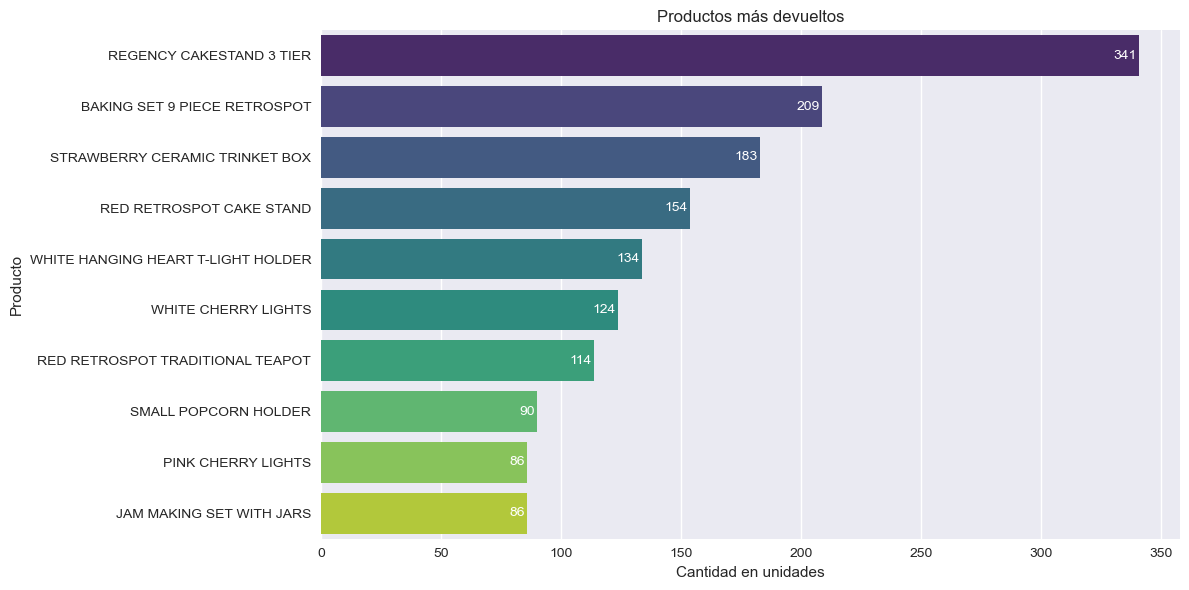

In [64]:
# Convertir valores a float
try:
    top_returns['Total Returned Value'] = returns['Total Returned Value'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validar integridad
df_check(top_returns, col_num='Return Invoices', col_text='Description', negative=False)

# Crear gráfico barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_returns,
    x='Return Invoices',
    y='Description',
    hue='Description',
    palette='viridis',
    legend=False
)

# Agregar etiquetas de datos
for i, returns_val in enumerate(top_returns['Return Invoices']):
    ax.text(returns_val - 1, i, str(returns_val), 
            va='center', ha='right', fontsize=10, 
            color='white')

# Personalizar formato de gráfico
plt.title('Productos más devueltos')
plt.xlabel('Cantidad en unidades')
plt.ylabel('Producto')
plt.tight_layout()
plt.show() 

En el gráfico se aprecia que el producto **"REGENCY CAKESTAND 3 TIER"** encabeza la lista, lo cual resulta coherente, ya que también es uno de los artículos más vendidos en el periodo analizado.

Llama la atención, sin embargo, que la mayoría de los productos presentes en el ranking **no figuran entre los más vendidos**, lo que podría indicar algún tipo de problema con los artículos en sí (por ejemplo, defectos de fabricación) o con su descripción en el catálogo, generando posibles confusiones en los clientes.


Considerando que existen **dos mercados diferenciados**, el Reino Unido como principal y el resto del mundo como secundario, analizaré las diferencias en el comportamiento de las devoluciones entre ambos.

#### 11.2. Resultados en Reino Unido

La consulta SQL sigue el mismo formato que la consulta general, considerando solo **facturas únicas** de devoluciones cuyo país de origen sea **Reino Unido.**

In [65]:
# Obtener productos por total de facturas de devoluciones en Reino Unido
query = """
SELECT "Description", 
    COUNT(DISTINCT "Invoice") AS "Return Invoices",
    SUM("LineTotal") AS "Total Returned Value"
FROM retail
WHERE "Quantity" < 0
    AND "Country" = "United Kingdom"
GROUP BY "Description"
ORDER BY "Return Invoices" DESC;
"""

# Convertir consulta a DataFrame
uk_returns = pd.read_sql_query(query, engine)

# Copiar DataFrame y mostrar los 10 primeros
top_uk_returns = uk_returns.head(10).copy()

# Formatear columnas y mostrar resultados
top_uk_returns['Total Returned Value'] = top_uk_returns['Total Returned Value'].map('{:,.0f}'.format)
display(top_uk_returns)

Description  Return Invoices Total Returned Value
0            REGENCY CAKESTAND 3 TIER              281              -13,813
1        BAKING SET 9 PIECE RETROSPOT              177               -3,204
2      STRAWBERRY CERAMIC TRINKET BOX              155               -1,011
3  WHITE HANGING HEART T-LIGHT HOLDER              129               -9,193
4            RED RETROSPOT CAKE STAND              129               -4,878
5                 WHITE CHERRY LIGHTS              124               -6,421
6    RED RETROSPOT TRADITIONAL TEAPOT               95               -1,209
7                  PINK CHERRY LIGHTS               86               -4,021
8  WOOD 2 DRAWER CABINET WHITE FINISH               80               -1,508
9             JUMBO BAG RED RETROSPOT               79               -2,145

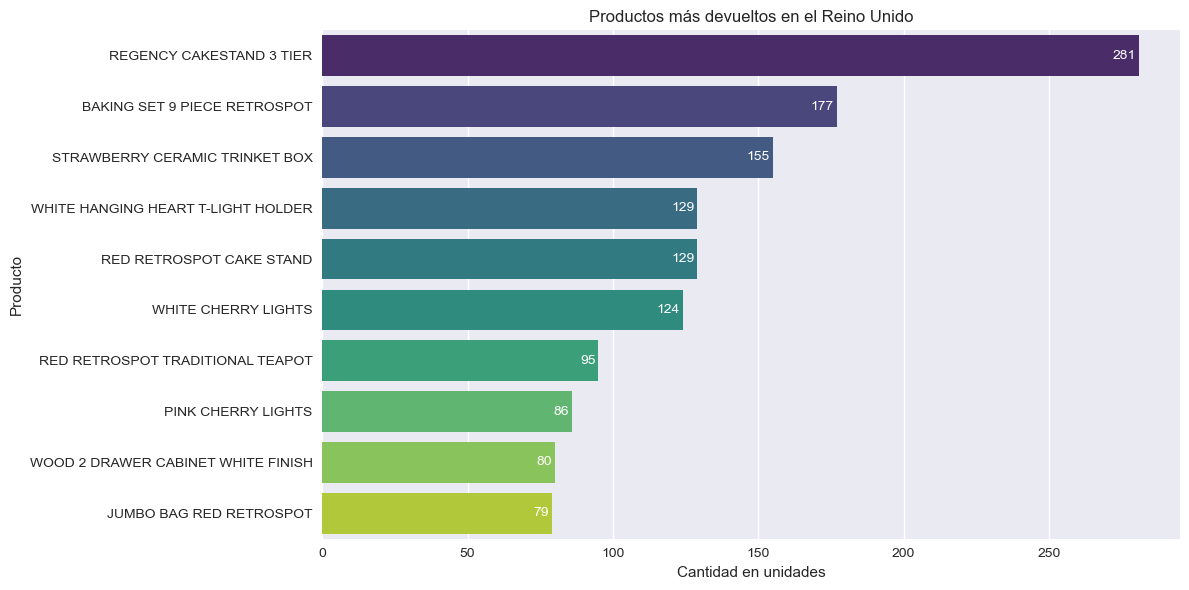

In [66]:
# Convertir valores a float
try:
    top_uk_returns['Return Invoices'] = top_uk_returns['Return Invoices'].str.replace(',', '').astype(float)
    top_uk_returns['Total Returned Value'] = top_uk_returns['Total Returned Value'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validar integridad
df_check(top_uk_returns, col_num='Return Invoices', col_text='Description', negative=False)

# Crear gráfico barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_uk_returns,
    x='Return Invoices',
    y='Description',
    hue='Description',
    palette='viridis',
    legend=False
)

# Agregar etiquetas de datos
for i, value in enumerate(top_uk_returns['Return Invoices']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Personalizar formato de gráfico
plt.title('Productos más devueltos en el Reino Unido')
plt.xlabel('Cantidad en unidades')
plt.ylabel('Producto')
plt.tight_layout()
plt.show()

Queda claro que el **Reino Unido** marca la pauta en la tendencia del dataset, ya que incluye **8 de los 10 productos** presentes en el análisis general. Además, los **tres productos más devueltos** coinciden con los observados en el gráfico que considera a **todos los países**.

#### 11.3. Resultados en el resto del mundo

Para la consulta del **resto del mundo**, se seleccionan todos los países **excepto** aquellos cuya etiqueta corresponde al **Reino Unido**.

In [67]:
# Obtener productos por total de facturas de devoluciones en el resto del mundo
query = """
SELECT "Description", 
    COUNT(DISTINCT "Invoice") AS "Return Invoices",
    SUM("LineTotal") AS "Total Returned Value"
FROM retail
WHERE "Quantity" < 0
    AND "Country" != "United Kingdom"
GROUP BY "Description"
ORDER BY "Return Invoices" DESC;
"""

# Convertir consulta a DataFrame
rw_returns = pd.read_sql_query(query, engine)

# Copiar DataFrame y mostrar los 10 primeros
top_rw_returns = rw_returns.head(10).copy()

# Formatear columnas y mostrar resultados
top_rw_returns['Total Returned Value'] = top_rw_returns['Total Returned Value'].map('{:,.0f}'.format)
display(top_rw_returns)

Description  Return Invoices Total Returned Value
0             REGENCY CAKESTAND 3 TIER               60               -2,937
1         BAKING SET 9 PIECE RETROSPOT               32                 -869
2       STRAWBERRY CERAMIC TRINKET BOX               28                  -94
3                    GUMBALL COAT RACK               28                 -294
4  SET/5 RED RETROSPOT LID GLASS BOWLS               25                 -143
5             RED RETROSPOT CAKE STAND               25                 -524
6                    GLASS BEURRE DISH               21                  -94
7        CHILDS BREAKFAST SET SPACEBOY               20                 -514
8     RED RETROSPOT TRADITIONAL TEAPOT               19                 -215
9    ROUND SNACK BOXES SET OF 4 FRUITS               16               -1,700

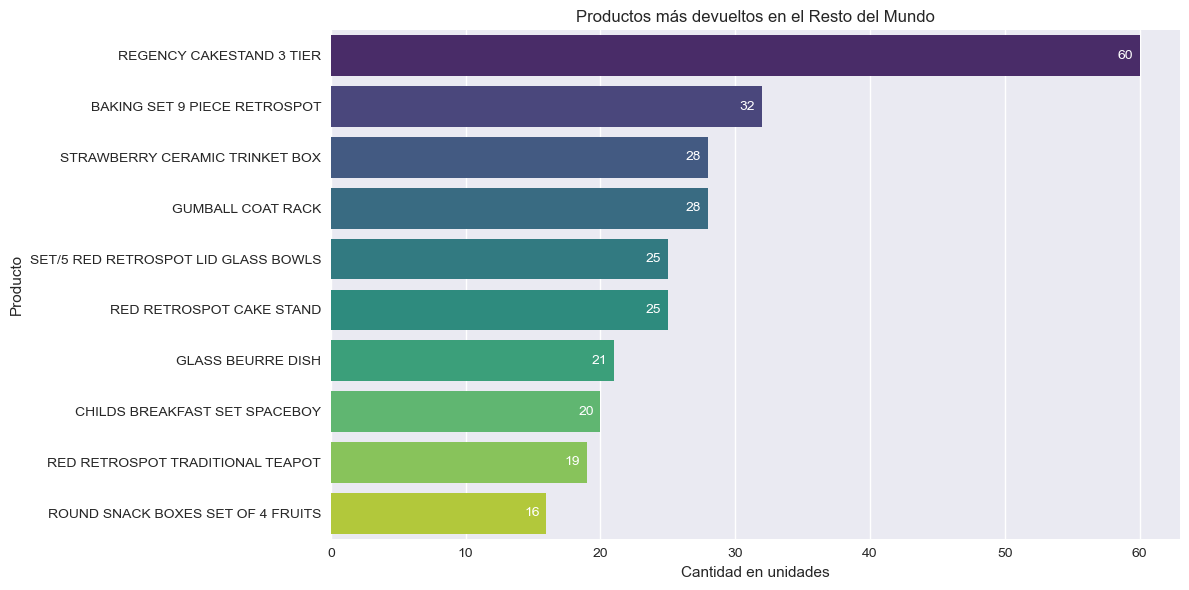

In [68]:
# Convertir valores a float
try:
    top_rw_returns['Return Invoices'] = top_rw_returns['Return Invoices'].str.replace(',', '').astype(float)
    top_rw_returns['Total Returned Value'] = top_rw_returns['Total Returned Value'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validar integridad
df_check(top_rw_returns, col_num='Return Invoices', col_text='Description', negative=False)

# Crear gráfico barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_rw_returns,
    x='Return Invoices',
    y='Description',
    hue='Description',
    palette='viridis',
    legend=False
)

# Agregar etiquetas de datos
for i, value in enumerate(top_rw_returns['Return Invoices']):
    ax.text(value-0.5, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')


# Personalizar formato de gráfico
plt.title('Productos más devueltos en el Resto del Mundo')
plt.xlabel('Cantidad en unidades')
plt.ylabel('Producto')
plt.tight_layout()
plt.show()

En el caso del **resto del mundo**, el panorama cambia. Los **tres primeros productos** con más devoluciones se mantienen, pero el resto de los artículos en el *top 10* difiere de la tabla global, lo que indica un **hábito de devolución distinto** fuera del mercado británico.

---
### 12. Pregunta 10: ¿Qué productos suelen comprarse juntos?

En esta sección se analiza qué **combinaciones de productos** aparecen con mayor frecuencia en las facturas, con el fin de identificar patrones de compra conjunta.

#### 12.1. Análisis general

El siguiente código realiza un **conteo de las combinaciones de productos** que se venden juntas en una **misma factura**.

Primero, agrupa los productos por factura y **elimina duplicados**. Luego, genera **todas las combinaciones posibles de 2 productos** y cuenta cuántas veces aparece cada par. Finalmente, muestra los 30 pares más frecuentes en un formato tabular para su análisis.

Debido a la gran cantidad de **combinaciones posibles**, el procesamiento de esta celda puede tomar unos minutos.

In [69]:
# Importar las librerías necesarias para el análisis de canasta
from itertools import combinations
from collections import Counter

# Agrupar productos por factura en el DataFrame general
basket_df = df.groupby('Invoice')['Description'].apply(list)

# Contar combinaciones de 2 productos
pairs_counter = Counter()
for basket in basket_df:
    unique_products = list(set(basket))  # evitar duplicados
    for pair in combinations(sorted(unique_products), 2):
        pairs_counter[pair] += 1

# Mostrar los 30 pares más frecuentes
top_pairs = pairs_counter.most_common(30)

# Convertir a DataFrame, agregar formatos y mostrar resultados
top_pairs_df = pd.DataFrame(top_pairs, columns=['Product Pair', 'Count'])
top_pairs_df[['Product A', 'Product B']] = pd.DataFrame(top_pairs_df['Product Pair'].tolist(), index=top_pairs_df.index)
top_pairs_df = top_pairs_df[['Product A', 'Product B', 'Count']]
display(top_pairs_df)

Product A                           Product B  \
0              JUMBO BAG PINK POLKADOT             JUMBO BAG RED RETROSPOT   
1              JUMBO BAG RED RETROSPOT              JUMBO STORAGE BAG SUKI   
2     RED HANGING HEART T-LIGHT HOLDER  WHITE HANGING HEART T-LIGHT HOLDER   
3               LUNCH BAG BLACK SKULL.             LUNCH BAG RED RETROSPOT   
4          60 TEATIME FAIRY CAKE CASES     PACK OF 72 RETROSPOT CAKE CASES   
5              JUMBO BAG RED RETROSPOT                JUMBO BAG STRAWBERRY   
6              LUNCH BAG RED RETROSPOT               LUNCH BAG SUKI DESIGN   
7              LUNCH BAG PINK POLKADOT             LUNCH BAG RED RETROSPOT   
8              JUMBO BAG RED RETROSPOT   JUMBO SHOPPER VINTAGE RED PAISLEY   
9       STRAWBERRY CERAMIC TRINKET BOX      SWEETHEART CERAMIC TRINKET BOX   
10       JUMBO BAG BAROQUE BLACK WHITE             JUMBO BAG RED RETROSPOT   
11          WOODEN FRAME ANTIQUE WHITE   WOODEN PICTURE FRAME WHITE FINISH   
12             JUMBO BAG RED RETROSPOT             LUNCH BAG RED RETROSPOT   
13  PACK OF 60 PINK PAISLEY CAKE CASES     PACK OF 72 RETROSPOT CAKE CASES   
14         CHARLOTTE BAG PINK POLKADOT         RED RETROSPOT CHARLOTTE BAG   
15                 LUNCH BAG CARS BLUE             LUNCH BAG RED RETROSPOT   
16     GREEN REGENCY TEACUP AND SAUCER     ROSES REGENCY TEACUP AND SAUCER   
17             LUNCH BAG RED RETROSPOT                  LUNCH BAG WOODLAND   
18           LUNCH BAG SPACEBOY DESIGN               LUNCH BAG SUKI DESIGN   
19              LUNCH BAG BLACK SKULL.               LUNCH BAG SUKI DESIGN   
20             LUNCH BAG RED RETROSPOT           LUNCH BAG SPACEBOY DESIGN   
21               HEART OF WICKER LARGE               HEART OF WICKER SMALL   
22           CHARLOTTE BAG SUKI DESIGN         RED RETROSPOT CHARLOTTE BAG   
23              LUNCH BAG BLACK SKULL.             LUNCH BAG PINK POLKADOT   
24                 LUNCH BAG CARS BLUE               LUNCH BAG SUKI DESIGN   
25             JUMBO BAG RED RETROSPOT  WHITE HANGING HEART T-LIGHT HOLDER   
26             JUMBO BAG RED RETROSPOT      JUMBO BAG SCANDINAVIAN PAISLEY   
27         RED RETROSPOT CHARLOTTE BAG              WOODLAND CHARLOTTE BAG   
28         60 TEATIME FAIRY CAKE CASES  PACK OF 60 PINK PAISLEY CAKE CASES   
29      JUMBO BAG PINK VINTAGE PAISLEY             JUMBO BAG RED RETROSPOT   

    Count  
0    1440  
1    1338  
2    1256  
3    1213  
4    1202  
5    1200  
6    1185  
7    1169  
8    1167  
9    1141  
10   1124  
11   1124  
12   1120  
13   1113  
14   1084  
15   1057  
16   1054  
17   1039  
18   1029  
19   1016  
20   1007  
21   1003  
22    964  
23    958  
24    948  
25    935  
26    932  
27    930  
28    925  
29    920

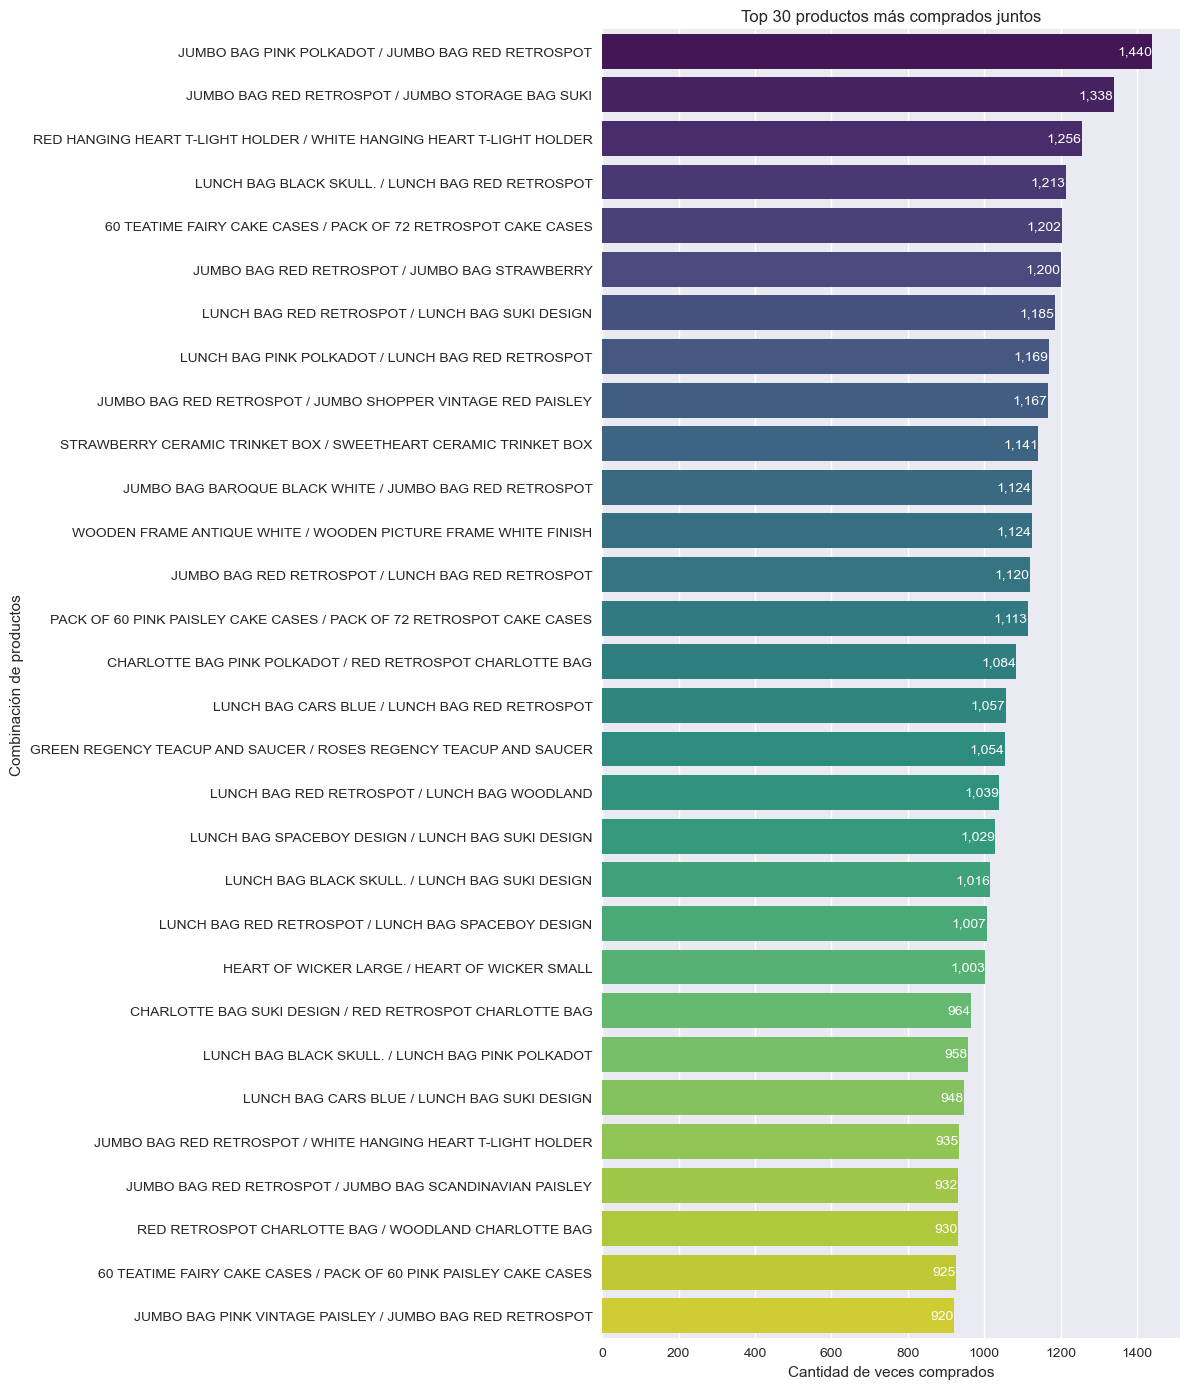

In [70]:
# Concatenar pares
top_pairs_df['Pairs'] = top_pairs_df['Product A'] + ' / ' + top_pairs_df['Product B']

# Guardar DataFrame en formato csv para visualizaciones en el dashboard
tpdf_save_path = BASE_DIR / 'data' / 'top_pairs.csv'
top_pairs_df.to_csv(tpdf_save_path, index=False)

# Validar integridad
df_check(top_pairs_df, col_num='Count', col_text='Pairs', negative=False)

# Crear gráfico barplot
plt.figure(figsize=(12, 14))
ax = sns.barplot(
    data=top_pairs_df,
    x='Count',
    y='Pairs',
    hue='Pairs',
    palette='viridis',
    legend=False
)

# Agregar etiquetas de datos
for i, value in enumerate(top_pairs_df['Count']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Personalizar formato de gráfico
plt.title('Top 30 productos más comprados juntos')
plt.xlabel('Cantidad de veces comprados')
plt.ylabel('Combinación de productos')
plt.tight_layout()
plt.show()

Se observa en los resultados que el par de productos más comprado es **JUMBO BAG PINK POLKADOT** y **JUMBO BAG RED RETROSPOT**, apareciendo **1,440 veces** en distintas facturas.  

Además, al analizar más detalladamente los pares frecuentes, se aprecia que la mayoría de productos que suelen comprarse juntos pertenecen a la **misma categoría**, lo que sugiere patrones de compra por tipo o temática de producto.

Reviso ahora el **comportamiento en el Reino Unido** para conocer si los pares de productos más frecuentes coinciden con el patrón global o presentan ligeras variaciones.

#### 12.2. Resultados en Reino Unido

La rutina aplicada en *pandas* es similar a la utilizada en el análisis global, con la diferencia de que en este caso se filtran únicamente los productos vendidos en el **mercado británico**.

In [71]:
# Agrupar productos por factura en el DataFrame del Reino Unido
uk_basket_df = uk_df.groupby('Invoice')['Description'].apply(list)

# Contar combinaciones de 2 productos
uk_pairs_counter = Counter()

for basket in uk_basket_df:
    unique_products = list(set(basket))  # evitar duplicados
    for pair in combinations(sorted(unique_products), 2):
        uk_pairs_counter[pair] += 1

# Mostrar los 30 pares más frecuentes
uk_top_pairs = uk_pairs_counter.most_common(30)

# Convertir a DataFrame, agregar formatos y mostrar resultados
uk_top_pairs_df = pd.DataFrame(uk_top_pairs, columns=['Product Pair', 'Count'])
uk_top_pairs_df[['Product A', 'Product B']] = pd.DataFrame(uk_top_pairs_df['Product Pair'].tolist(), index=uk_top_pairs_df.index)
uk_top_pairs_df = uk_top_pairs_df[['Product A', 'Product B', 'Count']]
display(uk_top_pairs_df)

Product A                           Product B  \
0              JUMBO BAG PINK POLKADOT             JUMBO BAG RED RETROSPOT   
1              JUMBO BAG RED RETROSPOT              JUMBO STORAGE BAG SUKI   
2     RED HANGING HEART T-LIGHT HOLDER  WHITE HANGING HEART T-LIGHT HOLDER   
3               LUNCH BAG BLACK SKULL.             LUNCH BAG RED RETROSPOT   
4              JUMBO BAG RED RETROSPOT                JUMBO BAG STRAWBERRY   
5              JUMBO BAG RED RETROSPOT   JUMBO SHOPPER VINTAGE RED PAISLEY   
6           WOODEN FRAME ANTIQUE WHITE   WOODEN PICTURE FRAME WHITE FINISH   
7          60 TEATIME FAIRY CAKE CASES     PACK OF 72 RETROSPOT CAKE CASES   
8        JUMBO BAG BAROQUE BLACK WHITE             JUMBO BAG RED RETROSPOT   
9              LUNCH BAG RED RETROSPOT               LUNCH BAG SUKI DESIGN   
10      STRAWBERRY CERAMIC TRINKET BOX      SWEETHEART CERAMIC TRINKET BOX   
11             LUNCH BAG PINK POLKADOT             LUNCH BAG RED RETROSPOT   
12             JUMBO BAG RED RETROSPOT             LUNCH BAG RED RETROSPOT   
13  PACK OF 60 PINK PAISLEY CAKE CASES     PACK OF 72 RETROSPOT CAKE CASES   
14               HEART OF WICKER LARGE               HEART OF WICKER SMALL   
15              LUNCH BAG BLACK SKULL.               LUNCH BAG SUKI DESIGN   
16         CHARLOTTE BAG PINK POLKADOT         RED RETROSPOT CHARLOTTE BAG   
17                 LUNCH BAG CARS BLUE             LUNCH BAG RED RETROSPOT   
18     GREEN REGENCY TEACUP AND SAUCER     ROSES REGENCY TEACUP AND SAUCER   
19           LUNCH BAG SPACEBOY DESIGN               LUNCH BAG SUKI DESIGN   
20              LUNCH BAG BLACK SKULL.             LUNCH BAG PINK POLKADOT   
21             LUNCH BAG RED RETROSPOT                  LUNCH BAG WOODLAND   
22             JUMBO BAG RED RETROSPOT  WHITE HANGING HEART T-LIGHT HOLDER   
23             LUNCH BAG RED RETROSPOT           LUNCH BAG SPACEBOY DESIGN   
24             JUMBO BAG RED RETROSPOT      JUMBO BAG SCANDINAVIAN PAISLEY   
25                 LUNCH BAG CARS BLUE               LUNCH BAG SUKI DESIGN   
26           CHARLOTTE BAG SUKI DESIGN         RED RETROSPOT CHARLOTTE BAG   
27             JUMBO BAG PINK POLKADOT              JUMBO STORAGE BAG SUKI   
28   JUMBO SHOPPER VINTAGE RED PAISLEY              JUMBO STORAGE BAG SUKI   
29      JUMBO BAG PINK VINTAGE PAISLEY             JUMBO BAG RED RETROSPOT   

    Count  
0    1362  
1    1293  
2    1190  
3    1165  
4    1161  
5    1130  
6    1099  
7    1096  
8    1094  
9    1093  
10   1074  
11   1074  
12   1029  
13    997  
14    988  
15    978  
16    967  
17    965  
18    960  
19    947  
20    920  
21    917  
22    911  
23    909  
24    890  
25    888  
26    886  
27    886  
28    881  
29    862

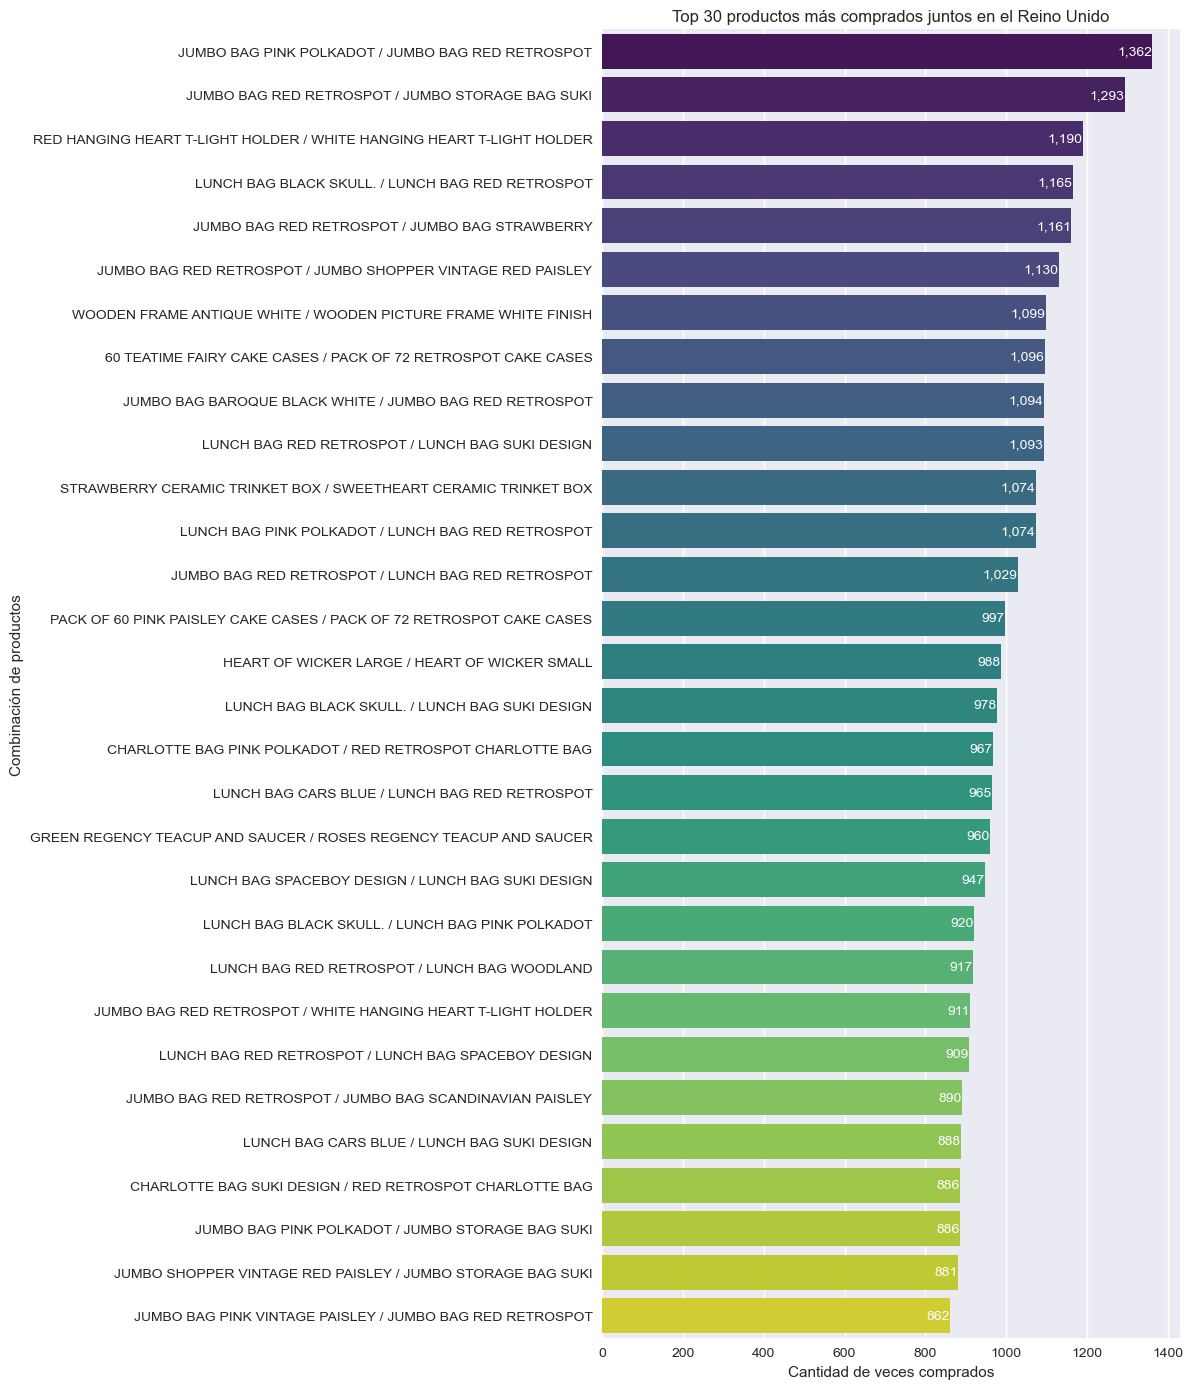

In [72]:
# Concatenar pares
uk_top_pairs_df['Pairs'] = uk_top_pairs_df['Product A'] + ' / ' + uk_top_pairs_df['Product B']

# Validar integridad
df_check(uk_top_pairs_df, col_num='Count', col_text='Pairs', negative=False)

# Crear gráfico barplot
plt.figure(figsize=(12, 14))
ax = sns.barplot(
    data=uk_top_pairs_df,
    x='Count',
    y='Pairs',
    hue='Pairs',
    palette='viridis',
    legend=False
)

# Agregar etiquetas de datos
for i, value in enumerate(uk_top_pairs_df['Count']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Personalizar formato de gráfico
plt.title('Top 30 productos más comprados juntos en el Reino Unido')
plt.xlabel('Cantidad de veces comprados')
plt.ylabel('Combinación de productos')
plt.tight_layout()
plt.show()

Los resultados de los productos más vendidos muestran que **7 de los 10 primeros productos en este ranking** forman parte del **Top 10 global**.

Esto confirma que la pauta general está **fuertemente influenciada por el mercado británico**, tal como se observó en secciones anteriores.

Finalmente, para cerrar el análisis exploratorio, se replicará el procedimiento con los datos correspondientes a los países **fuera del Reino Unido**, con el objetivo de **identificar si presentan patrones de compra distintos al análisis global**.

#### 12.3. Resultados en el resto del mundo

La rutina en *pandas* es la misma utilizada en los análisis previos de esta sección. En este caso, se filtran únicamente las transacciones correspondientes a **países distintos del Reino Unido**.


In [73]:
# Agrupar productos por factura en el DataFrame del resto del mundo
rw_basket_df = rw_df.groupby('Invoice')['Description'].apply(list)

# Contar combinaciones de 2 productos
rw_pairs_counter = Counter()
for basket in rw_basket_df:
    unique_products = list(set(basket))  # evitar duplicados
    for pair in combinations(sorted(unique_products), 2):
        rw_pairs_counter[pair] += 1

# Mostrar los 30 pares más frecuentes
rw_top_pairs = rw_pairs_counter.most_common(30)

# Convertir a DataFrame, agregar formatos y mostrar resultados
rw_top_pairs_df = pd.DataFrame(rw_top_pairs, columns=['Product Pair', 'Count'])
rw_top_pairs_df[['Product A', 'Product B']] = pd.DataFrame(rw_top_pairs_df['Product Pair'].tolist(), index=rw_top_pairs_df.index)
rw_top_pairs_df = rw_top_pairs_df[['Product A', 'Product B', 'Count']]
display(rw_top_pairs_df)

Product A                           Product B  \
0    ROUND SNACK BOXES SET OF 4 FRUITS  ROUND SNACK BOXES SET OF4 WOODLAND   
1        PLASTERS IN TIN CIRCUS PARADE    PLASTERS IN TIN WOODLAND ANIMALS   
2             PLASTERS IN TIN SPACEBOY    PLASTERS IN TIN WOODLAND ANIMALS   
3                 DOLLY GIRL LUNCH BOX                  SPACEBOY LUNCH BOX   
4        PLASTERS IN TIN CIRCUS PARADE            PLASTERS IN TIN SPACEBOY   
5          RED RETROSPOT CHARLOTTE BAG              WOODLAND CHARLOTTE BAG   
6          SET/6 RED SPOTTY PAPER CUPS       SET/6 RED SPOTTY PAPER PLATES   
7     PLASTERS IN TIN WOODLAND ANIMALS  ROUND SNACK BOXES SET OF4 WOODLAND   
8        PLASTERS IN TIN CIRCUS PARADE           PLASTERS IN TIN STRONGMAN   
9   ROUND SNACK BOXES SET OF4 WOODLAND                  SPACEBOY LUNCH BOX   
10  ROUND SNACK BOXES SET OF4 WOODLAND              WOODLAND CHARLOTTE BAG   
11       RED TOADSTOOL LED NIGHT LIGHT  ROUND SNACK BOXES SET OF4 WOODLAND   
12  SET/20 RED RETROSPOT PAPER NAPKINS       SET/6 RED SPOTTY PAPER PLATES   
13       PLASTERS IN TIN CIRCUS PARADE  ROUND SNACK BOXES SET OF4 WOODLAND   
14    LUNCH BOX WITH CUTLERY RETROSPOT   STRAWBERRY LUNCH BOX WITH CUTLERY   
15             LUNCH BAG RED RETROSPOT                  LUNCH BAG WOODLAND   
16  SET/20 RED RETROSPOT PAPER NAPKINS         SET/6 RED SPOTTY PAPER CUPS   
17         CHARLOTTE BAG PINK POLKADOT         RED RETROSPOT CHARLOTTE BAG   
18            PLASTERS IN TIN SPACEBOY  ROUND SNACK BOXES SET OF4 WOODLAND   
19  PACK OF 60 PINK PAISLEY CAKE CASES     PACK OF 72 RETROSPOT CAKE CASES   
20           PLASTERS IN TIN STRONGMAN    PLASTERS IN TIN WOODLAND ANIMALS   
21  BLUE 3 PIECE MINI DOTS CUTLERY SET  PINK 3 PIECE MINI DOTS CUTLERY SET   
22     PACK OF 72 RETROSPOT CAKE CASES   SET OF 72 RETROSPOT PAPER DOILIES   
23            RED RETROSPOT MINI CASES  ROUND SNACK BOXES SET OF4 WOODLAND   
24       RED TOADSTOOL LED NIGHT LIGHT              WOODLAND CHARLOTTE BAG   
25    LUNCH BOX WITH CUTLERY RETROSPOT  ROUND SNACK BOXES SET OF4 WOODLAND   
26         60 TEATIME FAIRY CAKE CASES     PACK OF 72 RETROSPOT CAKE CASES   
27             JUMBO BAG RED RETROSPOT          JUMBO BAG WOODLAND ANIMALS   
28         RED RETROSPOT CHARLOTTE BAG  ROUND SNACK BOXES SET OF4 WOODLAND   
29            PLASTERS IN TIN SPACEBOY                  SPACEBOY LUNCH BOX   

    Count  
0     242  
1     193  
2     187  
3     182  
4     163  
5     161  
6     154  
7     145  
8     139  
9     137  
10    136  
11    135  
12    130  
13    127  
14    124  
15    122  
16    121  
17    117  
18    117  
19    116  
20    114  
21    112  
22    110  
23    110  
24    109  
25    109  
26    106  
27    105  
28    105  
29    105

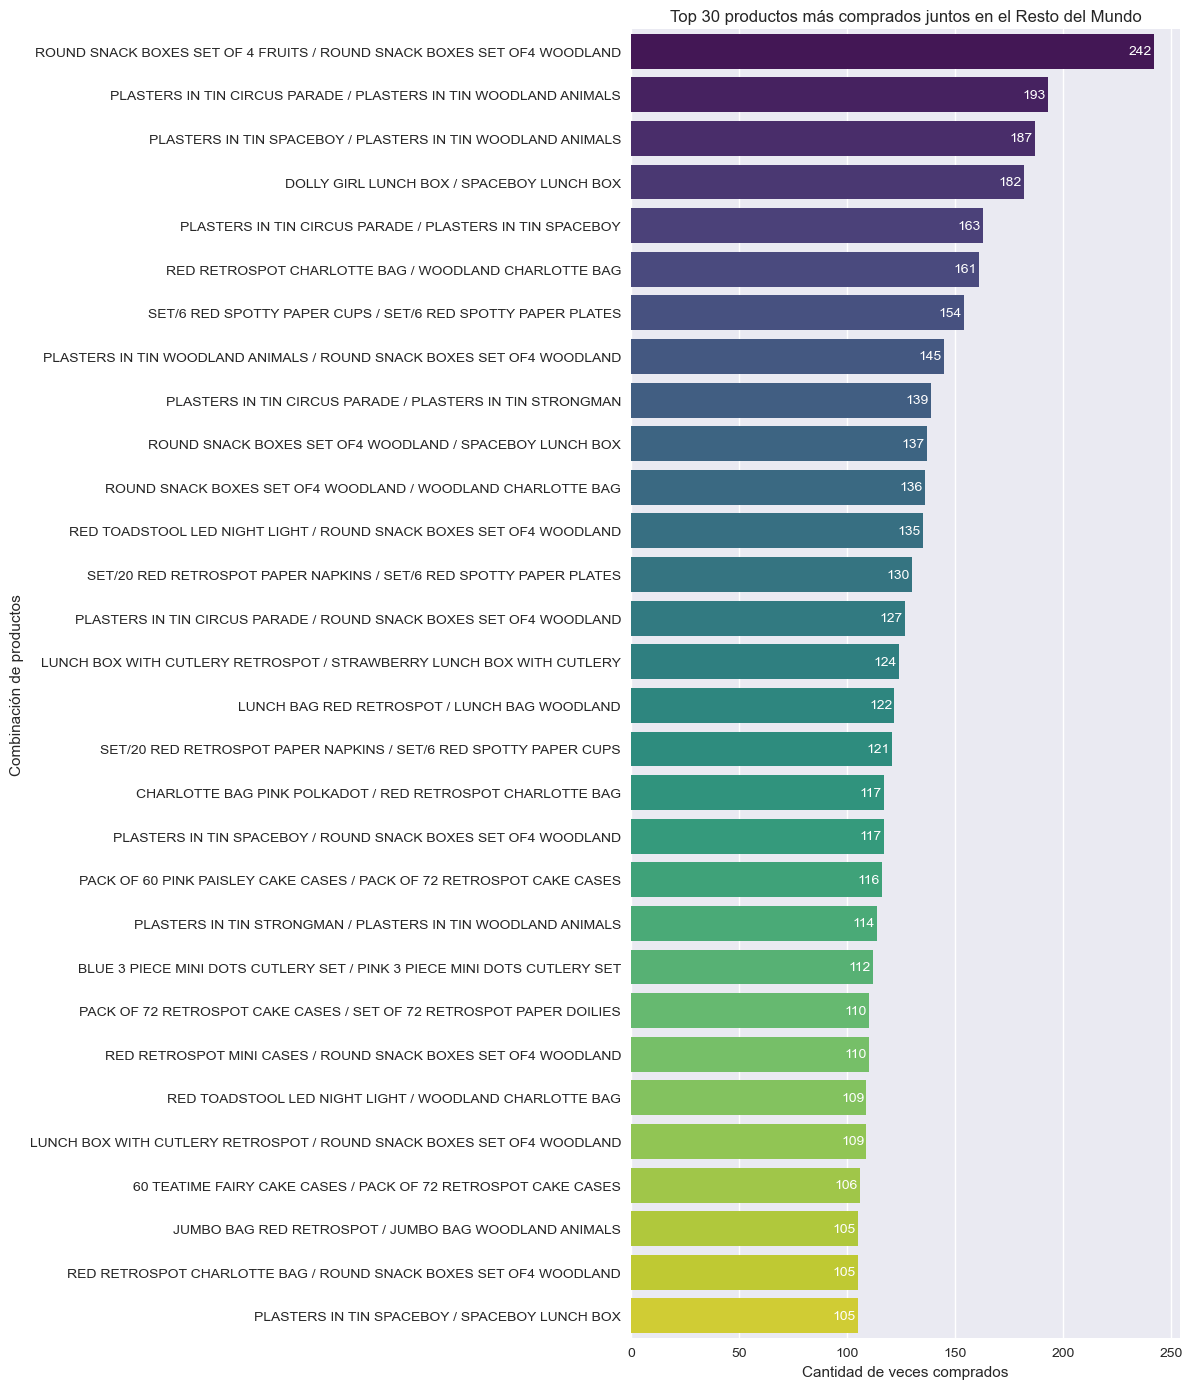

In [74]:
# Concatenar datos
rw_top_pairs_df['Pairs'] = rw_top_pairs_df['Product A'] + ' / ' + rw_top_pairs_df['Product B']

# Validar integridad
df_check(rw_top_pairs_df, col_num='Count', col_text='Pairs', negative=False)

# Crear gráfico barplot
plt.figure(figsize=(12, 14))
ax = sns.barplot(
    data=rw_top_pairs_df,
    x='Count',
    y='Pairs',
    hue='Pairs',
    palette='viridis',
    legend=False
)

# Agregar etiquetas de datos
for i, value in enumerate(rw_top_pairs_df['Count']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Personalizar formato de gráfico
plt.title('Top 30 productos más comprados juntos en el Resto del Mundo')
plt.xlabel('Cantidad de veces comprados')
plt.ylabel('Combinación de productos')
plt.tight_layout()
plt.show()

En este mercado se observa un **panorama completamente distinto**: casi ninguna de las combinaciones de productos presentes en el Top 10 del Reino Unido aparece entre los 30 pares más comprados en conjunto en el resto del mundo.

Este resultado sugiere la necesidad de implementar **estrategias de promoción segmentadas** para los mercados fuera del ámbito británico.

---
## Conclusiones y recomendaciones

A continuación se presentan los principales hallazgos obtenidos a partir del análisis exploratorio, así como las limitaciones identificadas y las recomendaciones para pasos futuros.  

El objetivo es sintetizar la **información clave** y orientar posibles acciones basadas en los resultados.


---
### 13. Principales hallazgos del análisis

Luego del análisis exploratorio se concluye que:

- **Reino Unido** es, con amplia diferencia, el mercado principal de este e-commerce, concentrando el **85.70%** de las ventas totales.
- Se distinguen **dos comportamientos de mercado** claramente diferenciados: el del Reino Unido y el del resto del mundo, segmentación basada en la reducida participación de este último en las ventas totales.
- El producto **"REGENCY CAKESTAND 3 TIER"** es el líder indiscutible en ventas, incluso después de considerar devoluciones. Le sigue **"WHITE HANGING HEART T-LIGHT HOLDER"**, segundo en unidades vendidas y también en ingresos generados. Ambos productos se encuentran muy por encima del resto en ventas netas y brutas.
- El negocio presenta un **patrón cíclico** en las ventas, con picos en los últimos meses del año y desaceleraciones notables a comienzos del siguiente.
- Las devoluciones representan el **15.79 %** de las facturas totales, cifra inferior al promedio de la industria (20%).
- El **13.80 %** de las ventas netas no están asociadas a un código de cliente, lo que puede dificultar los análisis de segmentación.
- El **ticket promedio** por factura es de £509.18 bruto y £413.29 neto. Los **Países Bajos** presentan el **ticket promedio más alto** (bruto y neto), seguidos por Singapur y Australia. Su evolución temporal sigue un patrón similar al de las ventas, salvo excepciones puntuales en enero y diciembre de 2011.
- El **jueves** es el día con mayores ventas y número de facturas procesadas.  
  El **sábado** es el de menor actividad (posiblemente atendiendo solo casos urgentes o específicos). Entre los días hábiles, el viernes registra el menor volumen de ventas.
- En el **Reino Unido**, el mayor volumen de órdenes se concentra entre las **12 p.m. y las 3 p.m.**, incluso los domingos. En el resto del mundo, el pico se da de **10 a.m. a 2 p.m.**, con una pausa abrupta a las 11 a.m., y no se registran órdenes los domingos.
- La mayoría de los **artículos más devueltos** no figuran entre los más vendidos, lo que podría indicar problemas de calidad, descripciones inexactas o incidencias logísticas en la entrega.
- Los **artículos comprados en conjunto** suelen pertenecer a la misma categoría, lo que sugiere que la canasta de compra está fuertemente influenciada por la temática del producto.


---
### 14. Limitaciones del análisis

Si bien el análisis ofrece una visión clara del comportamiento del negocio, es importante considerar las siguientes limitaciones y aspectos que podrían mejorarse en próximas revisiones:

- **Falta de información de costos**: no es posible calcular márgenes ni evaluar la rentabilidad real de los productos.
- **Ventas sin identificación de cliente**: el 13.80% de las ventas netas no está asociado a un código de cliente, lo que limita el análisis de segmentación.
- **Cobertura temporal restringida**: el dataset solo incluye datos entre 2010 y 2011, lo que impide evaluar tendencias de largo plazo.
- **Variables de negocio no disponibles**: no se dispone de información sobre campañas, descuentos, inventarios o costos logísticos que puedan influir en las ventas.
- **Cobertura geográfica desigual**: el Reino Unido concentra el 85.70% de las ventas, lo que reduce la representatividad del resto de mercados.
- **Alcance metodológico**: el análisis se centra en técnicas exploratorias descriptivas; no se incluyen modelos predictivos, análisis de cohortes o segmentación avanzada, lo que representa una oportunidad para profundizar en fases posteriores.


---
### 15. Recomendaciones

Las siguientes recomendaciones se han elaborado a partir de los **patrones y comportamientos** detectados en este dataset. Su objetivo es mostrar cómo un análisis de datos puede transformarse en **propuestas prácticas** que ayuden a **mejorar resultados**. Las metas incluidas son solo ejemplos y se han definido tomando como referencia los valores encontrados en el análisis y datos generales del sector.  

- **Aprovechar el pico de ventas en noviembre (Q4)**: Ofrecer paquetes de productos (bundles) y proponer productos complementarios o de mejor calidad en el momento de pago (upsell), para aumentar el gasto promedio por pedido. Medir el impacto observando el ticket promedio y el porcentaje de pedidos que aceptan la oferta.
- **Reducir devoluciones en los productos más vendidos**: Revisar la descripción, las fotos y el empaque de los 5 productos con mayor porcentaje de devoluciones. Meta: bajar las devoluciones un 20% en un plazo de 60 días.
- **Identificar más clientes en las compras**: Implementar la captura de datos (correo o teléfono) en el proceso de pago, tanto en línea como en tienda, para poder hacer seguimiento y ofrecer promociones personalizadas. Meta: reducir las ventas sin identificación del cliente del 14% al 7% en tres meses.
- **Incorporar información de costos**: Solicitar y registrar el costo unitario y los gastos de envío de cada producto para poder calcular la rentabilidad real y priorizar aquellos con mayor margen.

---
### 16. Siguientes pasos

El siguiente paso será desarrollar un **dashboard interactivo en Power BI** que muestre de forma visual y dinámica las métricas principales analizadas en este notebook, permitiendo su exploración por parte de usuarios no técnicos.